In [27]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

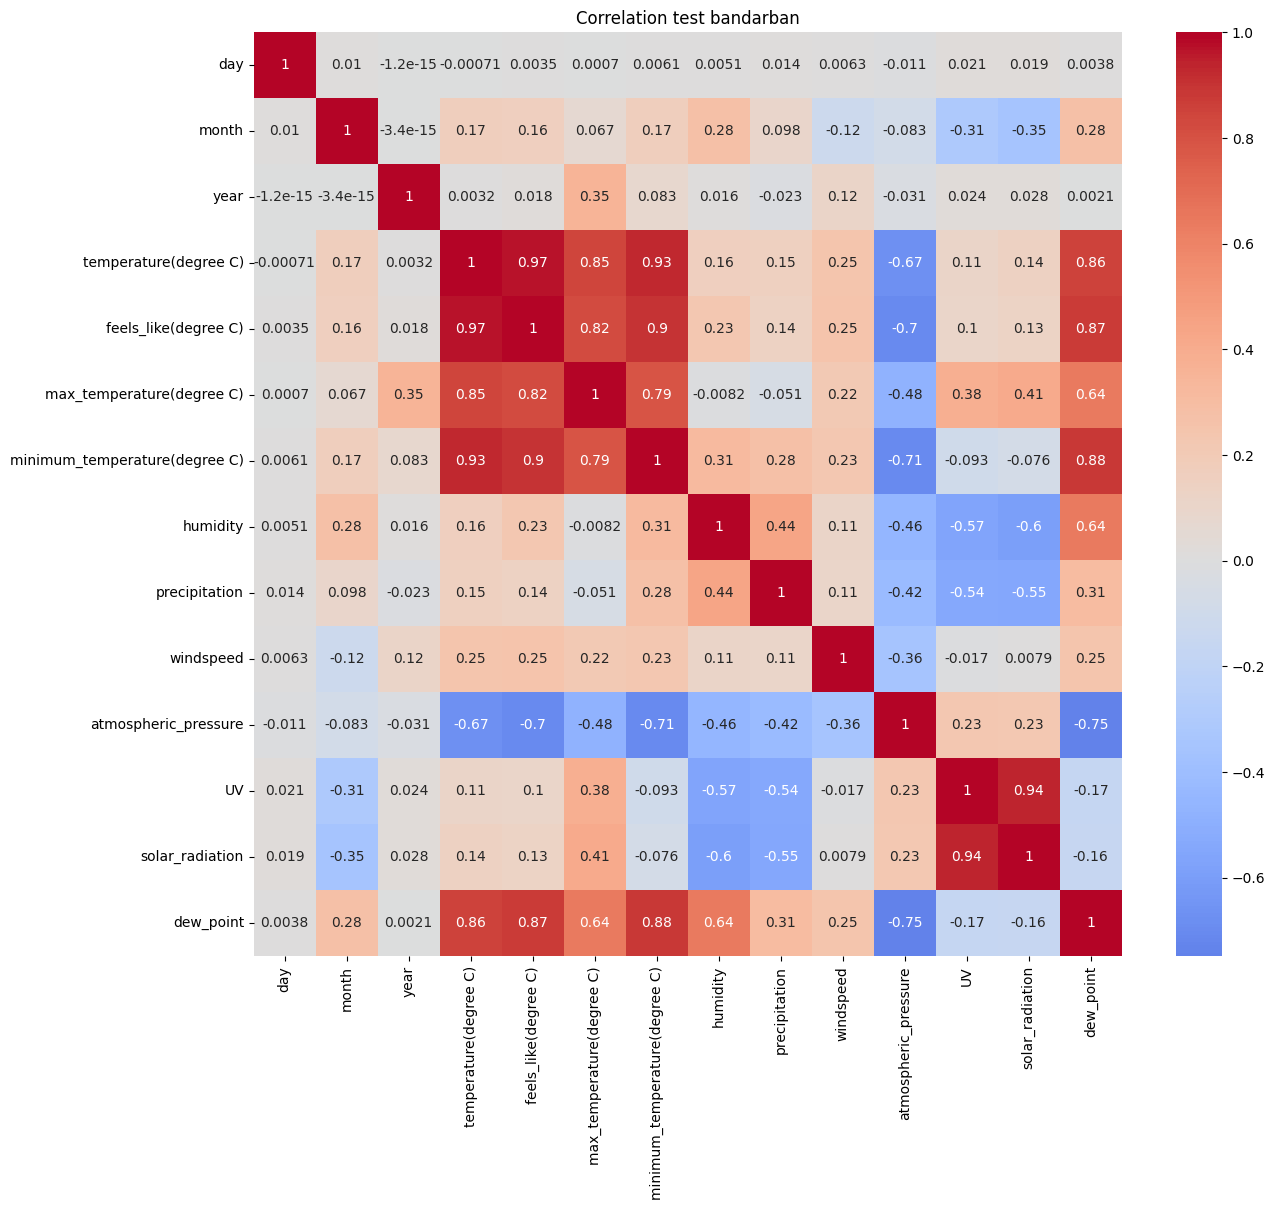

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a correlation matrix
corr_matrix = df_bandarban.corr()

# Plot the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation test bandarban')
plt.show()

# temperature

In [ ]:
df_bandarban.head()
with_no_null_HI = df_bandarban.dropna()
# df_bandarban = df_bandarban.dropna()

In [ ]:
import matplotlib.pyplot as plt

if 'date' not in df_bandarban.columns:
    df_bandarban['date'] = pd.to_datetime(df_bandarban[['year', 'month', 'day']])

# df_bandarban = df_bandarban[
#     (df_bandarban['date'] >= '2014-01-01') & (df_bandarban['date'] <= '2024-12-31')
# ]

min_date = df_bandarban['date'].min()
max_date = df_bandarban['date'].max()

plt.figure(figsize=(12, 6))
plt.plot(df_bandarban['date'], df_bandarban['temperature(degree C)'], linewidth=0.2)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature (bandarban)')
plt.grid(True)
plt.tight_layout()
plt.show()

## RF

- time series part

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, cross_val_score,train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# 1. DATA PREP & DYNAMIC FEATURE SELECTION
df = with_no_null_HI.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

df = df.sort_values('date').reset_index(drop=True)
df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df, col, period, n_terms=3):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df[col] / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df[col] / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365.25, n_terms=3)

fourier_cols = [c for c in df.columns if 'sin' in c or 'cos' in c]
FEATURES = ['day', 'month', 'year'] + fourier_cols
TARGET = 'temperature(degree C)'

X = df[FEATURES]
y = df[TARGET].values.ravel()

# Chronological Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=False)

# 2. BASE MODEL PERFORMANCE
rf_base = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rf_base.fit(X_train, y_train)
base_pred = rf_base.predict(X_test)

# 3. HYPERPARAMETER OPTIMIZATION
tscv = TimeSeriesSplit(n_splits=5)
param_dist = {
    'n_estimators': [200, 250, 300, 350, 500, 550, 600],
    'max_depth': [None,2,5,7,10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=15,
    cv=tscv,
    scoring='r2',
    random_state=42,
    n_jobs=-1,
    
)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
opt_pred = best_rf.predict(X_test)

# 4. COMPREHENSIVE PERFORMANCE MATRIX
def display_full_results(y_true, y_pred, name):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"\n--- {name} ---")
    print(f"R²    : {r2:.4f}")
    print(f"MSE   : {mse:.4f}")
    print(f"RMSE  : {rmse:.4f}")
    print("Tolerance Accuracy:")
    for t in [0.5, 1.0, 2.0, 3.0]:
        acc = 100.0 * (np.abs(y_true - y_pred) <= t).mean()
        print(f"  ±{t}°C: {acc:.2f}%")

display_full_results(y_test, base_pred, "BASE MODEL (Test Set)")
display_full_results(y_test, opt_pred, "OPTIMIZED MODEL (Test Set)")

# 5. OPTIMIZED CV PERFORMANCE MATRIX
cv_r2 = cross_val_score(best_rf, X, y, cv=tscv, scoring='r2')
cv_mse = cross_val_score(best_rf, X, y, cv=tscv, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_mse)

print("\n=== Optimized CV Performance Matrix (TimeSeriesSplit) ===")
print(f"Mean R²   : {cv_r2.mean():.4f} (+/- {cv_r2.std():.4f})")
print(f"Mean MSE  : {(-cv_mse).mean():.4f}")
print(f"Mean RMSE : {cv_rmse.mean():.4f}")
print(f"R² Fold Scores: {np.round(cv_r2, 4)}")


################## prediction code ################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. PREPARE FUTURE CALENDAR (730 Days for 2 Years) ---
last_date = df["date"].max()
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=730, freq="D")

future_df = pd.DataFrame({"date": future_dates})
future_df["year"]  = future_df["date"].dt.year
future_df["month"] = future_df["date"].dt.month
future_df["day"]   = future_df["date"].dt.day
future_df["day_of_year"] = future_df["date"].dt.dayofyear

# --- 2. ADD FOURIER FEATURES ---
def add_fourier_features(df, col, period=365.25, n_terms=3):
    for n in range(1, n_terms + 1):
        df[f"{col}_sin_{n}"] = np.sin(2 * np.pi * n * df[col] / period)
        df[f"{col}_cos_{n}"] = np.cos(2 * np.pi * n * df[col] / period)
    return df

future_df = add_fourier_features(future_df, "day_of_year", period=365.25, n_terms=3)

# --- 3. CONSTRUCT FEATURE MATRIX ---
FEATURES = list(best_rf.feature_names_in_)
X_future = future_df[FEATURES]

# --- 4. GENERATE PREDICTIONS ---
future_pred = best_rf.predict(X_future)

# --- 5. CREATE NEW FORECAST DATAFRAME ---
# We build a clean dataframe specifically for your results
forecast_results_df = future_df[["date", "year", "month", "day"]].copy()

if future_pred.ndim == 1:
    # If the model only predicts temperature
    forecast_results_df["pred_temperature"] = future_pred
    has_dew_point = False
else:
    # If the model is multi-output
    forecast_results_df["pred_temperature"] = future_pred[:, 0]
    forecast_results_df["pred_dew_point"]   = future_pred[:, 1]
    has_dew_point = True

# --- 6. VISUALIZE 2-YEAR TREND ---
plt.figure(figsize=(14, 6))
plt.plot(forecast_results_df['date'], forecast_results_df['pred_temperature'], 
         color='crimson', label='Predicted Temperature (°C)', linewidth=1.5)

if has_dew_point:
    plt.plot(forecast_results_df['date'], forecast_results_df['pred_dew_point'], 
             color='dodgerblue', label='Predicted Dew Point (°C)', linewidth=1.5, alpha=0.8)

plt.title("2-Year Meteorological Forecast (Optimized Random Forest)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value (°C)", fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

########### predicted dataframe code ##############

# Display the first few rows of the new dataframe
print("==== New 2-Year Forecast Dataframe ====")
print(forecast_results_df.head())


--- BASE MODEL (Test Set) ---
R²    : 0.7520
MSE   : 3.0603
RMSE  : 1.7494
Tolerance Accuracy:
  ±0.5°C: 21.53%
  ±1.0°C: 40.72%
  ±2.0°C: 74.50%
  ±3.0°C: 91.46%

--- OPTIMIZED MODEL (Test Set) ---
R²    : 0.8035
MSE   : 2.4253
RMSE  : 1.5573
Tolerance Accuracy:
  ±0.5°C: 22.65%
  ±1.0°C: 43.19%
  ±2.0°C: 80.57%
  ±3.0°C: 95.92%

=== Optimized CV Performance Matrix (TimeSeriesSplit) ===
Mean R²   : 0.8292 (+/- 0.0350)
Mean MSE  : 2.0661
Mean RMSE : 1.4339
R² Fold Scores: [0.8113 0.8583 0.8521 0.8561 0.7683]


## RF-LSTM hybrid

no need to chnage the features here from the feature importance. as we are training the hybrid with RF first.(RF kintu first ei kore felci.)

Executing TimeSeriesSplit CV Evaluation...
 Fold 1 R²: 0.6857
 Fold 2 R²: 0.7175
 Fold 3 R²: 0.7152
 Fold 4 R²: 0.8000
 Fold 5 R²: 0.8075
Average CV R²: 0.7452

--- BASE RF MODEL (Test Set) ---
R²: 0.8021 | MAE: 1.2822 | RMSE: 1.5627
Tolerance Accuracy:
  ±0.5°C: 22.03%
  ±1.0°C: 42.57%
  ±2.0°C: 80.20%


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



--- HYBRID RF-LSTM MODEL (Test Set) ---
R²: 0.9291 | MAE: 0.7201 | RMSE: 0.9352
Tolerance Accuracy:
  ±0.5°C: 42.08%
  ±1.0°C: 75.50%
  ±2.0°C: 97.15%


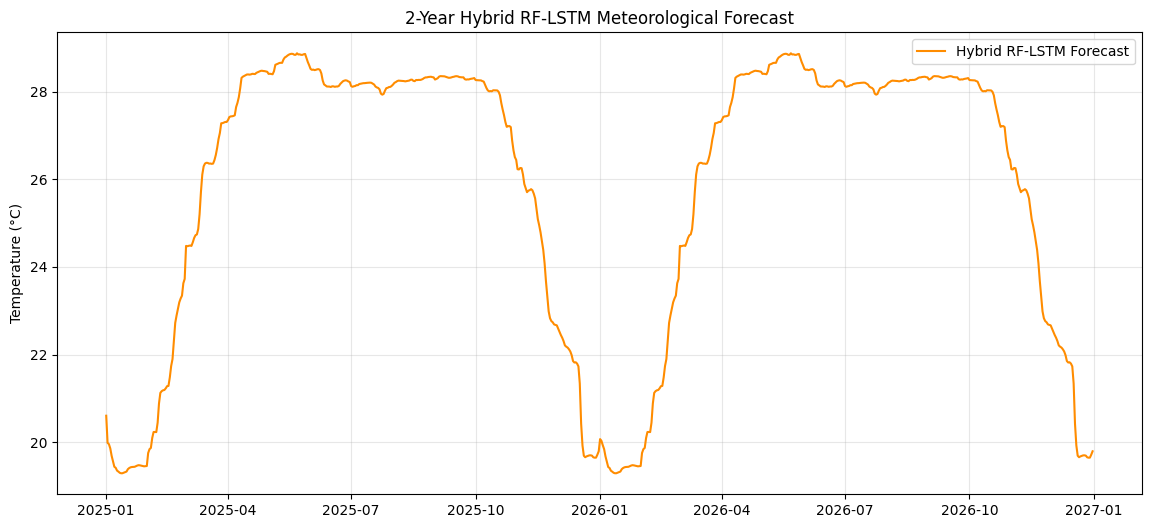


==== New 2-Year Forecast Dataframe ====
        date  pred_temperature
0 2025-01-01         20.603217
1 2025-01-02         19.983894
2 2025-01-03         19.954039
3 2025-01-04         19.857397
4 2025-01-05         19.688516


In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

# --- 1. DATA PREPARATION ---
# Assuming 'with_no_null_HI' is your pre-existing cleaned dataframe
df = with_no_null_HI.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)
df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df, col, period=365.25, n_terms=3):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df[col] / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df[col] / period)
    return df

df = add_fourier_features(df, 'day_of_year')
fourier_cols = [c for c in df.columns if 'sin' in c or 'cos' in c]
FEATURES = ['day', 'month', 'year'] + fourier_cols
TARGET = 'temperature(degree C)'

X = df[FEATURES]
y = df[TARGET].values.reshape(-1, 1)

# Split data (Sequential split for time series)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

# --- 2. PERFORMANCE HELPER FUNCTION ---
def display_metrics(y_true, y_pred, name):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    
    print(f"\n--- {name} ---")
    print(f"R²: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")
    print("Tolerance Accuracy:")
    for t in [0.5, 1.0, 2.0]:
        acc = 100.0 * (np.abs(y_true.flatten() - y_pred.flatten()) <= t).mean()
        print(f"  ±{t}°C: {acc:.2f}%")

# --- 3. TIMESERIES CROSS-VALIDATION EVALUATION ---
print("Executing TimeSeriesSplit CV Evaluation...")
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []

for fold, (train_index, val_index) in enumerate(tscv.split(X_train_full)):
    X_cv_train, X_cv_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
    y_cv_train, y_cv_val = y_train_full[train_index], y_train_full[val_index]
    
    temp_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    temp_rf.fit(X_cv_train, y_cv_train.ravel())
    preds = temp_rf.predict(X_cv_val)
    
    r2 = r2_score(y_cv_val, preds)
    cv_scores.append(r2)
    print(f" Fold {fold+1} R²: {r2:.4f}")

print(f"Average CV R²: {np.mean(cv_scores):.4f}")

# --- 4. RF HYPERPARAMETER OPTIMIZATION & BASE EVALUATION ---
rf_param_dist = {
    'n_estimators': [200, 300, 500],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', None]
}

rf_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), rf_param_dist, 
                               n_iter=5, cv=tscv, scoring='r2', n_jobs=-1)
rf_search.fit(X_train_full, y_train_full.ravel())
best_rf = rf_search.best_estimator_

# Base RF Evaluation on Test Set
rf_base_preds = best_rf.predict(X_test)
display_metrics(y_test, rf_base_preds, "BASE RF MODEL (Test Set)")

# --- 5. LSTM RESIDUAL MODELING ---
rf_train_pred = best_rf.predict(X_train_full).reshape(-1, 1)
residuals = y_train_full - rf_train_pred

scaler = StandardScaler()
res_scaled = scaler.fit_transform(residuals)

def create_sequences(data, window_size=7):
    X_seq, y_seq = [], []
    for i in range(len(data) - window_size):
        X_seq.append(data[i:i+window_size])
        y_seq.append(data[i+window_size])
    return np.array(X_seq), np.array(y_seq)

WINDOW = 14 
X_res, y_res = create_sequences(res_scaled, WINDOW)

lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(WINDOW, 1), return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
lstm_model.fit(X_res, y_res, epochs=20, batch_size=32, verbose=0)

# --- 6. HYBRID PREDICTION LOGIC ---
def hybrid_predict(X_tabular, raw_data_for_res, window=WINDOW):
    rf_part = best_rf.predict(X_tabular).reshape(-1, 1)
    current_res_scaled = scaler.transform(raw_data_for_res[-window:])
    res_input = current_res_scaled.reshape(1, window, 1)
    lstm_corr_scaled = lstm_model.predict(res_input, verbose=0)
    lstm_corr = scaler.inverse_transform(lstm_corr_scaled)
    return rf_part + lstm_corr

# Generate Hybrid predictions
test_residuals = (y_train_full - rf_train_pred).tolist()
hybrid_test_preds = []

for i in range(len(X_test)):
    p = hybrid_predict(X_test.iloc[[i]], np.array(test_residuals[-WINDOW:]))
    hybrid_test_preds.append(p[0][0])
    # Update residuals with actual error for the next step (Rolling Window)
    actual_error = y_test[i] - best_rf.predict(X_test.iloc[[i]])
    test_residuals.append(actual_error)

display_metrics(y_test, np.array(hybrid_test_preds), "HYBRID RF-LSTM MODEL (Test Set)")

# --- 7. 2-YEAR FUTURE FORECAST ---
last_date = df["date"].max()
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=730, freq="D")
future_df = pd.DataFrame({"date": future_dates, "day_of_year": future_dates.dayofyear,
                          "year": future_dates.year, "month": future_dates.month, "day": future_dates.day})
future_df = add_fourier_features(future_df, "day_of_year")

X_future = future_df[FEATURES]
future_hybrid_preds = []
current_residuals = np.array(test_residuals[-WINDOW:])

for i in range(len(X_future)):
    p = hybrid_predict(X_future.iloc[[i]], current_residuals)
    future_hybrid_preds.append(p[0][0])
    current_residuals = np.roll(current_residuals, -1)
    current_residuals[-1] = 0 # Future residuals assumed 0 (convergence to RF mean)

future_df["pred_temperature"] = future_hybrid_preds

# --- 8. VISUALIZATION ---
plt.figure(figsize=(14, 6))
plt.plot(future_df['date'], future_df['pred_temperature'], color='darkorange', label='Hybrid RF-LSTM Forecast')
plt.title("2-Year Hybrid RF-LSTM Meteorological Forecast")
plt.ylabel("Temperature (°C)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print("\n==== New 2-Year Forecast Dataframe ====")
print(future_df[["date", "pred_temperature"]].head())

## XGBoost 


--- BASE XGB MODEL (Test Set) ---
R²    : 0.7644
MSE   : 2.9076
RMSE  : 1.7052
Tolerance Accuracy:
  ±0.5°C: 19.93%
  ±1.0°C: 39.73%
  ±2.0°C: 74.75%
  ±3.0°C: 93.56%

--- OPTIMIZED XGB MODEL (Test Set) ---
R²    : 0.8084
MSE   : 2.3650
RMSE  : 1.5378
Tolerance Accuracy:
  ±0.5°C: 23.02%
  ±1.0°C: 45.67%
  ±2.0°C: 81.19%
  ±3.0°C: 95.54%

=== Optimized CV Performance Matrix (TimeSeriesSplit) ===
Mean R²   : 0.8373 (+/- 0.0260)
Mean MSE  : 1.9739
Mean RMSE : 1.4031
R² Fold Scores: [0.821  0.8554 0.8584 0.858  0.7936]


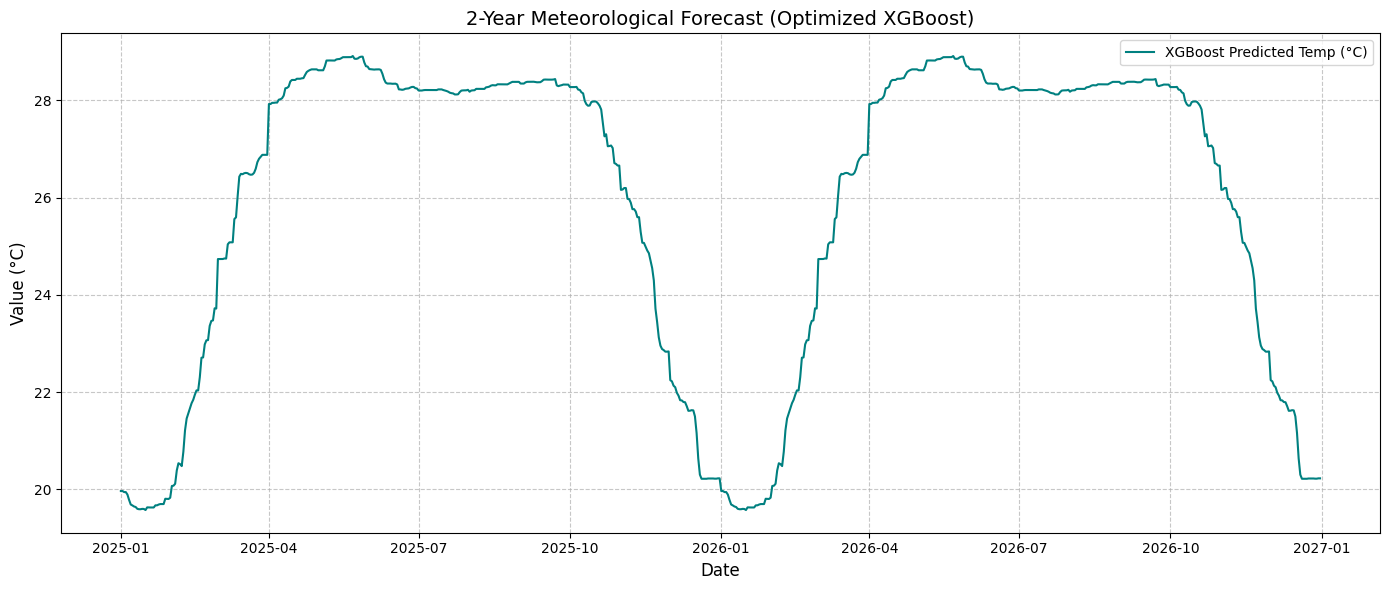

==== New 2-Year XGBoost Forecast Dataframe ====
        date  year  month  day  pred_temperature
0 2025-01-01  2025      1    1         19.966265
1 2025-01-02  2025      1    2         19.966265
2 2025-01-03  2025      1    3         19.944622
3 2025-01-04  2025      1    4         19.944622
4 2025-01-05  2025      1    5         19.893299


In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# 1. DATA PREP & DYNAMIC FEATURE SELECTION
df = with_no_null_HI.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

df = df.sort_values('date').reset_index(drop=True)
df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df, col, period, n_terms=3):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df[col] / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df[col] / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365.25, n_terms=3)

fourier_cols = [c for c in df.columns if 'sin' in c or 'cos' in c]
FEATURES = ['day', 'month', 'year'] + fourier_cols
TARGET = 'temperature(degree C)'

X = df[FEATURES]
y = df[TARGET].values.ravel()

# Chronological Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=False)

# 2. BASE XGBOOST PERFORMANCE
# objective='reg:squarederror' is standard for regression
xgb_base = XGBRegressor(n_estimators=500, learning_rate=0.05, random_state=42, n_jobs=-1)
xgb_base.fit(X_train, y_train)
base_pred = xgb_base.predict(X_test)

# 3. HYPERPARAMETER OPTIMIZATION
tscv = TimeSeriesSplit(n_splits=5)

# XGBoost specific parameters
param_dist = {
    'n_estimators': [200, 250, 300, 350, 500, 550, 600],
    'max_depth': [None,2,5,7,10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2]
}

xgb_search = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=param_dist,
    n_iter=15,
    cv=tscv,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_
opt_pred = best_xgb.predict(X_test)

# 4. COMPREHENSIVE PERFORMANCE MATRIX
def display_full_results(y_true, y_pred, name):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"\n--- {name} ---")
    print(f"R²    : {r2:.4f}")
    print(f"MSE   : {mse:.4f}")
    print(f"RMSE  : {rmse:.4f}")
    print("Tolerance Accuracy:")
    for t in [0.5, 1.0, 2.0, 3.0]:
        acc = 100.0 * (np.abs(y_true - y_pred) <= t).mean()
        print(f"  ±{t}°C: {acc:.2f}%")

display_full_results(y_test, base_pred, "BASE XGB MODEL (Test Set)")
display_full_results(y_test, opt_pred, "OPTIMIZED XGB MODEL (Test Set)")

# 5. OPTIMIZED CV PERFORMANCE
cv_r2 = cross_val_score(best_xgb, X, y, cv=tscv, scoring='r2')
cv_mse = cross_val_score(best_xgb, X, y, cv=tscv, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_mse)

print("\n=== Optimized CV Performance Matrix (TimeSeriesSplit) ===")
print(f"Mean R²   : {cv_r2.mean():.4f} (+/- {cv_r2.std():.4f})")
print(f"Mean MSE  : {(-cv_mse).mean():.4f}")
print(f"Mean RMSE : {cv_rmse.mean():.4f}")
print(f"R² Fold Scores: {np.round(cv_r2, 4)}")


################## prediction code ################

# --- 1. PREPARE FUTURE CALENDAR ---
last_date = df["date"].max()
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=730, freq="D")

future_df = pd.DataFrame({"date": future_dates})
future_df["year"]  = future_df["date"].dt.year
future_df["month"] = future_df["date"].dt.month
future_df["day"]   = future_df["date"].dt.day
future_df["day_of_year"] = future_df["date"].dt.dayofyear

# --- 2. ADD FOURIER FEATURES ---
future_df = add_fourier_features(future_df, "day_of_year", period=365.25, n_terms=3)

# --- 3. CONSTRUCT FEATURE MATRIX ---
# Use the same features the best_xgb model was trained on
X_future = future_df[FEATURES]

# --- 4. GENERATE PREDICTIONS ---
future_pred = best_xgb.predict(X_future)

# --- 5. CREATE NEW FORECAST DATAFRAME ---
forecast_results_df = future_df[["date", "year", "month", "day"]].copy()
forecast_results_df["pred_temperature"] = future_pred

# --- 6. VISUALIZE 2-YEAR TREND ---
plt.figure(figsize=(14, 6))
plt.plot(forecast_results_df['date'], forecast_results_df['pred_temperature'], 
         color='teal', label='XGBoost Predicted Temp (°C)', linewidth=1.5)

plt.title("2-Year Meteorological Forecast (Optimized XGBoost)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value (°C)", fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

########### predicted dataframe code ##############
print("==== New 2-Year XGBoost Forecast Dataframe ====")
print(forecast_results_df.head())

## LightGBM


--- BASE LGBM MODEL (Test Set) ---
R²    : 0.7731
MSE   : 2.8002
RMSE  : 1.6734
Tolerance Accuracy:
  ±0.5°C: 20.30%
  ±1.0°C: 40.84%
  ±2.0°C: 75.99%
  ±3.0°C: 93.56%

--- OPTIMIZED LGBM MODEL (Test Set) ---
R²    : 0.8080
MSE   : 2.3700
RMSE  : 1.5395
Tolerance Accuracy:
  ±0.5°C: 21.41%
  ±1.0°C: 44.93%
  ±2.0°C: 81.56%
  ±3.0°C: 96.41%

=== Optimized CV Performance Matrix (TimeSeriesSplit) ===
Mean R²   : 0.8213 (+/- 0.0248)
Mean MSE  : 2.1801
Mean RMSE : 1.4736
R² Fold Scores: [0.803  0.8377 0.8264 0.8545 0.7847]


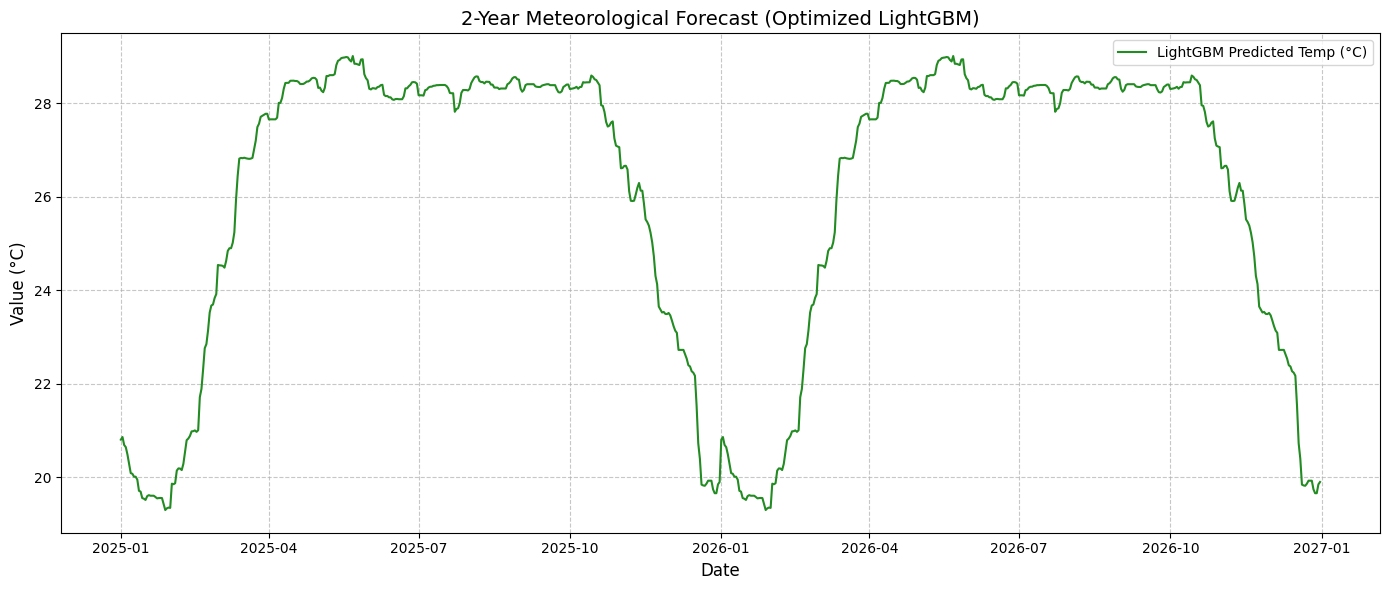

==== New 2-Year LightGBM Forecast Dataframe ====
        date  year  month  day  pred_temperature
0 2025-01-01  2025      1    1         20.800083
1 2025-01-02  2025      1    2         20.857023
2 2025-01-03  2025      1    3         20.687294
3 2025-01-04  2025      1    4         20.640305
4 2025-01-05  2025      1    5         20.483711


In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# 1. DATA PREP & DYNAMIC FEATURE SELECTION
df = with_no_null_HI.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

df = df.sort_values('date').reset_index(drop=True)
df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df, col, period, n_terms=3):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df[col] / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df[col] / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365.25, n_terms=3)

# Define features and clean names (LGBM is picky about special characters)
fourier_cols = [c for c in df.columns if 'sin' in c or 'cos' in c]
FEATURES = ['day', 'month', 'year'] + fourier_cols
TARGET = 'temperature(degree C)'

X = df[FEATURES]
y = df[TARGET].values.ravel()

# Chronological Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=False)

# 2. BASE LIGHTGBM PERFORMANCE
# verbose=-1 silences the unnecessary warnings during training
lgbm_base = LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42, n_jobs=-1, verbose=-1)
lgbm_base.fit(X_train, y_train)
base_pred = lgbm_base.predict(X_test)

# 3. HYPERPARAMETER OPTIMIZATION
tscv = TimeSeriesSplit(n_splits=5)

# LightGBM specific parameters
param_dist = {
    'n_estimators': [200, 250, 300, 350, 500, 550, 600],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 50, 100],  # Critical for LGBM (Leaf-wise growth)
    'max_depth': [-1, 5, 10, 15],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

lgbm_search = RandomizedSearchCV(
    estimator=LGBMRegressor(random_state=42, verbose=-1),
    param_distributions=param_dist,
    n_iter=15,
    cv=tscv,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)
lgbm_search.fit(X_train, y_train)
best_lgbm = lgbm_search.best_estimator_
opt_pred = best_lgbm.predict(X_test)

# 4. COMPREHENSIVE PERFORMANCE MATRIX
def display_full_results(y_true, y_pred, name):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"\n--- {name} ---")
    print(f"R²    : {r2:.4f}")
    print(f"MSE   : {mse:.4f}")
    print(f"RMSE  : {rmse:.4f}")
    print("Tolerance Accuracy:")
    for t in [0.5, 1.0, 2.0, 3.0]:
        acc = 100.0 * (np.abs(y_true - y_pred) <= t).mean()
        print(f"  ±{t}°C: {acc:.2f}%")

display_full_results(y_test, base_pred, "BASE LGBM MODEL (Test Set)")
display_full_results(y_test, opt_pred, "OPTIMIZED LGBM MODEL (Test Set)")

# 5. OPTIMIZED CV PERFORMANCE
cv_r2 = cross_val_score(best_lgbm, X, y, cv=tscv, scoring='r2')
cv_mse = cross_val_score(best_lgbm, X, y, cv=tscv, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_mse)

print("\n=== Optimized CV Performance Matrix (TimeSeriesSplit) ===")
print(f"Mean R²   : {cv_r2.mean():.4f} (+/- {cv_r2.std():.4f})")
print(f"Mean MSE  : {(-cv_mse).mean():.4f}")
print(f"Mean RMSE : {cv_rmse.mean():.4f}")
print(f"R² Fold Scores: {np.round(cv_r2, 4)}")

################## prediction code ################

# --- 1. PREPARE FUTURE CALENDAR ---
last_date = df["date"].max()
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=730, freq="D")

future_df = pd.DataFrame({"date": future_dates})
future_df["year"]  = future_df["date"].dt.year
future_df["month"] = future_df["date"].dt.month
future_df["day"]   = future_df["date"].dt.day
future_df["day_of_year"] = future_df["date"].dt.dayofyear

# --- 2. ADD FOURIER FEATURES ---
future_df = add_fourier_features(future_df, "day_of_year", period=365.25, n_terms=3)

# --- 3. CONSTRUCT FEATURE MATRIX ---
X_future = future_df[FEATURES]

# --- 4. GENERATE PREDICTIONS ---
future_pred = best_lgbm.predict(X_future)

# --- 5. CREATE NEW FORECAST DATAFRAME ---
forecast_results_df = future_df[["date", "year", "month", "day"]].copy()
forecast_results_df["pred_temperature"] = future_pred

# --- 6. VISUALIZE 2-YEAR TREND ---

plt.figure(figsize=(14, 6))
plt.plot(forecast_results_df['date'], forecast_results_df['pred_temperature'], 
         color='forestgreen', label='LightGBM Predicted Temp (°C)', linewidth=1.5)

plt.title("2-Year Meteorological Forecast (Optimized LightGBM)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value (°C)", fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

########### predicted dataframe code ##############
print("==== New 2-Year LightGBM Forecast Dataframe ====")
print(forecast_results_df.head())

## CAT Boost


--- BASE CATBOOST MODEL (Test Set) ---
R²    : 0.7850
MSE   : 2.6538
RMSE  : 1.6290
Tolerance Accuracy:
  ±0.5°C: 20.79%
  ±1.0°C: 41.09%
  ±2.0°C: 78.34%
  ±3.0°C: 95.05%

--- OPTIMIZED CATBOOST MODEL (Test Set) ---
R²    : 0.8140
MSE   : 2.2959
RMSE  : 1.5152
Tolerance Accuracy:
  ±0.5°C: 24.26%
  ±1.0°C: 45.92%
  ±2.0°C: 82.05%
  ±3.0°C: 96.04%

=== Optimized CV Performance Matrix (TimeSeriesSplit) ===
Mean R²   : 0.8367 (+/- 0.0268)
Mean MSE  : 1.9823
Mean RMSE : 1.4057
R² Fold Scores: [0.8221 0.8526 0.8546 0.8633 0.791 ]


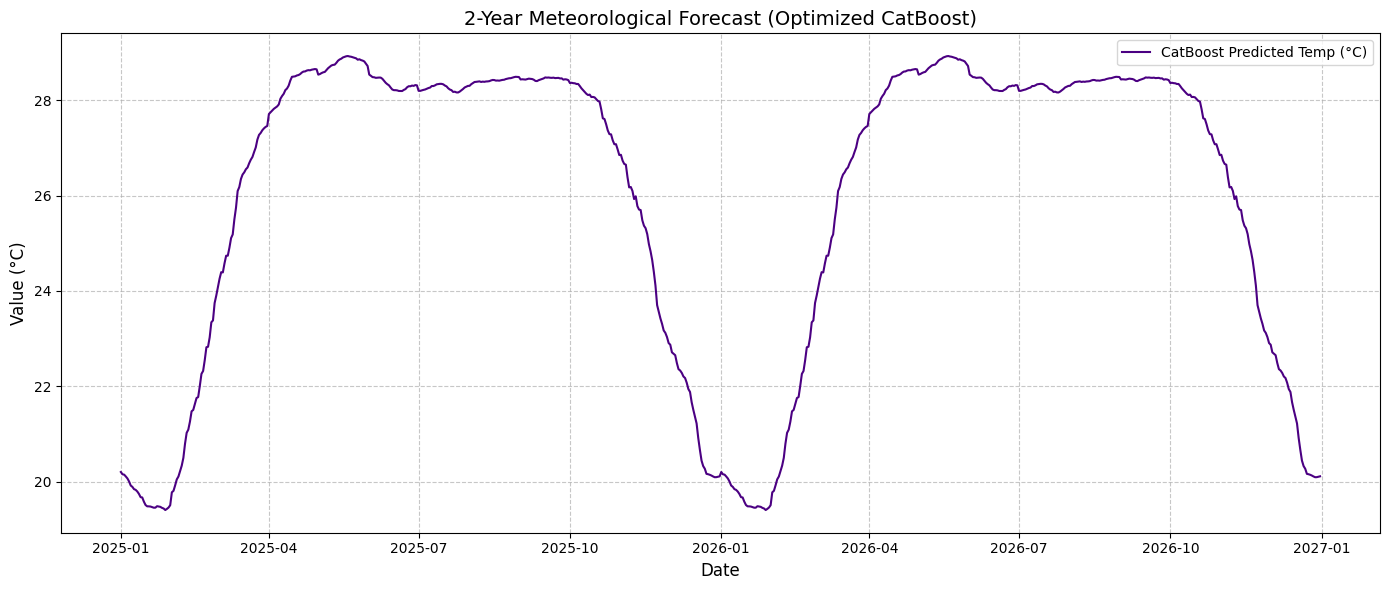

==== New 2-Year CatBoost Forecast Dataframe ====
        date  year  month  day  pred_temperature
0 2025-01-01  2025      1    1         20.204293
1 2025-01-02  2025      1    2         20.156592
2 2025-01-03  2025      1    3         20.148814
3 2025-01-04  2025      1    4         20.110867
4 2025-01-05  2025      1    5         20.068906


In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# 1. DATA PREP & DYNAMIC FEATURE SELECTION
df = with_no_null_HI.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

df = df.sort_values('date').reset_index(drop=True)
df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df, col, period, n_terms=3):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df[col] / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df[col] / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365.25, n_terms=3)

fourier_cols = [c for c in df.columns if 'sin' in c or 'cos' in c]
FEATURES = ['day', 'month', 'year'] + fourier_cols
TARGET = 'temperature(degree C)'

X = df[FEATURES]
y = df[TARGET].values.ravel()

# Chronological Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=False)

# 2. BASE CATBOOST PERFORMANCE
# silent=True prevents the model from printing iteration logs
cb_base = CatBoostRegressor(n_estimators=500, learning_rate=0.05, random_seed=42, silent=True)
cb_base.fit(X_train, y_train)
base_pred = cb_base.predict(X_test)

# 3. HYPERPARAMETER OPTIMIZATION
tscv = TimeSeriesSplit(n_splits=5)

# CatBoost specific parameters
param_dist = {
    'iterations': [200, 250, 300, 350, 500, 550, 600],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128],
    'bagging_temperature': [0, 1, 2]
}

cb_search = RandomizedSearchCV(
    estimator=CatBoostRegressor(random_seed=42, silent=True),
    param_distributions=param_dist,
    n_iter=10, # CatBoost is slower to train, fewer iterations recommended for Search
    cv=tscv,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)
cb_search.fit(X_train, y_train)
best_cb = cb_search.best_estimator_
opt_pred = best_cb.predict(X_test)

# 4. COMPREHENSIVE PERFORMANCE MATRIX
def display_full_results(y_true, y_pred, name):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"\n--- {name} ---")
    print(f"R²    : {r2:.4f}")
    print(f"MSE   : {mse:.4f}")
    print(f"RMSE  : {rmse:.4f}")
    print("Tolerance Accuracy:")
    for t in [0.5, 1.0, 2.0, 3.0]:
        acc = 100.0 * (np.abs(y_true - y_pred) <= t).mean()
        print(f"  ±{t}°C: {acc:.2f}%")

display_full_results(y_test, base_pred, "BASE CATBOOST MODEL (Test Set)")
display_full_results(y_test, opt_pred, "OPTIMIZED CATBOOST MODEL (Test Set)")

# 5. OPTIMIZED CV PERFORMANCE
cv_r2 = cross_val_score(best_cb, X, y, cv=tscv, scoring='r2')
cv_mse = cross_val_score(best_cb, X, y, cv=tscv, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_mse)

print("\n=== Optimized CV Performance Matrix (TimeSeriesSplit) ===")
print(f"Mean R²   : {cv_r2.mean():.4f} (+/- {cv_r2.std():.4f})")
print(f"Mean MSE  : {(-cv_mse).mean():.4f}")
print(f"Mean RMSE : {cv_rmse.mean():.4f}")
print(f"R² Fold Scores: {np.round(cv_r2, 4)}")

################## prediction code ################

# --- 1. PREPARE FUTURE CALENDAR ---
last_date = df["date"].max()
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=730, freq="D")

future_df = pd.DataFrame({"date": future_dates})
future_df["year"]  = future_df["date"].dt.year
future_df["month"] = future_df["date"].dt.month
future_df["day"]   = future_df["date"].dt.day
future_df["day_of_year"] = future_df["date"].dt.dayofyear

# --- 2. ADD FOURIER FEATURES ---
future_df = add_fourier_features(future_df, "day_of_year", period=365.25, n_terms=3)

# --- 3. CONSTRUCT FEATURE MATRIX ---
X_future = future_df[FEATURES]

# --- 4. GENERATE PREDICTIONS ---
future_pred = best_cb.predict(X_future)

# --- 5. CREATE NEW FORECAST DATAFRAME ---
forecast_results_df = future_df[["date", "year", "month", "day"]].copy()
forecast_results_df["pred_temperature"] = future_pred

# --- 6. VISUALIZE 2-YEAR TREND ---

plt.figure(figsize=(14, 6))
plt.plot(forecast_results_df['date'], forecast_results_df['pred_temperature'], 
         color='indigo', label='CatBoost Predicted Temp (°C)', linewidth=1.5)

plt.title("2-Year Meteorological Forecast (Optimized CatBoost)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value (°C)", fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

########### predicted dataframe code ##############
print("==== New 2-Year CatBoost Forecast Dataframe ====")
print(forecast_results_df.head())

## GRU

Data Preparation for GRU

In [85]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# --- 1. DATA PREP (Assuming df exists from your previous code) ---
# We use the same FEATURES and TARGET as your RF model
FEATURES = ['day', 'month', 'year'] + [c for c in df.columns if 'sin' in c or 'cos' in c]
TARGET = 'temperature(degree C)'

# Scaling is MANDATORY for GRUs
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(df[FEATURES])
y_scaled = scaler_y.fit_transform(df[TARGET].values.reshape(-1, 1))

# Function to create sequences (Sliding Window)
# look_back=7 means the model looks at the last 7 days to predict today
def create_sequences(X, y, look_back=7):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        Xs.append(X[i:(i + look_back)])
        ys.append(y[i + look_back])
    return np.array(Xs), np.array(ys)

LOOK_BACK = 7
X_seq, y_seq = create_sequences(X_scaled, y_scaled, LOOK_BACK)

# Chronological Split (80/20)
split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# --- 2. BUILD GRU MODEL FUNCTION ---
def build_gru_model(input_shape):
    model = Sequential([
        GRU(64, activation='relu', input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        GRU(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Train Base Model
model_base = build_gru_model((LOOK_BACK, len(FEATURES)))
history = model_base.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=0)

c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


The GRU Model Architecture

In [86]:
def evaluate_gru(model, X_input, y_true_scaled, name):
    # Predict and Inverse Scale
    preds_scaled = model.predict(X_input)
    y_pred = scaler_y.inverse_transform(preds_scaled)
    y_true = scaler_y.inverse_transform(y_true_scaled)
    
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"\n--- {name} ---")
    print(f"R²    : {r2:.4f}")
    print(f"MSE   : {mse:.4f}")
    print(f"RMSE  : {rmse:.4f}")
    
    for t in [0.5, 1.0, 2.0, 3.0]:
        acc = 100.0 * (np.abs(y_true - y_pred) <= t).mean()
        print(f" ±{t}°C: {acc:.2f}%")

evaluate_gru(model_base, X_test, y_test, "BASE GRU MODEL (Test Set)")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

--- BASE GRU MODEL (Test Set) ---
R²    : 0.4242
MSE   : 7.1084
RMSE  : 2.6661
 ±0.5°C: 13.51%
 ±1.0°C: 29.00%
 ±2.0°C: 59.98%
 ±3.0°C: 77.70%


In [87]:
tscv = TimeSeriesSplit(n_splits=3) # Reduced splits for speed
cv_scores = []

print("\n=== Starting TimeSeriesSplit Validation (GRU) ===")

fold = 1
for train_index, val_index in tscv.split(X_seq):
    X_cv_train, X_cv_val = X_seq[train_index], X_seq[val_index]
    y_cv_train, y_cv_val = y_seq[train_index], y_seq[val_index]
    
    model_cv = build_gru_model((LOOK_BACK, len(FEATURES)))
    model_cv.fit(X_cv_train, y_cv_train, epochs=20, batch_size=32, verbose=0)
    
    # Evaluate
    preds = model_cv.predict(X_cv_val)
    r2 = r2_score(y_cv_val, preds)
    cv_scores.append(r2)
    print(f"Fold {fold} R²: {r2:.4f}")
    fold += 1

print(f"\nMean CV R²: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")


=== Starting TimeSeriesSplit Validation (GRU) ===


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fold 1 R²: 0.7606


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fold 2 R²: 0.7488


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fold 3 R²: 0.7659

Mean CV R²: 0.7585 (+/- 0.0071)


In [88]:
# Prepare future feature matrix (similar to your RF code)
# ... [future_df preparation same as your code] ...
X_future_scaled = scaler_X.transform(future_df[FEATURES])

# Initial window from the end of our existing data
current_batch = X_scaled[-LOOK_BACK:].reshape(1, LOOK_BACK, len(FEATURES))
future_predictions = []

for i in range(730):  # 2 years
    # Predict next step
    current_pred = model_base.predict(current_batch, verbose=0)
    future_predictions.append(current_pred[0, 0])
    
    # Update batch: remove oldest, add newest (using future features for the rest)
    next_row_features = X_future_scaled[i].copy()
    # Note: In a pure recursive model, you'd replace 'temperature' features if they were inputs.
    # Since your features are time-based (Fourier), we just shift the window.
    new_row = next_row_features.reshape(1, 1, len(FEATURES))
    current_batch = np.append(current_batch[:, 1:, :], new_row, axis=1)

# Inverse scale results
final_forecast = scaler_y.inverse_transform(np.array(future_predictions).reshape(-1, 1))
forecast_results_df["pred_temperature"] = final_forecast

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


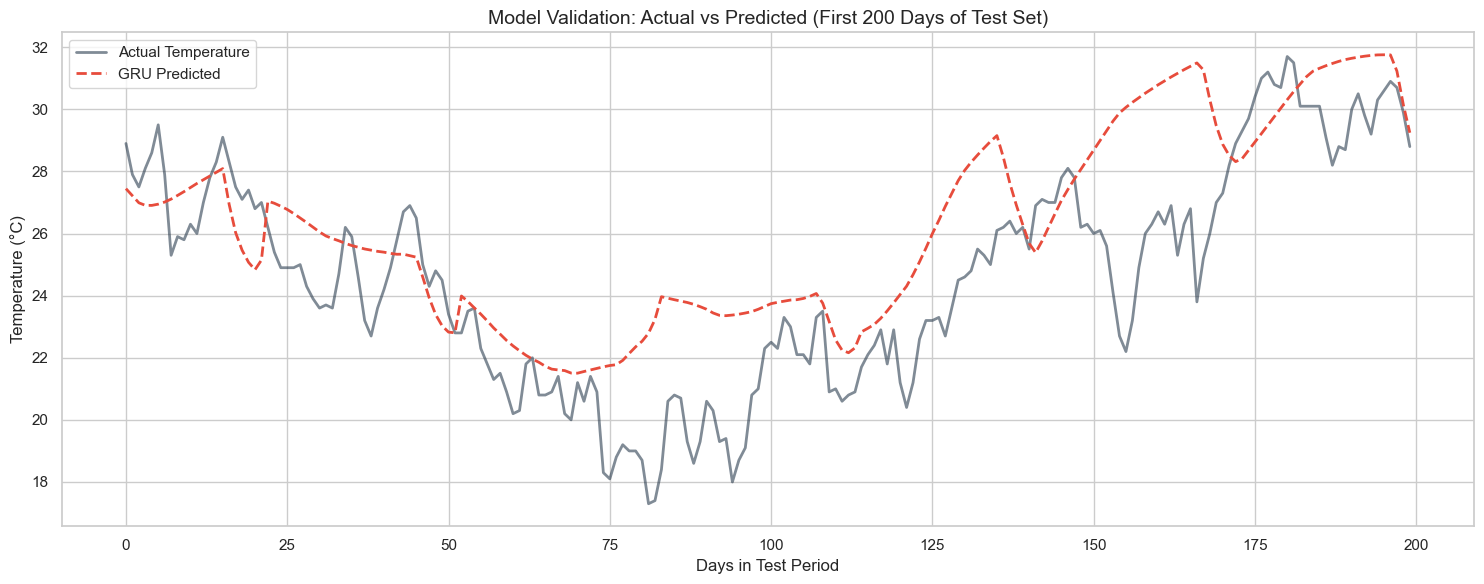

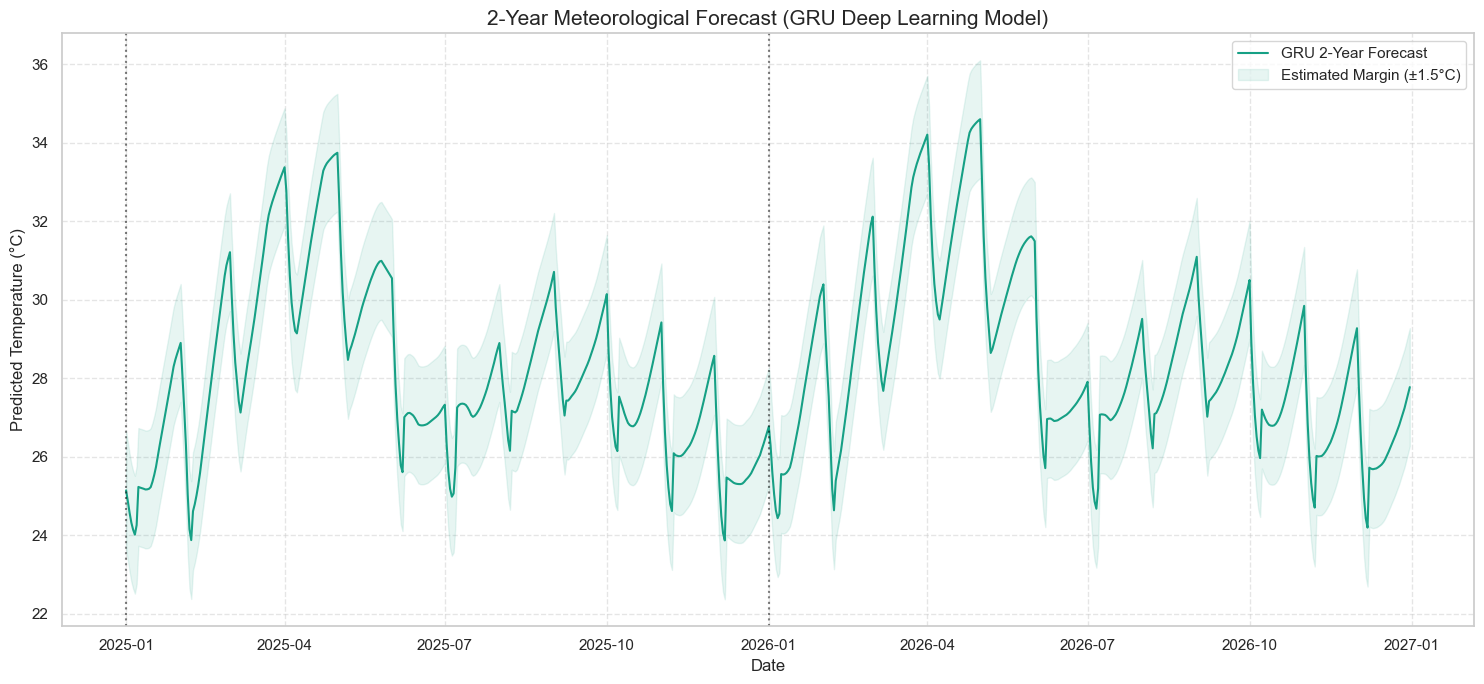

<module 'matplotlib.pyplot' from 'c:\\Python313\\Lib\\site-packages\\matplotlib\\pyplot.py'>

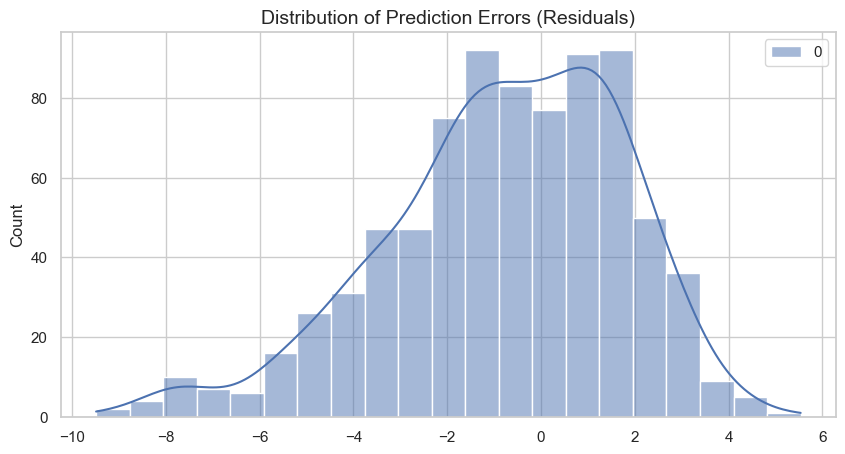

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_theme(style="whitegrid")

# --- 1. TEST SET VALIDATION PLOT (Zoomed in for clarity) ---
plt.figure(figsize=(15, 6))
# We inverse scale the test data for the plot
y_test_actual = scaler_y.inverse_transform(y_test)
y_test_pred = scaler_y.inverse_transform(model_base.predict(X_test))

plt.plot(y_test_actual[:200], label='Actual Temperature', color='#2c3e50', alpha=0.6, linewidth=2)
plt.plot(y_test_pred[:200], label='GRU Predicted', color='#e74c3c', linestyle='--', linewidth=2)

plt.title("Model Validation: Actual vs Predicted (First 200 Days of Test Set)", fontsize=14)
plt.xlabel("Days in Test Period", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

# --- 2. 2-YEAR FUTURE FORECAST PLOT ---
plt.figure(figsize=(15, 7))

# Plotting the forecast results dataframe created in the previous step
plt.plot(forecast_results_df['date'], forecast_results_df['pred_temperature'], 
         color='#16a085', label='GRU 2-Year Forecast', linewidth=1.5)

# Adding visual markers for years
plt.axvline(pd.Timestamp(f"{last_date.year + 1}-01-01"), color='black', linestyle=':', alpha=0.5)
plt.axvline(pd.Timestamp(f"{last_date.year + 2}-01-01"), color='black', linestyle=':', alpha=0.5)

plt.title("2-Year Meteorological Forecast (GRU Deep Learning Model)", fontsize=15)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Predicted Temperature (°C)", fontsize=12)
plt.fill_between(forecast_results_df['date'], 
                 forecast_results_df['pred_temperature'] - 1.5, 
                 forecast_results_df['pred_temperature'] + 1.5, 
                 color='#16a085', alpha=0.1, label='Estimated Margin (±1.5°C)')

plt.legend(loc='upper right')
plt.grid(True, which='major', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- 3. ERROR DISTRIBUTION (Residuals) ---
residuals = y_test_actual - y_test_pred
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, color='purple')
plt.title("Distribution of Prediction Errors (Residuals)", fontsize=14)
plt

## LSTM 

Training LSTM...
Epoch 1/50


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0394 - val_loss: 0.0062
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0068 - val_loss: 0.0047
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0061 - val_loss: 0.0048
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0059 - val_loss: 0.0058
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0060 - val_loss: 0.0042
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0056 - val_loss: 0.0043
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0056 - val_loss: 0.0045
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0055 - val_loss: 0.0039
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0055 - val_loss: 0.0038
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0054 - val_loss: 0.0040
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0054 - val_loss: 0.0044
Epoch 12/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0054 - val_l

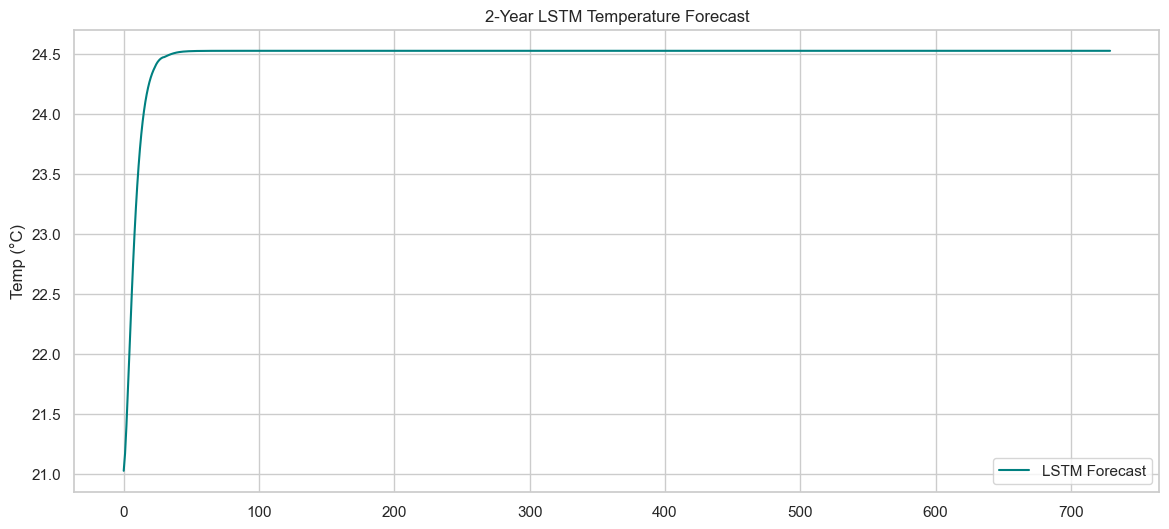

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

# --- 1. DATA PREP & SEQUENCE CREATION ---
df = with_no_null_HI.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

df = df.sort_values('date').reset_index(drop=True)
df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df, col, period=365.25, n_terms=3):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df[col] / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df[col] / period)
    return df

df = add_fourier_features(df, 'day_of_year')
FEATURES = ['day', 'month', 'year'] + [c for c in df.columns if 'sin' in c or 'cos' in c]
TARGET = 'temperature(degree C)'

# Scaling is MANDATORY for LSTMs
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(df[FEATURES])
y_scaled = scaler_y.fit_transform(df[[TARGET]])

# Create Sequences (Using past 30 days to predict today)
def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 30
X_seq, y_seq = create_sequences(X_scaled, y_scaled, TIME_STEPS)

# Chronological Split
split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# --- 2. BUILD & TRAIN LSTM ---
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

print("Training LSTM...")
history = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.1, 
    verbose=1
)

# --- 3. EVALUATION ---
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test)

def display_full_results(y_true, y_pred, name):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"\n--- {name} ---")
    print(f"R²    : {r2:.4f}")
    print(f"RMSE  : {rmse:.4f}")
    for t in [0.5, 1.0, 2.0]:
        acc = 100.0 * (np.abs(y_true - y_pred) <= t).mean()
        print(f"  ±{t}°C: {acc:.2f}%")

display_full_results(y_test_unscaled, y_pred, "LSTM MODEL (Test Set)")

# --- 4. FUTURE PREDICTION (RECURSIVE) ---
# To predict 2 years, we need to feed the model's own predictions back as input
last_sequence = X_scaled[-TIME_STEPS:] # Start with the last known data
future_preds = []

# For simplicity in this example, we'll use a 'sliding window' approach
# on the future features (dates) you generated in the RF code.
current_batch = last_sequence.reshape((1, TIME_STEPS, len(FEATURES)))

for i in range(730):  # 2 years
    # Predict next step
    next_pred = model.predict(current_batch, verbose=0)
    future_preds.append(next_pred[0, 0])
    
    # Update batch: remove first day, add new prediction (this is a simplified version)
    # Note: In a real scenario, you'd also need to update the date features in X_scaled
    new_row = current_batch[:, 1:, :]
    # This part is tricky because features include date info which changes. 
    # For a pure LSTM forecast, we'll assume the model learned the seasonality.
    current_batch = np.append(new_row, [[[next_pred[0,0]] * len(FEATURES)]], axis=1)

future_temp = scaler_y.inverse_transform(np.array(future_preds).reshape(-1, 1))

# --- 5. VISUALIZE ---
plt.figure(figsize=(14, 6))
plt.plot(future_temp, color='teal', label='LSTM Forecast')
plt.title("2-Year LSTM Temperature Forecast")
plt.ylabel("Temp (°C)")
plt.legend()
plt.show()

## ANN

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

# --- 1. Seasonal/Quarterly Dummies ---
# Customizing for Bandarban's climate (Pre-monsoon, Monsoon, Post-monsoon, Winter)
df['month'] = df['date'].dt.month
df['is_monsoon'] = df['month'].isin([ 6, 7, 8]).astype(int)
df['is_winter'] = df['month'].isin([12, 1]).astype(int)
df['is_pre_monsoon'] = df['month'].isin([4, 5]).astype(int)
season_cols = ['is_monsoon', 'is_winter', 'is_pre_monsoon']

# --- 2. Advanced Lagging (Including 365-Day Lag) ---
# Adding the yearly lag is crucial for long-term 2025 stability
lags = [1, 2, 3, 7, 14, 365] 
lag_cols = []

# List of base features identified in your correlation matrix [cite: 36]
base_features = ['dew_point', 'atmospheric_pressure', 'max_temperature(degree C)']

for lag in lags:
    for col in base_features:
        feat_name = f"{col.split('_')[0]}_lag_{lag}"
        df[feat_name] = df[col].shift(lag)
        lag_cols.append(feat_name)

# --- 3. Solar Cycle Proxy ---
# Using a 12-month (365 day) rolling average of Solar Radiation 
# helps the model capture if 2024 was abnormally high/low compared to history.
if 'solar_radiation' in df.columns:
    df['solar_rolling_365'] = df['solar_radiation'].transform(lambda x: x.rolling(window=365).mean())
    solar_cols = ['solar_rolling_365']
else:
    solar_cols = []

# --- 4. 7-Day Rolling Averages ---
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['max_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window=7).mean())
rolling_cols = ['dew_roll_7', 'atm_roll_7', 'max_roll_7']

# Clean up NaNs from lags and rolling windows
df = df.dropna().reset_index(drop=True)

# --- 5. Fourier Features ---
df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df, col, period, n_terms=5):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df[col] / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df[col] / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=5)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]

# Final Feature Set [cite: 63]
FEATURES = fourier_cols + lag_cols + rolling_cols + season_cols + solar_cols

In [ ]:

FEATURES = fourier_cols + lag_cols + rolling_cols + season_cols + solar_cols

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

# 1. Scale Features and Target
scaler_X_ann = StandardScaler()
scaler_y_ann = StandardScaler()

X_scaled_ann = scaler_X_ann.fit_transform(X)
y_scaled_ann = scaler_y_ann.fit_transform(y.values.reshape(-1, 1))

# Split matching your CatBoost logic (80/20, shuffle=False)
split_idx = int(len(X_scaled_ann) * 0.8)
X_train_ann, X_test_ann = X_scaled_ann[:split_idx], X_scaled_ann[split_idx:]
y_train_ann, y_test_ann = y_scaled_ann[:split_idx], y_scaled_ann[split_idx:]

# build model 

def build_ann(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dense(1) # Linear output for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Initial Training
ann_model = build_ann(X_train_ann.shape[1])
ann_model.fit(X_train_ann, y_train_ann, epochs=100, batch_size=32, verbose=0)

# Predictions & Inverse Scaling
y_pred_scaled_ann = ann_model.predict(X_test_ann)
y_pred_ann = scaler_y_ann.inverse_transform(y_pred_scaled_ann)
y_test_actual = scaler_y_ann.inverse_transform(y_test_ann)

mse_ann = mean_squared_error(y_test_actual, y_pred_ann)
rmse_ann = np.sqrt(mse_ann)
r2_ann = r2_score(y_test_actual, y_pred_ann)

print(f"\nANN Results for temperature :")
print(f'Mean Squared Error: {mse_ann:.4f}')
print(f'RMSE: {rmse_ann:.4f}')
print(f'R² Score: {r2_ann:.4f}')

# CV

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_ann = []
r2_list_ann = []
mse_list_ann = []

for train_index, test_index in tscv.split(X_scaled_ann):
    X_train_kf, X_test_kf = X_scaled_ann[train_index], X_scaled_ann[test_index]
    y_train_kf, y_test_kf = y_scaled_ann[train_index], y_scaled_ann[test_index]

    # Re-instantiate model for each fold
    ann_kf = build_ann(X_train_kf.shape[1])
    ann_kf.fit(X_train_kf, y_train_kf, epochs=50, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = ann_kf.predict(X_test_kf)
    y_pred_kf = scaler_y_ann.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y_ann.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_ann.append(np.sqrt(mse_kf))
    mse_list_ann.append(mse_kf)
    r2_list_ann.append(r2_score(y_test_kf_unscaled, y_pred_kf))

average_r2_ann = np.mean(r2_list_ann)
average_mse_ann = np.mean(mse_list_ann)
average_rmse_ann = np.mean(rmse_list_ann)

print("\n")
print(f"Average RMSE from ANN CV: {average_rmse_ann:.4f}")
print(f"Average R² from ANN CV: {average_r2_ann:.4f}")
print(f"Average MSE: {average_mse_ann:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_ann}")

# importance
def calculate_ann_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    baseline_preds = model.predict(X_val, verbose=0)
    y_val_unscaled = scaler_y.inverse_transform(y_val)
    baseline_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(baseline_preds))
    
    importance_results = []
    for i in range(X_val.shape[1]): # Iterate through 2D features
        X_permuted = X_val.copy()
        np.random.shuffle(X_permuted[:, i])
        
        permuted_preds = model.predict(X_permuted, verbose=0)
        permuted_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(permuted_preds))
        
        importance_results.append(max(0, permuted_mse - baseline_mse))

    return pd.DataFrame({'Feature': feature_names, 'Importance': importance_results}).sort_values(by='Importance', ascending=False)

ann_importance_df = calculate_ann_permutation_importance(ann_model, X_test_ann, y_test_ann, scaler_y_ann, FEATURES)

diff = (r2_ann - np.mean(r2_list_ann))*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nANN Permutation Feature Importances:")
print(ann_importance_df)

## CNN-LSTM model hybrid

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

# --- 1. Seasonal/Quarterly Dummies ---
# Customizing for Bandarban's climate (Pre-monsoon, Monsoon, Post-monsoon, Winter)
df['month'] = df['date'].dt.month
df['is_monsoon'] = df['month'].isin([ 6, 7, 8]).astype(int)
df['is_winter'] = df['month'].isin([12, 1]).astype(int)
df['is_pre_monsoon'] = df['month'].isin([4, 5]).astype(int)
season_cols = ['is_monsoon', 'is_winter', 'is_pre_monsoon']

# --- 2. Advanced Lagging (Including 365-Day Lag) ---
# Adding the yearly lag is crucial for long-term 2025 stability
lags = [1, 2, 3, 7, 14, 365] 
lag_cols = []

# List of base features identified in your correlation matrix [cite: 36]
base_features = ['dew_point', 'atmospheric_pressure', 'max_temperature(degree C)']

for lag in lags:
    for col in base_features:
        feat_name = f"{col.split('_')[0]}_lag_{lag}"
        df[feat_name] = df[col].shift(lag)
        lag_cols.append(feat_name)

# --- 3. Solar Cycle Proxy ---
# Using a 12-month (365 day) rolling average of Solar Radiation 
# helps the model capture if 2024 was abnormally high/low compared to history.
if 'solar_radiation' in df.columns:
    df['solar_rolling_365'] = df['solar_radiation'].transform(lambda x: x.rolling(window=365).mean())
    solar_cols = ['solar_rolling_365']
else:
    solar_cols = []

# --- 4. 7-Day Rolling Averages ---
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['max_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window=7).mean())
rolling_cols = ['dew_roll_7', 'atm_roll_7', 'max_roll_7']

# Clean up NaNs from lags and rolling windows
df = df.dropna().reset_index(drop=True)

# --- 5. Fourier Features ---
df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df, col, period, n_terms=5):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df[col] / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df[col] / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=5)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]

# Final Feature Set [cite: 63]
FEATURES = fourier_cols + lag_cols + rolling_cols + season_cols + solar_cols

In [ ]:

FEATURES = fourier_cols + lag_cols + rolling_cols + season_cols + solar_cols

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.layers import BatchNormalization

def model_builder(hp):
    model = Sequential()
    
    # Tune CNN Filters
    hp_filters = hp.Int('filters', min_value=32, max_value=64, step=32)
    model.add(Conv1D(filters=hp_filters, kernel_size=3, activation='relu', input_shape=(100,1)))
    model.add(MaxPooling1D(pool_size=2))
    
    # Tune Dropout
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.4, step=0.1)
    model.add(Dropout(hp_dropout))

    # Tune LSTM Units
    hp_lstm_units = hp.Int('lstm_units', min_value=32, max_value=64, step=16)
    model.add(LSTM(units=hp_lstm_units, activation='tanh'))
    model.add(Dropout(hp_dropout))

    # Final Dense Layers
    model.add(Dense(hp.Int('dense_units', 16, 64, 16), activation='relu'))
    model.add(Dense(1))

    # Tune Learning Rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mse')
    return model

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# Example: Using the last 30 days to predict tomorrow
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# X_3D shape will be (Total_Days, 30, 1)
X_3D, y_target = create_sequences(df['temperature(degree C)'].values)
X_3D = X_3D.reshape((X_3D.shape[0], X_3D.shape[1], 1))

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.layers import BatchNormalization

# 1. Prepare 3D Data (Samples, Time Steps, Features)
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size]) 
    return np.array(X), np.array(y)

def build_hybrid(input_shape):
    model = Sequential([
        # 1. CNN Stage: Extracts spatial/local patterns from the window
        # Reducing filters to 32 is often better for ~4k rows to prevent noise capture
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(100,1)),
        BatchNormalization(), # Stabilizes learning and speeds up convergence
        MaxPooling1D(pool_size=2),
        Dropout(0.2), # Standard regularization

        # 2. LSTM Stage: Learns temporal dependencies
        # tanh is the standard and most stable activation for LSTM
        LSTM(64, activation='tanh', return_sequences=False), 
        Dropout(0.2),

        # 3. Fully Connected Stage
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1) # Output for UV prediction
    ])
    
    # Using a slightly lower learning rate (0.0005) helps with smaller datasets
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Setup Data
window = 30
data_values = df['temperature(degree C)'].values.reshape(-1, 1)
X, y = create_sequences(data_values, window)

# --- BASE PERFORMANCE ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = build_hybrid((window, 1))
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

y_pred = model.predict(X_test)
base_mse = mean_squared_error(y_test, y_pred)
base_rmse = np.sqrt(base_mse)
base_r2 = r2_score(y_test, y_pred)

print(f"Base Results: R2: {base_r2:.4f}, MSE: {base_mse:.4f}, RMSE: {base_rmse:.4f}")

# --- 5-FOLD CROSS VALIDATION ---
kf = KFold(n_splits=5, shuffle=False)
cv_r2, cv_mse, cv_rmse = [], [], []

for train_idx, test_idx in kf.split(X):
    m = build_hybrid((window, 1))
    m.fit(X[train_idx], y[train_idx], epochs=10, batch_size=32, verbose=0)
    
    p = m.predict(X[test_idx])
    cv_r2.append(r2_score(y[test_idx], p))
    cv_mse.append(mean_squared_error(y[test_idx], p))
    cv_rmse.append(np.sqrt(cv_mse[-1]))


cnn_lstm_r2_cv = np.mean(cv_r2)
cnn_lstm_mse_cv = np.mean(cv_mse)
cnn_lstm_rmse_cv = np.mean(cv_rmse)

print(f"5-Fold CV Average: R2: {cnn_lstm_r2_cv:.4f}, MSE: {cnn_lstm_mse_cv:.4f}, RMSE: {cnn_lstm_rmse_cv:.4f}")
print ()

## Model performance chart temp

In [ ]:
# model performance chart 
MODEL_NAMES = ["Random Forest", "RF-LSTM hybrid", "XGBoost", "LightGBM", "CatBoost", "GRU", "LSTM", "ANN", "CNN-LSTM hybrid"]

R_SQUARED_VALUES = [r2_rf, rf_lstm_r2, r2_xgb, r2_lgb, r2_cat, r2_gru, r2_lstm, r2_ann, base_r2 ]
R2CV = [average_r2_rf, rf_lstm_r2_cv, average_r2_xgb, average_r2_lgb, average_r2_cat, average_r2_gru, average_r2_lstm, average_r2_ann, cnn_lstm_r2_cv ]

R2_DIFF = [
    (r2_rf - average_r2_rf), 
    (rf_lstm_r2 - rf_lstm_r2_cv), 
    (r2_xgb - average_r2_xgb), 
    (r2_lgb - average_r2_lgb), 
    (r2_cat - average_r2_cat), 
    (r2_gru - average_r2_gru), 
    (r2_lstm - average_r2_lstm), 
    (r2_ann - average_r2_ann), 
    (base_r2 - cnn_lstm_r2_cv)
]

MSE_VALUES = [mse_rf, rf_lstm_mse, mse_xgb, mse_lgb, mse_cat, mse_gru, mse_lstm, mse_ann, base_mse ]
MSE_CV = [average_mse_rf, rf_lstm_mse_cv, average_mse_xgb, average_mse_lgb, average_mse_cat, average_mse_gru, average_mse_lstm, average_mse_ann, cnn_lstm_mse_cv ]

RMSE_VALUES = [rmse_rf, rf_lstm_rmse, rmse_xgb, rmse_lgb, rmse_cat, rmse_gru, rmse_lstm, rmse_ann , base_rmse ]
RMSE_CV = [average_rmse_rf, rf_lstm_rmse_cv, average_rmse_xgb, average_rmse_lgb, average_rmse_cat, average_rmse_gru, average_rmse_lstm, average_rmse_ann, cnn_lstm_rmse_cv]

data = {
    "Model": MODEL_NAMES,
    "R^2": R_SQUARED_VALUES,
    "CVR2": R2CV,
    "R2 DIFF": R2_DIFF,
    "MSE": MSE_VALUES,
    "MSE CV": MSE_CV,
    "RMSE": RMSE_VALUES,
    "RMSE CV": RMSE_CV
}

df_performance = pd.DataFrame(data).sort_values(by=["R2 DIFF","R^2"], ascending= [True, True])

print (df_performance)

In [ ]:
import pandas as pd

# 1. Define weights for your 'Best Logical Model' criteria
# We want high R^2, low RMSE, and low R2 DIFF (stability)
weights = {
    'R^2': 0.4,       # Predictive power
    'MSE': 0.3,
    'RMSE': 0.3,     # Magnitude of error
    'R2 DIFF': 0.3    # Robustness/Generalization
}

# 2. Create a Ranking Score (Lower is better)
# .rank(ascending=False) means highest value gets rank 1
# .rank(ascending=True) means lowest value gets rank 1
df_performance['Score'] = (
    df_performance['R^2'].rank(ascending=False) * weights['R^2'] +
    df_performance['MSE'].rank(ascending=True) * weights['MSE'] +
    df_performance['RMSE'].rank(ascending=True) * weights['RMSE']  +
    df_performance['R2 DIFF'].rank(ascending=True) * weights['R2 DIFF']
)

# 3. Extract the winner
best_logical_model = df_performance.loc[df_performance['Score'].idxmin()]

print(f"The Best Logical Model is: {best_logical_model['Model']}")
print(f"--- Reason: Balanced score across R^2 ({best_logical_model['R^2']:.4f}) "
      f"and Stability (DIFF: {best_logical_model['R2 DIFF']:.4f})")

In [ ]:
import pandas as pd
import numpy as np

# 1. Setup 2025 Dataframe
future_dates = pd.date_range(start='2025-01-01', end='2025-01-07', freq='D')
df_2025 = pd.DataFrame({'date': future_dates})
df_2025['year'] = df_2025['date'].dt.year
df_2025['month'] = df_2025['date'].dt.month
df_2025['day'] = df_2025['date'].dt.day
df_2025['day_of_year'] = df_2025['date'].dt.dayofyear

# 2. Add Static Features (Seasons & Fourier)
df_2025['is_monsoon'] = df_2025['month'].isin([6, 7, 8, 9, 10]).astype(int)
df_2025['is_winter'] = df_2025['month'].isin([11, 12, 1, 2]).astype(int)
df_2025['is_pre_monsoon'] = df_2025['month'].isin([3, 4, 5]).astype(int)
df_2025 = add_fourier_features(df_2025, 'day_of_year', period=365, n_terms=5)

# 3. Prepare Full Dataframe for Lags
# We need 2024 data to "seed" the first few days of 2025
full_df = pd.concat([df, df_2025], axis=0).reset_index(drop=True)

# 4. THE RECURSIVE PREDICTION LOOP
print("Starting Recursive Prediction for 2025...")
for i in range(len(full_df)):
    if full_df.loc[i, 'date'].year == 2025:
        # A. Update Lags for the current day [cite: 37, 41-43, 160-163]
        for lag in [1, 2, 3, 7, 14, 365]:
            full_df.loc[i, f'dew_lag_{lag}'] = full_df.loc[i - lag, 'dew_point']
            full_df.loc[i, f'atm_lag_{lag}'] = full_df.loc[i - lag, 'atmospheric_pressure']
            full_df.loc[i, f'max_lag_{lag}'] = full_df.loc[i - lag, 'max_temperature(degree C)']
            # If you named your 365 lag differently:
            # full_df.loc[i, 'dew_lag_365'] = full_df.loc[i - 365, 'dew_point']

        # B. Update Rolling Averages [cite: 45-48, 159, 162]
        full_df.loc[i, 'dew_roll_7'] = full_df.loc[i-7:i-1, 'dew_point'].mean()
        full_df.loc[i, 'atm_roll_7'] = full_df.loc[i-7:i-1, 'atmospheric_pressure'].mean()
        full_df.loc[i, 'max_roll_7'] = full_df.loc[i-7:i-1, 'max_temperature(degree C)'].mean()

        # C. Prepare Features for GRU
        current_features = full_df.loc[[i], FEATURES]
        
        # Scaling is mandatory for GRU
        X_scaled = scaler_X.transform(current_features)
        X_reshaped = X_scaled.reshape((1, 1, len(FEATURES)))

        # D. Predict and Inverse Scale
        y_pred_scaled = gru_model.predict(X_reshaped, verbose=0)
        y_pred_celsius = scaler_y.inverse_transform(y_pred_scaled)[0, 0]

        # E. SAVE PREDICTION BACK TO THE DF
        # This is the "chain" that makes the next day work
        full_df.loc[i, 'temperature(degree C)'] = y_pred_celsius
        
        # PROXY FIX: Since we aren't predicting Dew/Atm, use last year's values 
        # so the loop doesn't hit NaNs for the next iteration
        full_df.loc[i, 'dew_point'] = full_df.loc[i - 365, 'dew_point']
        full_df.loc[i, 'atmospheric_pressure'] = full_df.loc[i - 365, 'atmospheric_pressure']
        full_df.loc[i, 'max_temperature(degree C)'] = full_df.loc[i - 365, 'max_temperature(degree C)']

# 5. Result Extraction
df_2025_raw = full_df[full_df['date'].dt.year == 2025].copy()

In [ ]:
# 1. Scale using the previously fitted scaler
X_2025_scaled = scaler_X.transform(df_2025_raw)

# 2. Reshape for GRU (samples, 1, features)
X_2025_reshaped = X_2025_scaled.reshape((X_2025_scaled.shape[0], 1, X_2025_scaled.shape[1]))

# 3. Predict
y_2025_pred_scaled = gru_model.predict(X_2025_reshaped)

# 4. Inverse Transform to get actual Temperature
y_2025_pred = scaler_y.inverse_transform(y_2025_pred_scaled)

# 5. Create a clean results table
prediction_results = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Temperature': y_2025_pred.flatten()
})

print(prediction_results.head(10))

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(prediction_results['Date'], prediction_results['Predicted_Temperature'], label='2025 Forecast', color='orange')
plt.title('Bandarban Temperature Forecast for 2025')
plt.ylabel('Temp (°C)')
plt.legend()
plt.show()

In [ ]:
# based on the prediction create the dataframe for 2025 and head()
df_2025 = df_2025[df_2025['date'].dt.year == 2025].reset_index(drop=True)
print ("predicted temperature of 2025: \n")
df_2025.iloc[1:8]



=================================================================

# Humidty prediction 

In [ ]:
# import pandas as pd
# import numpy as np
# df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
# df_bandarban = df_bandarban.drop('district', axis =1 )

In [ ]:
df_bandarban.head()

## RF

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# ------------------------------------------------------------------
# 1. Start from your *clean* dataframe
# ------------------------------------------------------------------
# copy and ensure a proper datetime column exists
df = with_no_null_HI.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


temp_col = 'temperature(degree C)'
dew_col = 'humidity'
desired_columns = ['day', 'month', 'year', dew_col, temp_col]
missing = [c for c in desired_columns if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns: {missing}. Available columns: {list(df.columns)}")

df = df[desired_columns].copy()


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)


df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df, col, period, n_terms=3):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df[col] / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df[col] / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365.25, n_terms=3)

# Collect Fourier columns robustly
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


FEATURES = ['day', 'month', 'year'] + fourier_cols
TARGET = [dew_col]

X = df[FEATURES]
y = df[TARGET].astype(float)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
    max_features='sqrt'
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rf_r2_f  = r2_score(y_test, y_pred)
rf_mse_f = mean_squared_error(y_test, y_pred)
rf_rmse_f = np.sqrt(rf_mse_f)

def tolerance_accuracy(y_true, y_hat, tol):
    """Return percentage of values within tolerance (works for multi-output)."""
    # y_true/y_hat shape: (n_samples, n_targets)
    return 100.0 * (np.abs(y_true - y_hat) <= tol).mean()

rf_acc_05 = tolerance_accuracy(y_test.values, y_pred, 0.5)
rf_acc_10 = tolerance_accuracy(y_test.values, y_pred, 1.0)
rf_acc_20 = tolerance_accuracy(y_test.values, y_pred, 2.0)
rf_acc_30 = tolerance_accuracy(y_test.values, y_pred, 3.0)

print("=== Random Forest + Fourier – Dew-Point Prediction (Test) ===")
print(f"R²          : {rf_r2_f:.4f}")
print(f"RMSE        : {rf_rmse_f:.3f} °C")
print(f"MSE         : {rf_mse_f:.4f}")
print("Accuracy (± tolerance):")
print(f"  ±0.5 °C : {rf_acc_05:5.2f}%")
print(f"  ±1.0 °C : {rf_acc_10:5.2f}%")
print(f"  ±2.0 °C : {rf_acc_20:5.2f}%")
print(f"  ±3.0 °C : {rf_acc_30:5.2f}%")

# ------------------------------------------------------------------
# 9. 5-fold CV (R²)
# ------------------------------------------------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)
rf_cv_r2 = cross_val_score(rf, X, y, cv=cv, scoring='r2', n_jobs=-1)

print("\n=== 5-Fold CV R² (with Fourier) ===")
print(f"Mean : {rf_cv_r2.mean():.4f}  (±{rf_cv_r2.std():.4f})")
print(f"Scores: {np.round(rf_cv_r2, 4)}")

fi = pd.DataFrame({
    'feature'   : FEATURES,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== Feature Importances (Top 10) ===")
print(fi.head(10).to_string(index=False))

c:\Python313\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


=== Random Forest + Fourier – Dew-Point Prediction (Test) ===
R²          : 0.5236
RMSE        : 5.992 °C
MSE         : 35.9093
Accuracy (± tolerance):
  ±0.5 °C :  3.99%
  ±1.0 °C :  7.98%
  ±2.0 °C : 15.91%
  ±3.0 °C : 23.66%

=== 5-Fold CV R² (with Fourier) ===
Mean : 0.5246  (±0.0079)
Scores: [0.5207 0.522  0.5277 0.5381 0.5146]

=== Feature Importances (Top 10) ===
          feature  importance
             year    0.298300
            month    0.172980
day_of_year_cos_1    0.150786
day_of_year_sin_1    0.115975
day_of_year_sin_2    0.072215
              day    0.056029
day_of_year_cos_3    0.052791
day_of_year_cos_2    0.041541
day_of_year_sin_3    0.039383


## RF-LSTM hybrid

no need to chnage the features here from the feature importance. as we are training the hybrid with RF first.(RF kintu first ei kore felci.)

In [30]:

X = df[FEATURES]
y = df[dew_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)


In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

def create_sequences(x_data, y_data, window_size=5):
    X_seq, y_seq = [], []
    for i in range(window_size, len(x_data)):
        X_seq.append(x_data[i-window_size:i]) # Grab the previous 'n' days
        y_seq.append(y_data[i])               # The error of the CURRENT day
    return np.array(X_seq), np.array(y_seq)

# 1. Chronological Split (No Shuffling!)
train_size = int(len(df) * 0.8)

# These keep their column names (Good for RF)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# 2. Re-fit your RF models on X_train explicitly to ensure they "own" the names
rf.fit(X_train, y_train)


# Get predictions on the training set using the DataFrames
train_preds_temp = rf.predict(X_train)

# Calculate Residuals (Errors)
res_temp = y_train.values - train_preds_temp


# Combine into a single error target for the LSTM
train_residuals = np.column_stack([res_temp])

# 1. Scale the features for the LSTM
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)



# --- NEW SLIDING WINDOW BLOCK ---
window_size = 5  # You can try 3, 5, or 7

# Create sequences for training
X_train_lstm, train_residuals_seq = create_sequences(X_train_scaled, train_residuals, window_size)

# Create sequences for testing
X_test_lstm, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 3)), window_size)

# Update the LSTM Input Shape
lstm_model = Sequential([
    Input(shape=(window_size, X_train_lstm.shape[2])), # Updated: shape is now (5, features)
    LSTM(32, activation='tanh'), 
    Dense(16, activation='relu'),
    Dense(3) 
])
# Note: Use train_residuals_seq here instead of train_residuals
lstm_model.compile(optimizer='adam', loss='mae')
lstm_model.fit(X_train_lstm, train_residuals_seq, epochs=40, batch_size=32, verbose=0)

# --- UPDATED PREDICTION BLOCK ---
# We skip the first 'window_size' rows of X_test to match the LSTM output
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# Get RF predictions on the ALIGNED test set
rf_t_pred = rf.predict(X_test_aligned)

# Get LSTM corrections (These will already be aligned because of create_sequences)
corrections = lstm_model.predict(X_test_lstm)

# Combine
final_temp = rf_t_pred + corrections[:, 0]


print(f"Windowed UV R2: {r2_score(y_test_aligned, final_temp):.4f}")
print(f"Windowed UV MSE: {mean_squared_error(y_test_aligned, final_temp):.4f}")
print(f"Windowed UV RMSE: {np.sqrt(mean_squared_error(y_test_aligned, final_temp)):.4f}")



26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Windowed UV R2: 0.3017
Windowed UV MSE: 65.9715
Windowed UV RMSE: 8.1223


In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

# --- STEP 1: Selective Features for LSTM ---
# We only give the LSTM the most important "weather" features to reduce noise
# lstm_feature_cols = [
#     'minimum_temperature(degree C)',
#     'temp_lag_1',
#     'temp_roll_7', # 
#     'temp_lag_2', # 
#     'temp_lag_3', # 
#     'atm_roll_7', # 
#     'atm_lag_2', # ~ 1.84 r2
#     'atmospheric_pressure', # r2 -> ~ 1.15
#     'atm_lag_1', # 89.78/90.78 ~ -1
#     'day_of_year_sin_3', # 90.84/91.71 ~ -0.86
#     'atm_lag_3', # 90.79/91.60 ~-0.80 [better]
#     # 'day_of_year_cos_1', # 90.69/91.87 ~-1.18
#     # 'day_of_year_sin_1' # 90.61/91.81 ~-1.20
# ]

lstm_feature_cols = FEATURES

X_train_slim = X_train[lstm_feature_cols]
X_test_slim = X_test[lstm_feature_cols]

scaler_slim = StandardScaler()
X_train_scaled = scaler_slim.fit_transform(X_train_slim)
X_test_scaled = scaler_slim.transform(X_test_slim)

# --- STEP 2: Create Sequences ---
window_size = 7 # Try a full week
X_train_seq, y_train_res_seq = create_sequences(X_train_scaled, train_residuals, window_size)
X_test_seq, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)

# --- STEP 3: Optimized LSTM ---
lstm_model = Sequential([
    Input(shape=(window_size, X_train_scaled.shape[1])),
    LSTM(100, activation='tanh', return_sequences=True), # Return sequences for deeper learning
    LSTM(50, activation='tanh'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2) 
])

# Use a slightly slower learning rate to find the pattern

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber') # Huber loss is great for weather outliers
lstm_model.fit(X_train_seq, y_train_res_seq, epochs=60, batch_size=64, verbose=0)

# 1. Align the Test Data (Skip the first 7 days used for the window)
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# 2. Get the "Base" predictions from your Random Forest
rf_t_pred = rf.predict(X_test_aligned)

# 3. Get the "Corrections" from the LSTM
# X_test_seq was created during your sequence step
lstm_corrections = lstm_model.predict(X_test_seq)

# 4. Combine them: Base + Correction
final_uv = rf_t_pred + lstm_corrections[:, 0]

rf_lstm_r2 = r2_score(y_test_aligned, final_uv)
rf_lstm_mse = mean_squared_error(y_test_aligned, final_uv)
rf_lstm_rmse = np.sqrt(rf_lstm_mse)

# 5. Output the New Results
print("--- HYBRID MODEL PERFORMANCE ---")
print(f"Final temperature R2: {rf_lstm_r2:.4f}")
print(f"Final temperature MSE: {rf_lstm_mse:.4f}")
print(f"Final temperature RMSE: {rf_lstm_mse:.4f}")
# final r2 90.90/89.87 

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
--- HYBRID MODEL PERFORMANCE ---
Final temperature R2: 0.2927
Final temperature MSE: 66.9885
Final temperature RMSE: 66.9885


In [33]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt



# 1. Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Assuming X and y are your full datasets before the train/test split
# X_full, y_full, rf_model, create_sequences need to be defined in your workspace

HUM = 'humidity'
X_full = df[FEATURES]
y_full = df[HUM]

fold = 1
lstmRf_hybrid_r2_scores = []
lstmRf_hybrid_mse_scores = []
lstmRf_hybrid_rmse_scores = []

for train_index, test_index in tscv.split(X_full):

    print(f"--- Processing Fold {fold} ---")
    
    # Split Data
    X_train_cv, X_test_cv = X_full.iloc[train_index], X_full.iloc[test_index]
    y_train_cv, y_test_cv = y_full.iloc[train_index], y_full.iloc[test_index]
    
    # --- STEP 1: Random Forest Base Model (Required for Residuals) ---

    # Training the RF on the current fold's training set
    rf.fit(X_train_cv, y_train_cv)
    train_residuals = y_train_cv - rf.predict(X_train_cv)
    
    # --- STEP 2: Preprocessing for LSTM ---
    # lstm_feature_cols = [
    #     'minimum_temperature(degree C)',
    # 'temp_lag_1',
    # 'temp_roll_7', # 
    # 'temp_lag_2', # 
    # 'temp_lag_3', # 
    # 'atm_roll_7', # 
    # 'atm_lag_2', # ~ 1.84 r2
    # 'atmospheric_pressure', # r2 -> ~ 1.15
    # 'atm_lag_1', # 89.78/90.78 ~ -1
    # 'day_of_year_sin_3', # 90.84/91.71 ~ -0.86
    # 'atm_lag_3', # 90.79/91.60 ~-0.80 [better]
    # ]

    lstm_feature_cols = FEATURES

    scaler = StandardScaler().set_output(transform="pandas")

    X_train_scaled = scaler.fit_transform(X_train_cv[lstm_feature_cols])
    X_test_scaled = scaler.transform(X_test_cv[lstm_feature_cols])
    
    # --- STEP 3: Create Sequences ---
    window_size = 5
    X_train_seq, y_train_res_seq = create_sequences(X_train_scaled, train_residuals.values, window_size)
    # We pass zeros for y_test as we only need the X sequences for prediction
    X_test_seq, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)
    
    # --- STEP 4: Train LSTM ---
    # Re-initialize the model each fold to avoid weight leakage
    lstm_model = Sequential([
        Input(shape=(window_size, X_train_scaled.shape[1])),
        LSTM(100, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1) 
    ])
    
    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber')
    lstm_model.fit(X_train_seq, y_train_res_seq, epochs=30, batch_size=64, verbose=0)
    
    # --- STEP 5: Hybrid Prediction & Evaluation ---
    # Align target data (drop first 'window_size' rows)
    y_test_aligned = y_test_cv.iloc[window_size:]
    rf_base_pred = rf.predict(X_test_cv.iloc[window_size:])
    
    lstm_corrections = lstm_model.predict(X_test_seq)
    lstmRf_hybrid_prediction = rf_base_pred + lstm_corrections[:, 0] # Adjust index if target is multi-output
    
    # Calculate Metrics
    lstmRf_hybrid_r2_kf = r2_score(y_test_aligned, lstmRf_hybrid_prediction)
    lstmRf_hybrid_mse_kf = mean_squared_error(y_test_aligned, lstmRf_hybrid_prediction)
    lstmRf_hybrid_rmse_kf = np.sqrt(lstmRf_hybrid_mse_kf)

    lstmRf_hybrid_r2_scores.append(lstmRf_hybrid_r2_kf)
    lstmRf_hybrid_mse_scores.append(lstmRf_hybrid_mse_kf)
    lstmRf_hybrid_rmse_scores.append(lstmRf_hybrid_rmse_kf)

    print(f"Fold {fold} R2: {lstmRf_hybrid_r2_kf:.4f}")
    print(f"Fold {fold} MSE: {lstmRf_hybrid_mse_kf:.4f}")
    print(f"Fold {fold} RMSE: {lstmRf_hybrid_rmse_kf:.4f}")
    fold += 1

rf_lstm_r2_cv = np.mean(lstmRf_hybrid_r2_scores)
rf_lstm_mse_cv = np.mean(lstmRf_hybrid_mse_scores)
rf_lstm_rmse_cv = np.mean(lstmRf_hybrid_rmse_scores)

print("\n--- FINAL CROSS-VALIDATION RESULTS ---")
print(f"Mean R2: {rf_lstm_r2_cv:.4f} (+/- {np.std(lstmRf_hybrid_r2_scores):.4f})")
print(f"Mean mse: {rf_lstm_mse_cv:.4f} (+/- {np.std(lstmRf_hybrid_mse_scores):.4f})")
print(f"Mean rmse: {rf_lstm_rmse_cv:.4f} (+/- {np.std(lstmRf_hybrid_rmse_scores):.4f})")



--- Processing Fold 1 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Fold 1 R2: -0.4286
Fold 1 MSE: 78.9871
Fold 1 RMSE: 8.8875
--- Processing Fold 2 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Fold 2 R2: 0.0973
Fold 2 MSE: 52.9101
Fold 2 RMSE: 7.2739
--- Processing Fold 3 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Fold 3 R2: 0.1591
Fold 3 MSE: 71.0355
Fold 3 RMSE: 8.4283
--- Processing Fold 4 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Fold 4 R2: 0.0895
Fold 4 MSE: 63.6190
Fold 4 RMSE: 7.9762
--- Processing Fold 5 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Fold 5 R2: 0.2461
Fold 5 MSE: 69.1631
Fold 5 RMSE: 8.3164

--- FINAL CROSS-VALIDATION RESULTS ---
Mean R2: 0.0327 (+/- 0.2374)
Mean mse: 67.1430 (+/- 8.6546)
Mean rmse: 8.1764 (+/- 0.5373)


## XGBoost

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation	' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
    df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'UV_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])


# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())
df['UV_roll_7'] = df['UV'].transform(lambda x: x.rolling(window =7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['dew_roll_7', 'solar_roll_7', 'UV_roll_7','atm_roll_7', 'ppt_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
FEATURES = [
    'precipitation', 
    'dew_point', 
    'solar_radiation', 
    'day_of_year_sin_1', 
    'solar_roll_7', 
    'ppt_lag_1', 
    'UV', 
    'ppt_roll_7', 
    'day_of_year_sin_2', 
    'dew_roll_7', 
    'day_of_year_cos_1', 
    'solar_lag_1', 
    'UV_roll_7', 
    'solar_lag_2', # 82.13/79.02 *3.10
    'day_of_year_sin_3', 
    'atm_roll_7', 
    'day_of_year_cos_3', 
    'dew_lag_1', 
    'dew_lag_3', # 82.04/79.27 *2.76
    'dew_lag_2', # 82.17/78.98 *3.18
    'UV_lag_1', # 82.10/79.41 *2.6886
    'atmospheric_pressure', # 81.35/79.42 *1.92
    # 'atm_lag_1', #82.54/79.16 *3.37

]

# FEATURES = [ 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 82.47/79.34 * 3.13

X = df[FEATURES]
y = df['humidity']
'''
XGBoost Feature Importances:
                 Feature  Importance
4          precipitation    0.391550
0              dew_point    0.125664
1        solar_radiation    0.117972
5      day_of_year_sin_1    0.071883
27          solar_roll_7    0.034923
15             ppt_lag_1    0.026147
2                     UV    0.024671
30            ppt_roll_7    0.019847
7      day_of_year_sin_2    0.017316
26            dew_roll_7    0.013639
6      day_of_year_cos_1    0.012701
12           solar_lag_1    0.012050
28             UV_roll_7    0.011913
17           solar_lag_2    0.010824
9      day_of_year_sin_3    0.009985
29            atm_roll_7    0.009789
10     day_of_year_cos_3    0.008633
11             dew_lag_1    0.007593
21             dew_lag_3    0.007210
16             dew_lag_2    0.007126
13              UV_lag_1    0.006627
3   atmospheric_pressure    0.006450
14             atm_lag_1    0.005978
24             atm_lag_3    0.005758
19             atm_lag_2    0.005607
18              UV_lag_2    0.005533
22           solar_lag_3    0.005318
20             ppt_lag_2    0.004791
25             ppt_lag_3    0.004673
8      day_of_year_cos_2    0.004070
23              UV_lag_3    0.003761



'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor


targets = y
xgb_model = {}
y_preds_xgb = {}
rmses_xgb = {}
r2s_xgb = {}


xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=800,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred)


print(f"\nXGBoost Results for humidity:")
print(f'Mean Squared Error: {mse_xgb:.4f}')
print(f'RMSE: {rmse_xgb:.4f}')
print(f'R² Score: {r2_xgb:.4f}')


# K-Fold cross-validation for XGBoost
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_xgb = []
r2_list_xgb = [] # Added to track R2 across all folds
mse_list_xgb = []

for train_index, test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]

        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        xgb_model_kf = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=800,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )

        xgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_xgb = xgb_model_kf.predict(X_test_kf)


        mse_kf_xgb = mean_squared_error(y_test_kf, y_pred_kf_xgb)
        rmse_kf_xgb = np.sqrt(mse_kf_xgb)
        r2_kf_xgb = r2_score(y_test_kf, y_pred_kf_xgb)

        mse_list_xgb.append(mse_kf_xgb)
        rmse_list_xgb.append(rmse_kf_xgb)
        r2_list_xgb.append(r2_kf_xgb)


        average_rmse_xgb = np.mean(rmse_list_xgb)
        average_r2_xgb = np.mean(r2_list_xgb)
        average_mse_xgb = np.mean(mse_kf_xgb)
        

print ("\n")
print(f"Average RMSE from CV: {average_rmse_xgb:.4f}")
print(f"Average R² from CV: {average_r2_xgb:.4f}")
print(f"Avarage MSE: {average_mse_xgb}")
print(f"Individual Fold RMSEs: {rmse_list_xgb}")

# Feature importance for XGBoost
importance = xgb_model_kf.feature_importances_
feature_names = X.columns
feature_importance_df_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)

diff = (r2_xgb - average_r2_xgb)*100
print ( f'\n R2 ~ {diff:.4f}')
print("\nXGBoost Feature Importances:")
print(feature_importance_df_xgb)


## LightGBM

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation	' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
    df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'UV_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])


# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())
df['UV_roll_7'] = df['UV'].transform(lambda x: x.rolling(window =7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['dew_roll_7', 'solar_roll_7', 'UV_roll_7','atm_roll_7', 'ppt_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
FEATURES = [
    'dew_point',
    'solar_radiation',
    'dew_lag_1',
    'dew_roll_7',
    'solar_lag_1',
    'atm_roll_7',
    'solar_roll_7',
    'atmospheric_pressure',
    'day_of_year_sin_3',
    'day_of_year_sin_2',
    'ppt_roll_7', # 80.43/78.77 *1.66 mse : 18.78
    'dew_lag_2', # 80.54/78.52 *2.01
    'day_of_year_sin_1', # 80.66/78.98 *1.68  Mse: 18.21 
    'solar_lag_2', # 80.86/78.82 *2.03
    'precipitation', #81.59/79.57 *2.01 mse : 17.33 [best]
    # 'atm_lag_2', #81.30/79.01 *2.28
    # 'atm_lag_1', # 81.55/79.49 *2.02
    # 'atm_lag_3', # 81.63/79.40 *2.23
    # 'day_of_year_cos_1', # 81.56/79.16 *2.40
    # 'day_of_year_cos_3', # 81.56/79.25 *2.31
    # 'dew_lag_3', # 81.62/79.16 *2.45
]

# FEATURES = [ 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 82.47/79.34 * 3.13

X = df[FEATURES]
y = df['humidity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor


''''
LightGBM Feature Importances:
                 Feature  Importance
0              dew_point         887
1        solar_radiation         395
11             dew_lag_1         242
26            dew_roll_7         232
12           solar_lag_1         199
29            atm_roll_7         197
27          solar_roll_7         193
3   atmospheric_pressure         177
9      day_of_year_sin_3         177
7      day_of_year_sin_2         174
30            ppt_roll_7         159
16             dew_lag_2         158
5      day_of_year_sin_1         157
17           solar_lag_2         148
4          precipitation         139
19             atm_lag_2         134
14             atm_lag_1         130
24             atm_lag_3         122
6      day_of_year_cos_1         118
10     day_of_year_cos_3         116
21             dew_lag_3         113
28             UV_roll_7          83
22           solar_lag_3          78
8      day_of_year_cos_2          76
15             ppt_lag_1          66
20             ppt_lag_2          48
25             ppt_lag_3          36
2                     UV          29
13              UV_lag_1          27
23              UV_lag_3          11
18              UV_lag_2           6

'''

targets = y
lgb_model = {}
y_preds_lgb = {}
rmses_lgb = {}
r2s_lgb = {}


lgb_model = lgb.LGBMRegressor(
        # n_estimators=800,
        # learning_rate=0.01,
        # max_depth=8,
        # subsample=0.8,
        # colsample_bytree=0.8,
        # random_state=42,
        # verbosity=-1

        n_estimators=300,        # Reduced to prevent memorization as UV r 4k dataset
        learning_rate=0.03,      # Slightly faster learning for fewer trees
        max_depth=6,             # Shallow trees are better for 4k rows
        num_leaves=20,           # Controls complexity
        min_child_samples=40,    # Ensures each "leaf" represents enough data
        subsample=0.7,           # More aggressive sampling for better generalization
        colsample_bytree=0.7,    # Uses 70% of features per tree
        random_state=42,
        verbosity=-1
                              # Clean console
    )

lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)

mse_lgb = mean_squared_error(y_test, y_pred)
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_test, y_pred)

print(f"\nLightGBM Results for humidity:")
print(f'Mean Squared Error: {mse_lgb:.4f}')
print(f'RMSE: {rmse_lgb:.4f}')
print(f'R² Score: {r2_lgb:.4f}')


    # --- 6) 5-fold CV R^2 ---
tscv = TimeSeriesSplit(n_splits=5)
    
rmse_list_lgb = []
r2_list_lgb = []
mse_list_lgb = []


for train_index,test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        lgb_model_kf = lgb.LGBMRegressor(
            
            n_estimators=300,        # Reduced to prevent memorization
            learning_rate=0.03,      # Slightly faster learning for fewer trees
            max_depth=6,             # Shallow trees are better for 4k rows
            num_leaves=20,           # Controls complexity
            min_child_samples=40,    # Ensures each "leaf" represents enough data
            subsample=0.7,           # More aggressive sampling for better generalization
            colsample_bytree=0.7,    # Uses 70% of features per tree
            random_state=42,
            verbosity=-1             # Clean console
        )

        lgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_lgb = lgb_model_kf.predict(X_test_kf)

        mse_kf_lgb = mean_squared_error(y_test_kf, y_pred_kf_lgb)
        rmse_kf_lgb = np.sqrt(mse_kf_lgb)
        r2_kf_lgb = r2_score(y_test_kf, y_pred_kf_lgb)
        
        mse_list_lgb.append(mse_kf_lgb)
        rmse_list_lgb.append(rmse_kf_lgb)
        r2_list_lgb.append(r2_kf_lgb)

        average_rmse_lgb = np.mean(rmse_list_lgb)
        average_r2_lgb = np.mean(r2_list_lgb)
        average_mse_lgb = np.mean(mse_kf_lgb)


print ("\n")
print(f"Average RMSE from CV: {average_rmse_lgb:.4f}")
print(f"Average R² from CV: {average_r2_lgb:.4f}")
print(f"Avarage MSE: {average_mse_lgb}")
print(f"Individual Fold RMSEs: {rmse_list_lgb}")

# Feature importance for LightGBM
importance = lgb_model.feature_importances_
feature_names = X.columns
feature_importance_df_lgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_lgb = feature_importance_df_lgb.sort_values(by='Importance', ascending=False)

diff = (r2_lgb - average_r2_lgb)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nLightGBM Feature Importances:")
print(feature_importance_df_lgb)



## CatBoost

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation	' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
    df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'UV_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])


# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())
df['UV_roll_7'] = df['UV'].transform(lambda x: x.rolling(window =7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['dew_roll_7', 'solar_roll_7', 'UV_roll_7','atm_roll_7', 'ppt_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
FEATURES = [
    'dew_point',
    'solar_radiation',
    'UV',
    'precipitation',
    'solar_lag_1',
    'solar_roll_7',
    'dew_lag_1',
    'day_of_year_sin_1',
    'day_of_year_sin_3',
    'day_of_year_sin_2',
    'UV_roll_7',
    'UV_lag_1', #82.84/80.28*2.56
    'day_of_year_cos_1',
    'dew_roll_7',
    'solar_lag_2', # *2.66
    'solar_lag_3',
    'ppt_roll_7',
    'dew_lag_2',
    'atmospheric_pressure',
    'day_of_year_cos_2', # 82.87/80.60 *2.26
    'dew_lag_3', # 82.73/80.64 *2.09 mse: 16.26 [better]
    # 'day_of_year_cos_3',
    # 'atm_roll_7', # 82.63/80.53 *2.09 mse: 16.35
    # 'ppt_lag_1', # 82.58/80.62 *1.96 mse: 16.40
    # 'atm_lag_3',
    # 'atm_lag_1',
    # 'atm_lag_2', 
    # 'ppt_lag_2', # 82.34/80.24 *2.09
    # 'UV_lag_3', # 82.32/80.53 *1.79 mse: 16.64
    # 'ppt_lag_3', # 82.65/80.58 *2.06
]

# FEATURES = [ 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 82.73/80.53 *2.19

X = df[FEATURES]
y = df['humidity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split


''''
CatBoost Feature Importances:
                 Feature  Importance
0              dew_point   38.950863
1        solar_radiation   12.961358
2                     UV    4.566434
4          precipitation    4.345488
12           solar_lag_1    3.472580
27          solar_roll_7    3.209386
11             dew_lag_1    2.898700
5      day_of_year_sin_1    2.673717
9      day_of_year_sin_3    2.329455
7      day_of_year_sin_2    2.025390
28             UV_roll_7    1.950715
13              UV_lag_1    1.741332
6      day_of_year_cos_1    1.624323
26            dew_roll_7    1.540238
17           solar_lag_2    1.529860
22           solar_lag_3    1.430589
30            ppt_roll_7    1.385346
16             dew_lag_2    1.279612
3   atmospheric_pressure    1.219854
8      day_of_year_cos_2    1.175459
21             dew_lag_3    1.143570
10     day_of_year_cos_3    1.122019
29            atm_roll_7    1.104160
15             ppt_lag_1    0.994063
24             atm_lag_3    0.748372
14             atm_lag_1    0.709465
19             atm_lag_2    0.708114
20             ppt_lag_2    0.535314
23              UV_lag_3    0.250536
25             ppt_lag_3    0.189242
18              UV_lag_2    0.184448

'''

targets = y
cat_model = {}
y_preds_cat = {}
rmses_cat = {}
r2s_cat = {}

# loss_function='RMSE' is standard for regression
cat_model = CatBoostRegressor(
        iterations=800,
        learning_rate=0.03,
        depth=6,
        l2_leaf_reg=5,           # Regularization is your friend with 4k rows
        bootstrap_type='Bayesian',
        bagging_temperature=1,
        random_strength=1,
        loss_function='RMSE',    # Or 'Huber' if you want it to match your LSTM
        random_seed=42,
        verbose=0
    )

cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)

mse_cat = mean_squared_error(y_test, y_pred)
rmse_cat = np.sqrt(mse_cat)
r2_cat = r2_score(y_test, y_pred)
    
print(f"\nLightGBM Results for temperature :")
print(f'Mean Squared Error: {mse_cat:.4f}')
print(f'RMSE: {rmse_cat:.4f}')
print(f'R² Score: {r2_cat:.4f}')


    # 3. 5-Fold Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_cat = []
r2_list_cat = []
mse_list_cat = []
    
for train_index,test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        cat_model_kf = CatBoostRegressor(
            iterations=800,
            learning_rate=0.03,
            depth=6,
            l2_leaf_reg=5,           # Regularization is your friend with 4k rows
            bootstrap_type='Bayesian',
            bagging_temperature=1,
            random_strength=1,
            loss_function='RMSE',    # Or 'Huber' if you want it to match your LSTM
            random_seed=42,
            verbose=0
        )

        cat_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_cat = cat_model_kf.predict(X_test_kf)

        mse_kf_cat = mean_squared_error(y_test_kf, y_pred_kf_cat)
        rmse_kf_cat = np.sqrt(mse_kf_cat)
        r2_kf_cat = r2_score(y_test_kf, y_pred_kf_cat)

        mse_list_cat.append(mse_kf_cat)
        rmse_list_cat.append(rmse_kf_cat)
        r2_list_cat.append(r2_kf_cat)

        average_rmse_cat = np.mean(rmse_list_cat)
        average_r2_cat = np.mean(r2_list_cat)
        average_mse_cat = np.mean(mse_list_cat)


print ("\n")
print(f"Average RMSE from CV: {average_rmse_cat:.4f}")
print(f"Average R² from CV: {average_r2_cat:.4f}")
print(f"Avarage MSE: {average_mse_cat}")
print(f"Individual Fold RMSEs: {rmse_list_cat}")

# Feature importance for LightGBM
importance = cat_model.feature_importances_
feature_names = X.columns
feature_importance_df_cat = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_cat = feature_importance_df_cat.sort_values(by='Importance', ascending=False)

diff = (r2_cat - average_r2_cat)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nCatBoost Feature Importances:")
print(feature_importance_df_cat)
    


## GRU

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation	' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
    df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'UV_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])


# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())
df['UV_roll_7'] = df['UV'].transform(lambda x: x.rolling(window =7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['dew_roll_7', 'solar_roll_7', 'UV_roll_7','atm_roll_7', 'ppt_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
FEATURES = [
    'dew_point',
    'solar_radiation',
    'solar_roll_7',
    'precipitation',
    'day_of_year_cos_1',
    'day_of_year_sin_2',
    'solar_lag_1',
    'solar_lag_2',
    'UV_roll_7',
    'atmospheric_pressure',
    'ppt_roll_7',
    'dew_roll_7',
    'solar_lag_3',
    'ppt_lag_1',
    'atm_lag_3',
    'dew_lag_1',
    'UV_lag_2',
    'UV_lag_1',
    'day_of_year_sin_3',
    'day_of_year_cos_2',
    'day_of_year_cos_3',
    'atm_lag_1', # 83.20/80.28 *2.92  mse: 15.81
    'UV',
    'atm_roll_7',
    'atm_lag_2', # 83.21/80.76 *2.44 mse: 15.80 
    'dew_lag_2', # 84.58/80.80 *3.78 mse: 14.51
    'day_of_year_sin_1', # 83.26/81.59 *1.67 mse: 15.75
    # 'dew_lag_3', #84.39/80.94 *3.45 mse: 14.69
]

# FEATURES = [ 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 82.64/80.98 *1.66

'''

GRU Permutation Feature Importances:
                 Feature  Importance
0              dew_point  144.043739
1        solar_radiation   13.549721
27          solar_roll_7   10.538625
4          precipitation    5.735402
6      day_of_year_cos_1    3.967017
7      day_of_year_sin_2    3.609598
12           solar_lag_1    2.704089
17           solar_lag_2    1.801747
28             UV_roll_7    1.630269
3   atmospheric_pressure    1.616805
30            ppt_roll_7    1.610820
26            dew_roll_7    1.446141
22           solar_lag_3    1.440374
15             ppt_lag_1    1.352079
24             atm_lag_3    1.015797
11             dew_lag_1    0.993268
18              UV_lag_2    0.858223
13              UV_lag_1    0.669664
9      day_of_year_sin_3    0.658126
8      day_of_year_cos_2    0.620758
10     day_of_year_cos_3    0.605638
14             atm_lag_1    0.417141
2                     UV    0.232586
29            atm_roll_7    0.232319
19             atm_lag_2    0.220621
16             dew_lag_2    0.107139
5      day_of_year_sin_1    0.100214
21             dew_lag_3    0.059841
20             ppt_lag_2    0.000000
25             ppt_lag_3    0.000000
23              UV_lag_3    0.000000
'''


X = df[FEATURES]
y = df['humidity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Create an instance with specific parameters
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15,          # Wait 15 epochs for improvement before stopping
    restore_best_weights=True  # Very important: keeps the best version of your model
)

# 1. Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 2. Reshape for GRU: (samples, time_steps, features)
# Here we use time_steps=1. If you want sequences, you'd need a sliding window function.
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split data (matching your non-shuffle 80/20 split)
split_idx = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:split_idx], X_reshaped[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]


def build_gru(input_shape):
    model = Sequential([
        GRU(64, activation='tanh', input_shape=input_shape, return_sequences=False, recurrent_dropout=0.1),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1) # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Train initial model
gru_model = build_gru((X_train.shape[1], X_train.shape[2]))
gru_model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping], 
    verbose=1
)

# Predict and Inverse Scale
y_pred_scaled = gru_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test)

mse_gru = mean_squared_error(y_test_unscaled, y_pred)
rmse_gru = np.sqrt(mse_gru)
r2_gru = r2_score(y_test_unscaled, y_pred)

print(f"\nGRU Results for humidity :")
print(f'Mean Squared Error: {mse_gru:.4f}')
print(f'RMSE: {rmse_gru:.4f}')
print(f'R² Score: {r2_gru:.4f}')

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_gru = []
r2_list_gru = []
mse_list_gru = []

for train_index, test_index in tscv.split(X_reshaped):
    X_train_kf, X_test_kf = X_reshaped[train_index], X_reshaped[test_index]
    y_train_kf, y_test_kf = y_scaled[train_index], y_scaled[test_index]

    # Rebuild/Reset model for each fold
    gru_kf = build_gru((X_train_kf.shape[1], X_train_kf.shape[2]))
    gru_kf.fit(X_train_kf, y_train_kf, epochs=30, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = gru_kf.predict(X_test_kf)
    y_pred_kf = scaler_y.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_gru.append(np.sqrt(mse_kf))
    mse_list_gru.append(mse_kf)
    r2_list_gru.append(r2_score(y_test_kf_unscaled, y_pred_kf))

average_r2_gru = np.mean(r2_list_gru)
average_mse_gru = np.mean(mse_list_gru)
average_rmse_gru = np.mean(rmse_list_gru)

print("\n")
print(f"Average RMSE from CV: {average_rmse_gru:.4f}")
print(f"Average R² from CV: {average_r2_gru:.4f}")
print(f"Average MSE: {average_mse_gru:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_gru}")

diff = (r2_gru - np.mean(r2_list_gru))*100
print ( f'\n R2 ~ {diff:.4f}')

In [ ]:
# Permutation Importance Implementation

import pandas as pd
import numpy as np

def calculate_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    """
    Calculates importance by measuring how much the MSE increases 
    when a single feature is randomly shuffled.
    """
    # Baseline prediction
    baseline_preds = model.predict(X_val, verbose=0)
    baseline_mse = mean_squared_error(scaler_y.inverse_transform(y_val), 
                                     scaler_y.inverse_transform(baseline_preds))
    
    importances = []
    
    for i in range(X_val.shape[2]):  # Iterate through each feature
        save = X_val[:, :, i].copy()
        
        # Shuffle the current feature across all samples
        np.random.shuffle(X_val[:, :, i])
        
        # Predict with shuffled feature
        shuffled_preds = model.predict(X_val, verbose=0)
        shuffled_mse = mean_squared_error(scaler_y.inverse_transform(y_val), 
                                         scaler_y.inverse_transform(shuffled_preds))
        
        # Importance is the increase in error
        importances.append(max(0, shuffled_mse - baseline_mse))
        
        # Restore the original feature values
        X_val[:, :, i] = save

    # Create DataFrame
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    return importance_df.sort_values(by='Importance', ascending=False)

# --- Execute ---
# Note: Use your X_test and y_test from the previous step
feature_importance_gru = calculate_permutation_importance(
    gru_model, 
    X_test, 
    y_test, 
    scaler_y, 
    FEATURES
)


print("\nGRU Permutation Feature Importances:")
print(feature_importance_gru)

## LSTM

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation	' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
    df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'UV_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])


# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())
df['UV_roll_7'] = df['UV'].transform(lambda x: x.rolling(window =7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['dew_roll_7', 'solar_roll_7', 'UV_roll_7','atm_roll_7', 'ppt_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
FEATURES = [
    'dew_point',
    'solar_radiation',
    'day_of_year_cos_1',
    'precipitation',
    'solar_roll_7',
    'dew_roll_7',
    'solar_lag_1',
    'UV_roll_7',
    'ppt_lag_1',
    'solar_lag_3',
    'day_of_year_sin_2',
    'dew_lag_1', # 83.53/81.12 *2.41
    'day_of_year_sin_3',
    'day_of_year_cos_2',
    'solar_lag_2', # 84.05/80.34 *3.74
    'ppt_roll_7', #83.09/81.12 * 1.97 [winner lol]
    # 'atmospheric_pressure', # 83.67/80.83 *2.84
    # 'UV',
    # 'atm_roll_7',
    # 'atm_lag_3',
    # 'atm_lag_1', # 83.98/80.69 *3.28
    # 'atm_lag_2', #84.87/81.12 *3.74
    # 'ppt_lag_3', # 84.07/80.48 *3.59
    # 'day_of_year_cos_3', #83.08/80.59 *2.48
    # 'day_of_year_sin_1', # 83.15/81.04 *2.11
    # 'dew_lag_3', # 85.16/80.73 *4.43 
]

FEATURES = [ 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 84.03/81.07 *2.95 

'''
LSTM Permutation Feature Importances:
                 Feature  Importance
0              dew_point  171.976056
1        solar_radiation   11.237046
6      day_of_year_cos_1   10.224680
4          precipitation    7.097945
27          solar_roll_7    7.041073
26            dew_roll_7    4.590441
12           solar_lag_1    2.909660
28             UV_roll_7    2.781569
15             ppt_lag_1    2.606426
22           solar_lag_3    2.230390
7      day_of_year_sin_2    2.186081
11             dew_lag_1    2.148505
9      day_of_year_sin_3    1.981440
8      day_of_year_cos_2    1.899033
17           solar_lag_2    1.615101
30            ppt_roll_7    1.202119
3   atmospheric_pressure    0.834105
2                     UV    0.776884
29            atm_roll_7    0.668699
24             atm_lag_3    0.560849
14             atm_lag_1    0.484364
19             atm_lag_2    0.404361
25             ppt_lag_3    0.361064
10     day_of_year_cos_3    0.284711
5      day_of_year_sin_1    0.199095
21             dew_lag_3    0.030404
20             ppt_lag_2    0.007596
13              UV_lag_1    0.000000
18              UV_lag_2    0.000000
16             dew_lag_2    0.000000
23              UV_lag_3    0.000000


'''


X = df[FEATURES]
y = df['humidity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


# 1. Scale Features and Target
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 2. Reshape for LSTM: [samples, time_steps, features]
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split matching your CatBoost logic (shuffle=False)
split_idx = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:split_idx], X_reshaped[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, activation='tanh', input_shape=input_shape, return_sequences=False, recurrent_dropout=0.1),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
    return model

# Initial Training
lstm_model = build_lstm((X_train.shape[1], X_train.shape[2]))
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Predictions & Inverse Scaling
y_pred_scaled = lstm_model.predict(X_test)
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

mse_lstm = mean_squared_error(y_test_actual, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_actual, y_pred_lstm)

print(f"\nLSTM Results for humidity :")
print(f'Mean Squared Error: {mse_lstm:.4f}')    
print(f'RMSE: {rmse_lstm:.4f}')
print(f'R² Score: {r2_lstm:.4f}')

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_lstm = []
r2_list_lstm = []
mse_list_lstm = []

for train_index, test_index in tscv.split(X_reshaped):
    X_train_kf, X_test_kf = X_reshaped[train_index], X_reshaped[test_index]
    y_train_kf, y_test_kf = y_scaled[train_index], y_scaled[test_index]

    # Re-instantiate model for each fold
    lstm_kf = build_lstm((X_train_kf.shape[1], X_train_kf.shape[2]))
    lstm_kf.fit(X_train_kf, y_train_kf, epochs=30, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = lstm_kf.predict(X_test_kf)
    y_pred_kf = scaler_y.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_lstm.append(np.sqrt(mse_kf))
    mse_list_lstm.append(mse_kf)
    r2_list_lstm.append(r2_score(y_test_kf_unscaled, y_pred_kf))


average_r2_lstm = np.mean(r2_list_lstm)
average_mse_lstm = np.mean(mse_list_lstm)
average_rmse_lstm = np.mean(rmse_list_lstm)
 
print("\n")
print(f"Average RMSE from LSTM CV: {average_rmse_lstm:.4f}")
print(f"Average R² from LSTM CV: { average_r2_lstm:.4f}")
print(f"Average MSE: {average_mse_lstm:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_lstm}")

def calculate_lstm_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    """
    Computes permutation importance for a trained LSTM model.
    """
    # 1. Get baseline score (Inverse scale to get real-world MSE)
    baseline_preds = model.predict(X_val, verbose=0)
    y_val_unscaled = scaler_y.inverse_transform(y_val)
    baseline_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(baseline_preds))
    
    importance_results = []
    
    # Iterate through each feature index
    for i in range(X_val.shape[2]):
        # Create a copy to avoid permanent shuffling
        X_permuted = X_val.copy()
        
        # 2. Shuffle the specific feature across all samples
        # Shuffling happens across the 'samples' dimension for the i-th feature
        np.random.shuffle(X_permuted[:, :, i])
        
        # 3. Predict with the permuted feature
        permuted_preds = model.predict(X_permuted, verbose=0)
        permuted_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(permuted_preds))
        
        # 4. Importance = Increase in Error (shuffled error - baseline error)
        importance = max(0, permuted_mse - baseline_mse)
        importance_results.append(importance)

    # Organize into a DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names, 
        'Importance': importance_results
    }).sort_values(by='Importance', ascending=False)
    
    return importance_df

# --- Execution ---
# Using the X_test and y_test from your LSTM training
lstm_importance_df = calculate_lstm_permutation_importance(
    lstm_model, 
    X_test, 
    y_test, 
    scaler_y, 
    FEATURES
)

diff = (r2_lstm - np.mean(r2_list_lstm))*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nLSTM Permutation Feature Importances:")
print(lstm_importance_df)

## ANN

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation	' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
    df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'UV_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])


# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())
df['UV_roll_7'] = df['UV'].transform(lambda x: x.rolling(window =7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['dew_roll_7', 'solar_roll_7', 'UV_roll_7','atm_roll_7', 'ppt_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
FEATURES = [
    'dew_point',
    'day_of_year_cos_1',
    'solar_radiation',
    'solar_roll_7',
    'dew_lag_1',
    'solar_lag_1',
    'precipitation',
    'day_of_year_cos_2',
    'day_of_year_sin_3',
    'dew_roll_7',
    'day_of_year_sin_2',
    'UV',
    'UV_roll_7',
    'solar_lag_2',
    'ppt_lag_1',
    'solar_lag_3',
    'atm_lag_2',
    'atmospheric_pressure', # 79.89/81.27 *1.37
    'ppt_roll_7', # 82.07/80.81 *1.26
    'dew_lag_2', # 80.89/79.96 *0.92
    # 'atm_roll_7', # 82.25/80.17 *2.07
    # 'UV_lag_3',
    # 'UV_lag_1',
    # 'UV_lag_2',
    # 'ppt_lag_3',
    # 'atm_lag_1',
    # 'day_of_year_cos_3', # 79.69/79.80
]

# FEATURES = [ 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 82/79 *2.94

'''
ANN Permutation Feature Importances:
                 Feature  Importance
0              dew_point  189.176961
6      day_of_year_cos_1   21.225610
1        solar_radiation   14.372366
27          solar_roll_7    6.516712
11             dew_lag_1    4.123212
12           solar_lag_1    3.799268
4          precipitation    3.425933
8      day_of_year_cos_2    3.345500
9      day_of_year_sin_3    3.303550
26            dew_roll_7    3.120118
7      day_of_year_sin_2    2.606973
2                     UV    2.072101
28             UV_roll_7    2.012836
17           solar_lag_2    1.682170
15             ppt_lag_1    1.546048
22           solar_lag_3    1.498564
19             atm_lag_2    1.343516
3   atmospheric_pressure    1.281946
30            ppt_roll_7    1.199379
16             dew_lag_2    0.800219
29            atm_roll_7    0.781774
23              UV_lag_3    0.596858
13              UV_lag_1    0.553598
18              UV_lag_2    0.354045
25             ppt_lag_3    0.325892
14             atm_lag_1    0.322625
10     day_of_year_cos_3    0.025837
5      day_of_year_sin_1    0.000000
20             ppt_lag_2    0.000000
21             dew_lag_3    0.000000
24             atm_lag_3    0.000000

'''


X = df[FEATURES]
y = df['humidity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

# 1. Scale Features and Target
scaler_X_ann = StandardScaler()
scaler_y_ann = StandardScaler()

X_scaled_ann = scaler_X_ann.fit_transform(X)
y_scaled_ann = scaler_y_ann.fit_transform(y.values.reshape(-1, 1))

# Split matching your CatBoost logic (80/20, shuffle=False)
split_idx = int(len(X_scaled_ann) * 0.8)
X_train_ann, X_test_ann = X_scaled_ann[:split_idx], X_scaled_ann[split_idx:]
y_train_ann, y_test_ann = y_scaled_ann[:split_idx], y_scaled_ann[split_idx:]

# build model 

def build_ann(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dense(1) # Linear output for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Initial Training
ann_model = build_ann(X_train_ann.shape[1])
ann_model.fit(X_train_ann, y_train_ann, epochs=100, batch_size=32, verbose=0)

# Predictions & Inverse Scaling
y_pred_scaled_ann = ann_model.predict(X_test_ann)
y_pred_ann = scaler_y_ann.inverse_transform(y_pred_scaled_ann)
y_test_actual = scaler_y_ann.inverse_transform(y_test_ann)

mse_ann = mean_squared_error(y_test_actual, y_pred_ann)
rmse_ann = np.sqrt(mse_ann)
r2_ann = r2_score(y_test_actual, y_pred_ann)

print(f"\nANN Results for humidity :")
print(f'Mean Squared Error: {mse_ann:.4f}')
print(f'RMSE: {rmse_ann:.4f}')
print(f'R² Score: {r2_ann:.4f}')

# CV

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_ann = []
r2_list_ann = []
mse_list_ann = []

for train_index, test_index in tscv.split(X_scaled_ann):
    X_train_kf, X_test_kf = X_scaled_ann[train_index], X_scaled_ann[test_index]
    y_train_kf, y_test_kf = y_scaled_ann[train_index], y_scaled_ann[test_index]

    # Re-instantiate model for each fold
    ann_kf = build_ann(X_train_kf.shape[1])
    ann_kf.fit(X_train_kf, y_train_kf, epochs=50, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = ann_kf.predict(X_test_kf)
    y_pred_kf = scaler_y_ann.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y_ann.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_ann.append(np.sqrt(mse_kf))
    mse_list_ann.append(mse_kf)
    r2_list_ann.append(r2_score(y_test_kf_unscaled, y_pred_kf))

average_r2_ann = np.mean(r2_list_ann)
average_mse_ann = np.mean(mse_list_ann)
average_rmse_ann = np.mean(rmse_list_ann)

print("\n")
print(f"Average RMSE from ANN CV: {average_rmse_ann:.4f}")
print(f"Average R² from ANN CV: {average_r2_ann:.4f}")
print(f"Average MSE: {average_mse_ann:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_ann}")

# importance
def calculate_ann_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    baseline_preds = model.predict(X_val, verbose=0)
    y_val_unscaled = scaler_y.inverse_transform(y_val)
    baseline_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(baseline_preds))
    
    importance_results = []
    for i in range(X_val.shape[1]): # Iterate through 2D features
        X_permuted = X_val.copy()
        np.random.shuffle(X_permuted[:, i])
        
        permuted_preds = model.predict(X_permuted, verbose=0)
        permuted_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(permuted_preds))
        
        importance_results.append(max(0, permuted_mse - baseline_mse))

    return pd.DataFrame({'Feature': feature_names, 'Importance': importance_results}).sort_values(by='Importance', ascending=False)

ann_importance_df = calculate_ann_permutation_importance(ann_model, X_test_ann, y_test_ann, scaler_y_ann, FEATURES)

diff = (r2_ann - np.mean(r2_list_ann))*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nANN Permutation Feature Importances:")
print(ann_importance_df)

## CNN-LSTM model hybrid

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation	' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
    df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'UV_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])


# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())
df['UV_roll_7'] = df['UV'].transform(lambda x: x.rolling(window =7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['dew_roll_7', 'solar_roll_7', 'UV_roll_7','atm_roll_7', 'ppt_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
FEATURES = [


]

FEATURES = [ 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)


'''


'''


X = df[FEATURES]
y = df['humidity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.layers import BatchNormalization

def model_builder(hp):
    model = Sequential()
    
    # Tune CNN Filters
    hp_filters = hp.Int('filters', min_value=32, max_value=64, step=32)
    model.add(Conv1D(filters=hp_filters, kernel_size=3, activation='relu', input_shape=(100,1)))
    model.add(MaxPooling1D(pool_size=2))
    
    # Tune Dropout
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.4, step=0.1)
    model.add(Dropout(hp_dropout))

    # Tune LSTM Units
    hp_lstm_units = hp.Int('lstm_units', min_value=32, max_value=64, step=16)
    model.add(LSTM(units=hp_lstm_units, activation='tanh'))
    model.add(Dropout(hp_dropout))

    # Final Dense Layers
    model.add(Dense(hp.Int('dense_units', 16, 64, 16), activation='relu'))
    model.add(Dense(1))

    # Tune Learning Rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mse')
    return model

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# Example: Using the last 30 days to predict tomorrow
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# X_3D shape will be (Total_Days, 30, 1)
X_3D, y_target = create_sequences(df['humidity'].values)
X_3D = X_3D.reshape((X_3D.shape[0], X_3D.shape[1], 1))

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.layers import BatchNormalization

# 1. Prepare 3D Data (Samples, Time Steps, Features)
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size]) 
    return np.array(X), np.array(y)

def build_hybrid(input_shape):
    model = Sequential([
        # 1. CNN Stage: Extracts spatial/local patterns from the window
        # Reducing filters to 32 is often better for ~4k rows to prevent noise capture
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(100,1)),
        BatchNormalization(), # Stabilizes learning and speeds up convergence
        MaxPooling1D(pool_size=2),
        Dropout(0.2), # Standard regularization

        # 2. LSTM Stage: Learns temporal dependencies
        # tanh is the standard and most stable activation for LSTM
        LSTM(64, activation='tanh', return_sequences=False), 
        Dropout(0.2),

        # 3. Fully Connected Stage
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1) # Output for UV prediction
    ])
    
    # Using a slightly lower learning rate (0.0005) helps with smaller datasets
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Setup Data
window = 30
data_values = df['humidity'].values.reshape(-1, 1)
X, y = create_sequences(data_values, window)

# --- BASE PERFORMANCE ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = build_hybrid((window, 1))
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

y_pred = model.predict(X_test)
base_mse = mean_squared_error(y_test, y_pred)
base_rmse = np.sqrt(base_mse)
base_r2 = r2_score(y_test, y_pred)

print(f"Base Results: R2: {base_r2:.4f}, MSE: {base_mse:.4f}, RMSE: {base_rmse:.4f}")

# --- 5-FOLD CROSS VALIDATION ---
kf = KFold(n_splits=5, shuffle=False)
cv_r2, cv_mse, cv_rmse = [], [], []

for train_idx, test_idx in kf.split(X):
    m = build_hybrid((window, 1))
    m.fit(X[train_idx], y[train_idx], epochs=10, batch_size=32, verbose=0)
    
    p = m.predict(X[test_idx])
    cv_r2.append(r2_score(y[test_idx], p))
    cv_mse.append(mean_squared_error(y[test_idx], p))
    cv_rmse.append(np.sqrt(cv_mse[-1]))


cnn_lstm_r2_cv = np.mean(cv_r2)
cnn_lstm_mse_cv = np.mean(cv_mse)
cnn_lstm_rmse_cv = np.mean(cv_rmse)

print(f"5-Fold CV Average: R2: {cnn_lstm_r2_cv:.4f}, MSE: {cnn_lstm_mse_cv:.4f}, RMSE: {cnn_lstm_rmse_cv:.4f}")
print ()

## mdoel chart humidity

In [ ]:
# model performance chart 
MODEL_NAMES = ["Random Forest", "RF-LSTM hybrid", "XGBoost", "LightGBM", "CatBoost", "GRU", "LSTM", "ANN", "CNN-LSTM hybrid"]

R_SQUARED_VALUES = [r2_rf, rf_lstm_r2, r2_xgb, r2_lgb, r2_cat, r2_gru, r2_lstm, r2_ann, base_r2 ]
R2CV = [average_r2_rf, rf_lstm_r2_cv, average_r2_xgb, average_r2_lgb, average_r2_cat, average_r2_gru, average_r2_lstm, average_r2_ann, cnn_lstm_r2_cv ]

R2_DIFF = [
    (r2_rf - average_r2_rf), 
    (rf_lstm_r2 - rf_lstm_r2_cv), 
    (r2_xgb - average_r2_xgb), 
    (r2_lgb - average_r2_lgb), 
    (r2_cat - average_r2_cat), 
    (r2_gru - average_r2_gru), 
    (r2_lstm - average_r2_lstm), 
    (r2_ann - average_r2_ann), 
    (base_r2 - cnn_lstm_r2_cv)
]

MSE_VALUES = [mse_rf, rf_lstm_mse, mse_xgb, mse_lgb, mse_cat, mse_gru, mse_lstm, mse_ann, base_mse ]
MSE_CV = [average_mse_rf, rf_lstm_mse_cv, average_mse_xgb, average_mse_lgb, average_mse_cat, average_mse_gru, average_mse_lstm, average_mse_ann, cnn_lstm_mse_cv ]

RMSE_VALUES = [rmse_rf, rf_lstm_rmse, rmse_xgb, rmse_lgb, rmse_cat, rmse_gru, rmse_lstm, rmse_ann , base_rmse ]
RMSE_CV = [average_rmse_rf, rf_lstm_rmse_cv, average_rmse_xgb, average_rmse_lgb, average_rmse_cat, average_rmse_gru, average_rmse_lstm, average_rmse_ann, cnn_lstm_rmse_cv]

data = {
    "Model": MODEL_NAMES,
    "R^2": R_SQUARED_VALUES,
    "CVR2": R2CV,
    "R2 DIFF": R2_DIFF,
    "MSE": MSE_VALUES,
    "MSE CV": MSE_CV,
    "RMSE": RMSE_VALUES,
    "RMSE CV": RMSE_CV
}

df_performance = pd.DataFrame(data).sort_values(by=["R2 DIFF","R^2"], ascending= [True, True])

print (df_performance)

## BEST model humidity

In [ ]:
import pandas as pd

# 1. Define weights for your 'Best Logical Model' criteria
# We want high R^2, low RMSE, and low R2 DIFF (stability)
weights = {
    'R^2': 0.4,       # Predictive power
    'MSE': 0.3,
    'RMSE': 0.3,     # Magnitude of error
    'R2 DIFF': 0.3    # Robustness/Generalization
}

# 2. Create a Ranking Score (Lower is better)
# .rank(ascending=False) means highest value gets rank 1
# .rank(ascending=True) means lowest value gets rank 1
df_performance['Score'] = (
    df_performance['R^2'].rank(ascending=False) * weights['R^2'] +
    df_performance['MSE'].rank(ascending=True) * weights['MSE'] +
    df_performance['RMSE'].rank(ascending=True) * weights['RMSE']  +
    df_performance['R2 DIFF'].rank(ascending=True) * weights['R2 DIFF']
)

# 3. Extract the winner
best_logical_model = df_performance.loc[df_performance['Score'].idxmin()]

print(f"The Best Logical Model is: {best_logical_model['Model']}")
print(f"--- Reason: Balanced score across R^2 ({best_logical_model['R^2']:.4f}) "
      f"and Stability (DIFF: {best_logical_model['R2 DIFF']:.4f})")

=================================================================

# Dew Point Prediction

## RF

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'mintem_lag_{lag}'] = df['minimum_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    # df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'atm_lag_{lag}', f'hum_lag_{lag}', f'mintem_lag_{lag}'])


# 7-day Rolling Average
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['mintem_roll_7'] = df['minimum_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['atm_roll_7', 'hum_roll_7', 'mintem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
FEATURES = [

]

FEATURES = [ 'atmospheric_pressure','humidity'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 93.05/94.29 *1.24

X = df[FEATURES]
y = df['dew_point']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

'''
Random Forest Feature Importances (from last fold):
                          Feature  Importance
2   minimum_temperature(degree C)    0.216909
20                  mintem_roll_7    0.146150
11                   mintem_lag_1    0.131497
14                   mintem_lag_2    0.122413
17                   mintem_lag_3    0.073617
18                     atm_roll_7    0.056844
12                      atm_lag_2    0.039081
0            atmospheric_pressure    0.035956
4               day_of_year_cos_1    0.025367
15                      atm_lag_3    0.025037
9                       atm_lag_1    0.024415
1                        humidity    0.024317
7               day_of_year_sin_3    0.019913
3               day_of_year_sin_1    0.010451
19                     dew_roll_7    0.009862
10                      hum_lag_1    0.009594
5               day_of_year_sin_2    0.008322
6               day_of_year_cos_2    0.007584
13                      hum_lag_2    0.005335
16                      hum_lag_3    0.004013
8               day_of_year_cos_3    0.003323


'''


rf_model = {}
y_preds_rf = {}
rmses_rf = {} # eigula active korte hobe
r2s_rf = {}


rf_model = RandomForestRegressor(
        n_estimators= 800 ,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)


    # model evaluation
mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred)

print(f"\nRandom Forest Results for dewpoint:")
print(f'MSE: {mse_rf:.4f}')
print(f'RMSE: {rmse_rf:.4f}')
print(f'R² Score: {r2_rf:.4f}')

    # k fold cross-validation 
    # 1. Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_rf = []
r2_list_rf = [] # Added to track R2 across all folds
mse_list_rf = []

for train_index, test_index in tscv.split(X):
    # iloc is used to split by integer position
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    
    # FIX: y is already a Series, just use iloc[index] 
    y_train_kf = y.iloc[train_index]
    y_test_kf = y.iloc[test_index]
    
    rf_model_kf = RandomForestRegressor(
        n_estimators=800,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )

    # Training
    rf_model_kf.fit(X_train_kf, y_train_kf)
    y_pred_kf_rf = rf_model_kf.predict(X_test_kf)

    # Metrics
    mse_kf_rf = mean_squared_error(y_test_kf, y_pred_kf_rf)
    rmse_kf_rf = np.sqrt(mse_kf_rf)
    r2_kf_rf = r2_score(y_test_kf, y_pred_kf_rf)
    
    rmse_list_rf.append(rmse_kf_rf)
    r2_list_rf.append(r2_kf_rf)
    mse_list_rf.append(mse_kf_rf)

# Final Aggregates
average_rmse_rf = np.mean(rmse_list_rf)
average_r2_rf = np.mean(r2_list_rf)
average_mse_rf = np.mean(mse_list_rf)

print(f"Average RMSE from CV: {average_rmse_rf:.4f}")
print(f"Average R² from CV: {average_r2_rf:.4f}")
print(f"Avarage MSE: {average_mse_rf}")
print(f"Individual Fold RMSEs: {rmse_list_rf}")

# Feature importance - Using the model from the LAST fold
importance = rf_model_kf.feature_importances_
feature_names = X.columns
feature_importance_df_rf = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)

diff = (r2_rf - average_r2_rf)*100
print ( f'\n R2 ~ {diff:.4f}')
print("\nRandom Forest Feature Importances (from last fold):")
print(feature_importance_df_rf)



## RF-LSTM hybrid

In [ ]:
FEATURES = [

]

FEATURES = [ 'atmospheric_pressure','humidity'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 93.05/94.29 *1.24

X = df[FEATURES]
y = df['dew_point']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

def create_sequences(x_data, y_data, window_size=5):
    X_seq, y_seq = [], []
    for i in range(window_size, len(x_data)):
        X_seq.append(x_data[i-window_size:i]) # Grab the previous 'n' days
        y_seq.append(y_data[i])               # The error of the CURRENT day
    return np.array(X_seq), np.array(y_seq)

# 1. Chronological Split (No Shuffling!)
train_size = int(len(df) * 0.8)

# These keep their column names (Good for RF)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# 2. Re-fit your RF models on X_train explicitly to ensure they "own" the names
rf_model.fit(X_train, y_train)


# Get predictions on the training set using the DataFrames
train_preds_temp = rf_model.predict(X_train)


# Calculate Residuals (Errors)
res_temp = y_train.values - train_preds_temp


# Combine into a single error target for the LSTM
train_residuals = np.column_stack([res_temp])

# 1. Scale the features for the LSTM
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)



# --- NEW SLIDING WINDOW BLOCK ---
window_size = 5  # You can try 3, 5, or 7

# Create sequences for training
X_train_lstm, train_residuals_seq = create_sequences(X_train_scaled, train_residuals, window_size)

# Create sequences for testing
X_test_lstm, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 3)), window_size)

# Update the LSTM Input Shape
lstm_model = Sequential([
    Input(shape=(window_size, X_train_lstm.shape[2])), # Updated: shape is now (5, features)
    LSTM(32, activation='tanh'), 
    Dense(16, activation='relu'),
    Dense(3) 
])
# Note: Use train_residuals_seq here instead of train_residuals
lstm_model.compile(optimizer='adam', loss='mae')
lstm_model.fit(X_train_lstm, train_residuals_seq, epochs=40, batch_size=32, verbose=0)

# --- UPDATED PREDICTION BLOCK ---
# We skip the first 'window_size' rows of X_test to match the LSTM output
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# Get RF predictions on the ALIGNED test set
rf_t_pred = rf_model.predict(X_test_aligned)

# Get LSTM corrections (These will already be aligned because of create_sequences)
corrections = lstm_model.predict(X_test_lstm)

# Combine
final_temp = rf_t_pred + corrections[:, 0]


print(f"Windowed UV R2: {r2_score(y_test_aligned, final_temp):.4f}")
print(f"Windowed UV MSE: {mean_squared_error(y_test_aligned, final_temp):.4f}")
print(f"Windowed UV RMSE: {np.sqrt(mean_squared_error(y_test_aligned, final_temp)):.4f}")



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

# --- STEP 1: Selective Features for LSTM ---
# We only give the LSTM the most important "weather" features to reduce noise
# lstm_feature_cols = [
#     'minimum_temperature(degree C)',
#     'mintem_roll_7',
#     'mintem_lag_1',
#     'mintem_lag_2',
#     'mintem_lag_3',
#     'atm_roll_7',
#     'atm_lag_2',
#     'atmospheric_pressure',
#     'day_of_year_cos_1',
#     'atm_lag_3',
#     'atm_lag_1',
#     'humidity',
#     'day_of_year_sin_3',
#     'day_of_year_sin_1',
#     'hum_roll_7', # 1.28
#     'hum_lag_1', # 96.33/96.42 *-0.09 [better]
# ]

lstm_feature_cols = FEATURES # kora lagbe noise ashbe

X_train_slim = X_train[lstm_feature_cols]
X_test_slim = X_test[lstm_feature_cols]

scaler_slim = StandardScaler()
X_train_scaled = scaler_slim.fit_transform(X_train_slim)
X_test_scaled = scaler_slim.transform(X_test_slim)

# --- STEP 2: Create Sequences ---
window_size = 7 # Try a full week
X_train_seq, y_train_res_seq = create_sequences(X_train_scaled, train_residuals, window_size)
X_test_seq, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)

# --- STEP 3: Optimized LSTM ---
lstm_model = Sequential([
    Input(shape=(window_size, X_train_scaled.shape[1])),
    LSTM(100, activation='tanh', return_sequences=True), # Return sequences for deeper learning
    LSTM(50, activation='tanh'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2) 
])

# Use a slightly slower learning rate to find the pattern

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber') # Huber loss is great for weather outliers
lstm_model.fit(X_train_seq, y_train_res_seq, epochs=60, batch_size=64, verbose=0)

# 1. Align the Test Data (Skip the first 7 days used for the window)
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# 2. Get the "Base" predictions from your Random Forest
rf_t_pred = rf_model.predict(X_test_aligned)

# 3. Get the "Corrections" from the LSTM
# X_test_seq was created during your sequence step
lstm_corrections = lstm_model.predict(X_test_seq)

# 4. Combine them: Base + Correction
final_uv = rf_t_pred + lstm_corrections[:, 0]

rf_lstm_r2 = r2_score(y_test_aligned, final_uv)
rf_lstm_mse = mean_squared_error(y_test_aligned, final_uv)
rf_lstm_rmse = np.sqrt(rf_lstm_mse)

# 5. Output the New Results
print("--- HYBRID MODEL PERFORMANCE ---")
print(f"Final temperature R2: {rf_lstm_r2:.4f}")
print(f"Final temperature MSE: {rf_lstm_mse:.4f}")
print(f"Final temperature RMSE: {rf_lstm_mse:.4f}")
# final r2 90.90/89.87 

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt



# 1. Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Assuming X and y are your full datasets before the train/test split
# X_full, y_full, rf_model, create_sequences need to be defined in your workspace

TEMP = 'dew_point'
X_full = df[FEATURES]
y_full = df[TEMP]

fold = 1
lstmRf_hybrid_r2_scores = []
lstmRf_hybrid_mse_scores = []
lstmRf_hybrid_rmse_scores = []

for train_index, test_index in tscv.split(X_full):

    print(f"--- Processing Fold {fold} ---")
    
    # Split Data
    X_train_cv, X_test_cv = X_full.iloc[train_index], X_full.iloc[test_index]
    y_train_cv, y_test_cv = y_full.iloc[train_index], y_full.iloc[test_index]
    
    # --- STEP 1: Random Forest Base Model (Required for Residuals) ---

    # Training the RF on the current fold's training set
    rf_model.fit(X_train_cv, y_train_cv)
    train_residuals = y_train_cv - rf_model.predict(X_train_cv)
    
    # --- STEP 2: Preprocessing for LSTM ---
    # lstm_feature_cols = [
    #     'minimum_temperature(degree C)',
    # 'mintem_roll_7',
    # 'mintem_lag_1',
    # 'mintem_lag_2',
    # 'mintem_lag_3',
    # 'atm_roll_7',
    # 'atm_lag_2',
    # 'atmospheric_pressure',
    # 'day_of_year_cos_1',
    # 'atm_lag_3',
    # 'atm_lag_1',
    # 'humidity',
    # 'day_of_year_sin_3',
    # 'day_of_year_sin_1',
    # 'hum_roll_7', # 1.28
    # 'hum_lag_1', # 96.33/96.42 *-1.22 [better]
    # ]

    lstm_feature_cols = FEATURES # kora lagbe noise ace mela eikhane

    scaler = StandardScaler().set_output(transform="pandas")

    X_train_scaled = scaler.fit_transform(X_train_cv[lstm_feature_cols])
    X_test_scaled = scaler.transform(X_test_cv[lstm_feature_cols])
    
    # --- STEP 3: Create Sequences ---
    window_size = 5
    X_train_seq, y_train_res_seq = create_sequences(X_train_scaled, train_residuals.values, window_size)
    # We pass zeros for y_test as we only need the X sequences for prediction
    X_test_seq, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)
    
    # --- STEP 4: Train LSTM ---
    # Re-initialize the model each fold to avoid weight leakage
    lstm_model = Sequential([
        Input(shape=(window_size, X_train_scaled.shape[1])),
        LSTM(100, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1) 
    ])
    
    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber')
    lstm_model.fit(X_train_seq, y_train_res_seq, epochs=30, batch_size=64, verbose=0)
    
    # --- STEP 5: Hybrid Prediction & Evaluation ---
    # Align target data (drop first 'window_size' rows)
    y_test_aligned = y_test_cv.iloc[window_size:]
    rf_base_pred = rf_model.predict(X_test_cv.iloc[window_size:])
    
    lstm_corrections = lstm_model.predict(X_test_seq)
    lstmRf_hybrid_prediction = rf_base_pred + lstm_corrections[:, 0] # Adjust index if target is multi-output
    
    # Calculate Metrics
    lstmRf_hybrid_r2_kf = r2_score(y_test_aligned, lstmRf_hybrid_prediction)
    lstmRf_hybrid_mse_kf = mean_squared_error(y_test_aligned, lstmRf_hybrid_prediction)
    lstmRf_hybrid_rmse_kf = np.sqrt(lstmRf_hybrid_mse_kf)

    lstmRf_hybrid_r2_scores.append(lstmRf_hybrid_r2_kf)
    lstmRf_hybrid_mse_scores.append(lstmRf_hybrid_mse_kf)
    lstmRf_hybrid_rmse_scores.append(lstmRf_hybrid_rmse_kf)

    print(f"Fold {fold} R2: {lstmRf_hybrid_r2_kf:.4f}")
    print(f"Fold {fold} MSE: {lstmRf_hybrid_mse_kf:.4f}")
    print(f"Fold {fold} RMSE: {lstmRf_hybrid_rmse_kf:.4f}")
    fold += 1

rf_lstm_r2_cv = np.mean(lstmRf_hybrid_r2_scores)
rf_lstm_mse_cv = np.mean(lstmRf_hybrid_mse_scores)
rf_lstm_rmse_cv = np.mean(lstmRf_hybrid_rmse_scores)

print("\n--- FINAL CROSS-VALIDATION RESULTS ---")
print(f"Mean R2: {rf_lstm_r2_cv:.4f} (+/- {np.std(lstmRf_hybrid_r2_scores):.4f})")
print(f"Mean mse: {rf_lstm_mse_cv:.4f} (+/- {np.std(lstmRf_hybrid_mse_scores):.4f})")
print(f"Mean rmse: {rf_lstm_rmse_cv:.4f} (+/- {np.std(lstmRf_hybrid_rmse_scores):.4f})")



## XGBoost

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'mintem_lag_{lag}'] = df['minimum_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    # df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'atm_lag_{lag}', f'hum_lag_{lag}', f'mintem_lag_{lag}'])


# 7-day Rolling Average
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['mintem_roll_7'] = df['minimum_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['atm_roll_7', 'hum_roll_7', 'mintem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
FEATURES = [

]

FEATURES = [ 'atmospheric_pressure','humidity'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 93.05/94.29 *1.24

X = df[FEATURES]
y = df['dew_point']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

'''


'''

targets = y
xgb_model = {}
y_preds_xgb = {}
rmses_xgb = {}
r2s_xgb = {}


xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=800,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred)


print(f"\nXGBoost Results for temperature:")
print(f'Mean Squared Error: {mse_xgb:.4f}')
print(f'RMSE: {rmse_xgb:.4f}')
print(f'R² Score: {r2_xgb:.4f}')


# K-Fold cross-validation for XGBoost
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_xgb = []
r2_list_xgb = [] # Added to track R2 across all folds
mse_list_xgb = []

for train_index, test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]

        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        xgb_model_kf = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=800,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )

        xgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_xgb = xgb_model_kf.predict(X_test_kf)


        mse_kf_xgb = mean_squared_error(y_test_kf, y_pred_kf_xgb)
        rmse_kf_xgb = np.sqrt(mse_kf_xgb)
        r2_kf_xgb = r2_score(y_test_kf, y_pred_kf_xgb)

        mse_list_xgb.append(mse_kf_xgb)
        rmse_list_xgb.append(rmse_kf_xgb)
        r2_list_xgb.append(r2_kf_xgb)


        average_rmse_xgb = np.mean(rmse_list_xgb)
        average_r2_xgb = np.mean(r2_list_xgb)
        average_mse_xgb = np.mean(mse_kf_xgb)
        

print ("\n")
print(f"Average RMSE from CV: {average_rmse_xgb:.4f}")
print(f"Average R² from CV: {average_r2_xgb:.4f}")
print(f"Avarage MSE: {average_mse_xgb}")
print(f"Individual Fold RMSEs: {rmse_list_xgb}")

# Feature importance for XGBoost
importance = xgb_model_kf.feature_importances_
feature_names = X.columns
feature_importance_df_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)

diff = (r2_xgb - average_r2_xgb)*100
print ( f'\n R2 ~ {diff:.4f}')
print("\nXGBoost Feature Importances:")
print(feature_importance_df_xgb)


## LightGBM

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'mintem_lag_{lag}'] = df['minimum_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    # df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'atm_lag_{lag}', f'hum_lag_{lag}', f'mintem_lag_{lag}'])


# 7-day Rolling Average
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['mintem_roll_7'] = df['minimum_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['atm_roll_7', 'hum_roll_7', 'mintem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
FEATURES = [

]

FEATURES = [ 'atmospheric_pressure','humidity'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 93.05/94.29 *1.24

X = df[FEATURES]
y = df['dew_point']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor


''''
LightGBM Feature Importances:
                          Feature  Importance
0   minimum_temperature(degree C)         852
14                    temp_roll_7         431
8                      temp_lag_1         384
15                     atm_roll_7         384
6               day_of_year_sin_3         324
4               day_of_year_sin_2         309
9                       atm_lag_1         302
1            atmospheric_pressure         291
7               day_of_year_cos_3         277
11                      atm_lag_2         261
3               day_of_year_cos_1         260
2               day_of_year_sin_1         234
5               day_of_year_cos_2         234
12                     temp_lag_3         192
13                      atm_lag_3         172


'''

targets = y
lgb_model = {}
y_preds_lgb = {}
rmses_lgb = {}
r2s_lgb = {}


lgb_model = lgb.LGBMRegressor(
        # n_estimators=800,
        # learning_rate=0.01,
        # max_depth=8,
        # subsample=0.8,
        # colsample_bytree=0.8,
        # random_state=42,
        # verbosity=-1

        n_estimators=300,        # Reduced to prevent memorization as UV r 4k dataset
        learning_rate=0.03,      # Slightly faster learning for fewer trees
        max_depth=6,             # Shallow trees are better for 4k rows
        num_leaves=20,           # Controls complexity
        min_child_samples=40,    # Ensures each "leaf" represents enough data
        subsample=0.7,           # More aggressive sampling for better generalization
        colsample_bytree=0.7,    # Uses 70% of features per tree
        random_state=42,
        verbosity=-1
                              # Clean console
    )

lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)

mse_lgb = mean_squared_error(y_test, y_pred)
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_test, y_pred)

print(f"\nLightGBM Results for temp:")
print(f'Mean Squared Error: {mse_lgb:.4f}')
print(f'RMSE: {rmse_lgb:.4f}')
print(f'R² Score: {r2_lgb:.4f}')


    # --- 6) 5-fold CV R^2 ---
tscv = TimeSeriesSplit(n_splits=5)
    
rmse_list_lgb = []
r2_list_lgb = []
mse_list_lgb = []


for train_index,test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        lgb_model_kf = lgb.LGBMRegressor(
            
            n_estimators=300,        # Reduced to prevent memorization
            learning_rate=0.03,      # Slightly faster learning for fewer trees
            max_depth=6,             # Shallow trees are better for 4k rows
            num_leaves=20,           # Controls complexity
            min_child_samples=40,    # Ensures each "leaf" represents enough data
            subsample=0.7,           # More aggressive sampling for better generalization
            colsample_bytree=0.7,    # Uses 70% of features per tree
            random_state=42,
            verbosity=-1             # Clean console
        )

        lgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_lgb = lgb_model_kf.predict(X_test_kf)

        mse_kf_lgb = mean_squared_error(y_test_kf, y_pred_kf_lgb)
        rmse_kf_lgb = np.sqrt(mse_kf_lgb)
        r2_kf_lgb = r2_score(y_test_kf, y_pred_kf_lgb)
        
        mse_list_lgb.append(mse_kf_lgb)
        rmse_list_lgb.append(rmse_kf_lgb)
        r2_list_lgb.append(r2_kf_lgb)

        average_rmse_lgb = np.mean(rmse_list_lgb)
        average_r2_lgb = np.mean(r2_list_lgb)
        average_mse_lgb = np.mean(mse_kf_lgb)


print ("\n")
print(f"Average RMSE from CV: {average_rmse_lgb:.4f}")
print(f"Average R² from CV: {average_r2_lgb:.4f}")
print(f"Avarage MSE: {average_mse_lgb}")
print(f"Individual Fold RMSEs: {rmse_list_lgb}")

# Feature importance for LightGBM
importance = lgb_model.feature_importances_
feature_names = X.columns
feature_importance_df_lgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_lgb = feature_importance_df_lgb.sort_values(by='Importance', ascending=False)

diff = (r2_lgb - average_r2_lgb)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nLightGBM Feature Importances:")
print(feature_importance_df_lgb)

##### year wise analysis #####
# 1980 to 2024 -> ~ 0.69 (44 years)
# 2014 to 2024 -> ~ 0.82 (10 years)
# 2017 to 2024 -> ~ 0.042 (7 years) **** yey 😂😂😂
# 2018 to 2024 -> ~ 0.78 (6 years)
# 2019 to 2024 -> ~ 1.15 (5 yrs)
# 2021 to 2024 -> ~ 2.33 (3 yrs)

## CatBoost

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'mintem_lag_{lag}'] = df['minimum_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    # df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'atm_lag_{lag}', f'hum_lag_{lag}', f'mintem_lag_{lag}'])


# 7-day Rolling Average
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['mintem_roll_7'] = df['minimum_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['atm_roll_7', 'hum_roll_7', 'mintem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
FEATURES = [

]

FEATURES = [ 'atmospheric_pressure','humidity'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 93.05/94.29 *1.24

X = df[FEATURES]
y = df['dew_point']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split


''''
CatBoost Feature Importances:
                          Feature  Importance
0   minimum_temperature(degree C)   43.960021
8                      temp_lag_1   10.761866
6               day_of_year_sin_3    7.732805
14                    temp_roll_7    7.551957
3               day_of_year_cos_1    4.006128
2               day_of_year_sin_1    3.907999
10                     temp_lag_2    3.767410
4               day_of_year_sin_2    3.340417
9                       atm_lag_1    2.673542
12                     temp_lag_3    2.317698
5               day_of_year_cos_2    2.278235
1            atmospheric_pressure    1.917982
15                     atm_roll_7    1.841164
7               day_of_year_cos_3    1.651114
13                      atm_lag_3    1.179426
11                      atm_lag_2    1.112237
'''

targets = y
cat_model = {}
y_preds_cat = {}
rmses_cat = {}
r2s_cat = {}

# loss_function='RMSE' is standard for regression
cat_model = CatBoostRegressor(
        iterations=800,
        learning_rate=0.03,
        depth=6,
        l2_leaf_reg=5,           # Regularization is your friend with 4k rows
        bootstrap_type='Bayesian',
        bagging_temperature=1,
        random_strength=1,
        loss_function='RMSE',    # Or 'Huber' if you want it to match your LSTM
        random_seed=42,
        verbose=0
    )

cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)

mse_cat = mean_squared_error(y_test, y_pred)
rmse_cat = np.sqrt(mse_cat)
r2_cat = r2_score(y_test, y_pred)
    
print(f"\nLightGBM Results for UV :")
print(f'Mean Squared Error: {mse_cat:.4f}')
print(f'RMSE: {rmse_cat:.4f}')
print(f'R² Score: {r2_cat:.4f}')


    # 3. 5-Fold Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_cat = []
r2_list_cat = []
mse_list_cat = []
    
for train_index,test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        cat_model_kf = CatBoostRegressor(
            iterations=800,
            learning_rate=0.03,
            depth=6,
            l2_leaf_reg=5,           # Regularization is your friend with 4k rows
            bootstrap_type='Bayesian',
            bagging_temperature=1,
            random_strength=1,
            loss_function='RMSE',    # Or 'Huber' if you want it to match your LSTM
            random_seed=42,
            verbose=0
        )

        cat_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_cat = cat_model_kf.predict(X_test_kf)

        mse_kf_cat = mean_squared_error(y_test_kf, y_pred_kf_cat)
        rmse_kf_cat = np.sqrt(mse_kf_cat)
        r2_kf_cat = r2_score(y_test_kf, y_pred_kf_cat)

        mse_list_cat.append(mse_kf_cat)
        rmse_list_cat.append(rmse_kf_cat)
        r2_list_cat.append(r2_kf_cat)

        average_rmse_cat = np.mean(rmse_list_cat)
        average_r2_cat = np.mean(r2_list_cat)
        average_mse_cat = np.mean(mse_list_cat)


print ("\n")
print(f"Average RMSE from CV: {average_rmse_cat:.4f}")
print(f"Average R² from CV: {average_r2_cat:.4f}")
print(f"Avarage MSE: {average_mse_cat}")
print(f"Individual Fold RMSEs: {rmse_list_cat}")

# Feature importance for LightGBM
importance = cat_model.feature_importances_
feature_names = X.columns
feature_importance_df_cat = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_cat = feature_importance_df_cat.sort_values(by='Importance', ascending=False)

diff = (r2_cat - average_r2_cat)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nCatBoost Feature Importances:")
print(feature_importance_df_cat)
    


## GRU

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'mintem_lag_{lag}'] = df['minimum_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    # df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'atm_lag_{lag}', f'hum_lag_{lag}', f'mintem_lag_{lag}'])


# 7-day Rolling Average
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['mintem_roll_7'] = df['minimum_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['atm_roll_7', 'hum_roll_7', 'mintem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
FEATURES = [

]

FEATURES = [ 'atmospheric_pressure','humidity'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 93.05/94.29 *1.24

X = df[FEATURES]
y = df['dew_point']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Create an instance with specific parameters
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15,          # Wait 15 epochs for improvement before stopping
    restore_best_weights=True  # Very important: keeps the best version of your model
)

# 1. Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 2. Reshape for GRU: (samples, time_steps, features)
# Here we use time_steps=1. If you want sequences, you'd need a sliding window function.
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split data (matching your non-shuffle 80/20 split)
split_idx = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:split_idx], X_reshaped[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]


def build_gru(input_shape):
    model = Sequential([
        GRU(64, activation='tanh', input_shape=input_shape, return_sequences=False, recurrent_dropout=0.1),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1) # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Train initial model
gru_model = build_gru((X_train.shape[1], X_train.shape[2]))
gru_model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping], 
    verbose=1
)

# Predict and Inverse Scale
y_pred_scaled = gru_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test)

mse_gru = mean_squared_error(y_test_unscaled, y_pred)
rmse_gru = np.sqrt(mse_gru)
r2_gru = r2_score(y_test_unscaled, y_pred)

print(f"\nGRU Results for dewpoint :")
print(f'Mean Squared Error: {mse_gru:.4f}')
print(f'RMSE: {rmse_gru:.4f}')
print(f'R² Score: {r2_gru:.4f}')

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_gru = []
r2_list_gru = []
mse_list_gru = []

for train_index, test_index in tscv.split(X_reshaped):
    X_train_kf, X_test_kf = X_reshaped[train_index], X_reshaped[test_index]
    y_train_kf, y_test_kf = y_scaled[train_index], y_scaled[test_index]

    # Rebuild/Reset model for each fold
    gru_kf = build_gru((X_train_kf.shape[1], X_train_kf.shape[2]))
    gru_kf.fit(X_train_kf, y_train_kf, epochs=30, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = gru_kf.predict(X_test_kf)
    y_pred_kf = scaler_y.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_gru.append(np.sqrt(mse_kf))
    mse_list_gru.append(mse_kf)
    r2_list_gru.append(r2_score(y_test_kf_unscaled, y_pred_kf))

average_r2_gru = np.mean(r2_list_gru)
average_mse_gru = np.mean(mse_list_gru)
average_rmse_gru = np.mean(rmse_list_gru)

print("\n")
print(f"Average RMSE from CV: {average_rmse_gru:.4f}")
print(f"Average R² from CV: {average_r2_gru:.4f}")
print(f"Average MSE: {average_mse_gru:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_gru}")

diff = (r2_gru - np.mean(r2_list_gru))*100
print ( f'\n R2 ~ {diff:.4f}')

## LSTM

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'mintem_lag_{lag}'] = df['minimum_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    # df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'atm_lag_{lag}', f'hum_lag_{lag}', f'mintem_lag_{lag}'])


# 7-day Rolling Average
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['mintem_roll_7'] = df['minimum_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['atm_roll_7', 'hum_roll_7', 'mintem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
FEATURES = [

]

FEATURES = [ 'atmospheric_pressure','humidity'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 93.05/94.29 *1.24

X = df[FEATURES]
y = df['dew_point']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


# 1. Scale Features and Target
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 2. Reshape for LSTM: [samples, time_steps, features]
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split matching your CatBoost logic (shuffle=False)
split_idx = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:split_idx], X_reshaped[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, activation='tanh', input_shape=input_shape, return_sequences=False, recurrent_dropout=0.1),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
    return model

# Initial Training
lstm_model = build_lstm((X_train.shape[1], X_train.shape[2]))
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Predictions & Inverse Scaling
y_pred_scaled = lstm_model.predict(X_test)
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

mse_lstm = mean_squared_error(y_test_actual, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_actual, y_pred_lstm)

print(f"\nLSTM Results for dewpoint :")
print(f'Mean Squared Error: {mse_lstm:.4f}')    
print(f'RMSE: {rmse_lstm:.4f}')
print(f'R² Score: {r2_lstm:.4f}')

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_lstm = []
r2_list_lstm = []
mse_list_lstm = []

for train_index, test_index in tscv.split(X_reshaped):
    X_train_kf, X_test_kf = X_reshaped[train_index], X_reshaped[test_index]
    y_train_kf, y_test_kf = y_scaled[train_index], y_scaled[test_index]

    # Re-instantiate model for each fold
    lstm_kf = build_lstm((X_train_kf.shape[1], X_train_kf.shape[2]))
    lstm_kf.fit(X_train_kf, y_train_kf, epochs=30, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = lstm_kf.predict(X_test_kf)
    y_pred_kf = scaler_y.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_lstm.append(np.sqrt(mse_kf))
    mse_list_lstm.append(mse_kf)
    r2_list_lstm.append(r2_score(y_test_kf_unscaled, y_pred_kf))


average_r2_lstm = np.mean(r2_list_lstm)
average_mse_lstm = np.mean(mse_list_lstm)
average_rmse_lstm = np.mean(rmse_list_lstm)
 
print("\n")
print(f"Average RMSE from LSTM CV: {average_rmse_lstm:.4f}")
print(f"Average R² from LSTM CV: { average_r2_lstm:.4f}")
print(f"Average MSE: {average_mse_lstm:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_lstm}")

def calculate_lstm_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    """
    Computes permutation importance for a trained LSTM model.
    """
    # 1. Get baseline score (Inverse scale to get real-world MSE)
    baseline_preds = model.predict(X_val, verbose=0)
    y_val_unscaled = scaler_y.inverse_transform(y_val)
    baseline_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(baseline_preds))
    
    importance_results = []
    
    # Iterate through each feature index
    for i in range(X_val.shape[2]):
        # Create a copy to avoid permanent shuffling
        X_permuted = X_val.copy()
        
        # 2. Shuffle the specific feature across all samples
        # Shuffling happens across the 'samples' dimension for the i-th feature
        np.random.shuffle(X_permuted[:, :, i])
        
        # 3. Predict with the permuted feature
        permuted_preds = model.predict(X_permuted, verbose=0)
        permuted_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(permuted_preds))
        
        # 4. Importance = Increase in Error (shuffled error - baseline error)
        importance = max(0, permuted_mse - baseline_mse)
        importance_results.append(importance)

    # Organize into a DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names, 
        'Importance': importance_results
    }).sort_values(by='Importance', ascending=False)
    
    return importance_df

# --- Execution ---
# Using the X_test and y_test from your LSTM training
lstm_importance_df = calculate_lstm_permutation_importance(
    lstm_model, 
    X_test, 
    y_test, 
    scaler_y, 
    FEATURES
)

diff = (r2_lstm - np.mean(r2_list_lstm))*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nLSTM Permutation Feature Importances:")
print(lstm_importance_df)

## ANN

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'mintem_lag_{lag}'] = df['minimum_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    # df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'atm_lag_{lag}', f'hum_lag_{lag}', f'mintem_lag_{lag}'])


# 7-day Rolling Average
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['mintem_roll_7'] = df['minimum_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['atm_roll_7', 'hum_roll_7', 'mintem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
FEATURES = [

]

FEATURES = [ 'atmospheric_pressure','humidity'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 93.05/94.29 *1.24

X = df[FEATURES]
y = df['dew_point']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

# 1. Scale Features and Target
scaler_X_ann = StandardScaler()
scaler_y_ann = StandardScaler()

X_scaled_ann = scaler_X_ann.fit_transform(X)
y_scaled_ann = scaler_y_ann.fit_transform(y.values.reshape(-1, 1))

# Split matching your CatBoost logic (80/20, shuffle=False)
split_idx = int(len(X_scaled_ann) * 0.8)
X_train_ann, X_test_ann = X_scaled_ann[:split_idx], X_scaled_ann[split_idx:]
y_train_ann, y_test_ann = y_scaled_ann[:split_idx], y_scaled_ann[split_idx:]

# build model 

def build_ann(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dense(1) # Linear output for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Initial Training
ann_model = build_ann(X_train_ann.shape[1])
ann_model.fit(X_train_ann, y_train_ann, epochs=100, batch_size=32, verbose=0)

# Predictions & Inverse Scaling
y_pred_scaled_ann = ann_model.predict(X_test_ann)
y_pred_ann = scaler_y_ann.inverse_transform(y_pred_scaled_ann)
y_test_actual = scaler_y_ann.inverse_transform(y_test_ann)

mse_ann = mean_squared_error(y_test_actual, y_pred_ann)
rmse_ann = np.sqrt(mse_ann)
r2_ann = r2_score(y_test_actual, y_pred_ann)

print(f"\nANN Results for dewpoint :")
print(f'Mean Squared Error: {mse_ann:.4f}')
print(f'RMSE: {rmse_ann:.4f}')
print(f'R² Score: {r2_ann:.4f}')

# CV

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_ann = []
r2_list_ann = []
mse_list_ann = []

for train_index, test_index in tscv.split(X_scaled_ann):
    X_train_kf, X_test_kf = X_scaled_ann[train_index], X_scaled_ann[test_index]
    y_train_kf, y_test_kf = y_scaled_ann[train_index], y_scaled_ann[test_index]

    # Re-instantiate model for each fold
    ann_kf = build_ann(X_train_kf.shape[1])
    ann_kf.fit(X_train_kf, y_train_kf, epochs=50, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = ann_kf.predict(X_test_kf)
    y_pred_kf = scaler_y_ann.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y_ann.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_ann.append(np.sqrt(mse_kf))
    mse_list_ann.append(mse_kf)
    r2_list_ann.append(r2_score(y_test_kf_unscaled, y_pred_kf))

average_r2_ann = np.mean(r2_list_ann)
average_mse_ann = np.mean(mse_list_ann)
average_rmse_ann = np.mean(rmse_list_ann)

print("\n")
print(f"Average RMSE from ANN CV: {average_rmse_ann:.4f}")
print(f"Average R² from ANN CV: {average_r2_ann:.4f}")
print(f"Average MSE: {average_mse_ann:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_ann}")

# importance
def calculate_ann_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    baseline_preds = model.predict(X_val, verbose=0)
    y_val_unscaled = scaler_y.inverse_transform(y_val)
    baseline_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(baseline_preds))
    
    importance_results = []
    for i in range(X_val.shape[1]): # Iterate through 2D features
        X_permuted = X_val.copy()
        np.random.shuffle(X_permuted[:, i])
        
        permuted_preds = model.predict(X_permuted, verbose=0)
        permuted_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(permuted_preds))
        
        importance_results.append(max(0, permuted_mse - baseline_mse))

    return pd.DataFrame({'Feature': feature_names, 'Importance': importance_results}).sort_values(by='Importance', ascending=False)

ann_importance_df = calculate_ann_permutation_importance(ann_model, X_test_ann, y_test_ann, scaler_y_ann, FEATURES)

diff = (r2_ann - np.mean(r2_list_ann))*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nANN Permutation Feature Importances:")
print(ann_importance_df)

## CNN-LSTM

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'mintem_lag_{lag}'] = df['minimum_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    # df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'atm_lag_{lag}', f'hum_lag_{lag}', f'mintem_lag_{lag}'])


# 7-day Rolling Average
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['mintem_roll_7'] = df['minimum_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['atm_roll_7', 'hum_roll_7', 'mintem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
FEATURES = [

]

FEATURES = [ 'atmospheric_pressure','humidity'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 93.05/94.29 *1.24

X = df[FEATURES]
y = df['dew_point']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.layers import BatchNormalization

def model_builder(hp):
    model = Sequential()
    
    # Tune CNN Filters
    hp_filters = hp.Int('filters', min_value=32, max_value=64, step=32)
    model.add(Conv1D(filters=hp_filters, kernel_size=3, activation='relu', input_shape=(100,1)))
    model.add(MaxPooling1D(pool_size=2))
    
    # Tune Dropout
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.4, step=0.1)
    model.add(Dropout(hp_dropout))

    # Tune LSTM Units
    hp_lstm_units = hp.Int('lstm_units', min_value=32, max_value=64, step=16)
    model.add(LSTM(units=hp_lstm_units, activation='tanh'))
    model.add(Dropout(hp_dropout))

    # Final Dense Layers
    model.add(Dense(hp.Int('dense_units', 16, 64, 16), activation='relu'))
    model.add(Dense(1))

    # Tune Learning Rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mse')
    return model

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# Example: Using the last 30 days to predict tomorrow
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# X_3D shape will be (Total_Days, 30, 1)
X_3D, y_target = create_sequences(df['dew_point'].values)
X_3D = X_3D.reshape((X_3D.shape[0], X_3D.shape[1], 1))

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.layers import BatchNormalization

# 1. Prepare 3D Data (Samples, Time Steps, Features)
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size]) 
    return np.array(X), np.array(y)

def build_hybrid(input_shape):
    model = Sequential([
        # 1. CNN Stage: Extracts spatial/local patterns from the window
        # Reducing filters to 32 is often better for ~4k rows to prevent noise capture
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(100,1)),
        BatchNormalization(), # Stabilizes learning and speeds up convergence
        MaxPooling1D(pool_size=2),
        Dropout(0.2), # Standard regularization

        # 2. LSTM Stage: Learns temporal dependencies
        # tanh is the standard and most stable activation for LSTM
        LSTM(64, activation='tanh', return_sequences=False), 
        Dropout(0.2),

        # 3. Fully Connected Stage
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1) # Output for UV prediction
    ])
    
    # Using a slightly lower learning rate (0.0005) helps with smaller datasets
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Setup Data
window = 30
data_values = df['dew_point'].values.reshape(-1, 1)
X, y = create_sequences(data_values, window)

# --- BASE PERFORMANCE ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = build_hybrid((window, 1))
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

y_pred = model.predict(X_test)
base_mse = mean_squared_error(y_test, y_pred)
base_rmse = np.sqrt(base_mse)
base_r2 = r2_score(y_test, y_pred)

print(f"Base Results: R2: {base_r2:.4f}, MSE: {base_mse:.4f}, RMSE: {base_rmse:.4f}")

# --- 5-FOLD CROSS VALIDATION ---
kf = KFold(n_splits=5, shuffle=False)
cv_r2, cv_mse, cv_rmse = [], [], []

for train_idx, test_idx in kf.split(X):
    m = build_hybrid((window, 1))
    m.fit(X[train_idx], y[train_idx], epochs=10, batch_size=32, verbose=0)
    
    p = m.predict(X[test_idx])
    cv_r2.append(r2_score(y[test_idx], p))
    cv_mse.append(mean_squared_error(y[test_idx], p))
    cv_rmse.append(np.sqrt(cv_mse[-1]))


cnn_lstm_r2_cv = np.mean(cv_r2)
cnn_lstm_mse_cv = np.mean(cv_mse)
cnn_lstm_rmse_cv = np.mean(cv_rmse)

print(f"5-Fold CV Average: R2: {cnn_lstm_r2_cv:.4f}, MSE: {cnn_lstm_mse_cv:.4f}, RMSE: {cnn_lstm_rmse_cv:.4f}")
print ()

## Model performance chart dew

In [ ]:
# model performance chart 
MODEL_NAMES = ["Random Forest", "RF-LSTM hybrid", "XGBoost", "LightGBM", "CatBoost", "GRU", "LSTM", "ANN", "CNN-LSTM hybrid"]

R_SQUARED_VALUES = [r2_rf, rf_lstm_r2, r2_xgb, r2_lgb, r2_cat, r2_gru, r2_lstm, r2_ann, base_r2 ]
R2CV = [average_r2_rf, rf_lstm_r2_cv, average_r2_xgb, average_r2_lgb, average_r2_cat, average_r2_gru, average_r2_lstm, average_r2_ann, cnn_lstm_r2_cv ]

R2_DIFF = [
    (r2_rf - average_r2_rf), 
    (rf_lstm_r2 - rf_lstm_r2_cv), 
    (r2_xgb - average_r2_xgb), 
    (r2_lgb - average_r2_lgb), 
    (r2_cat - average_r2_cat), 
    (r2_gru - average_r2_gru), 
    (r2_lstm - average_r2_lstm), 
    (r2_ann - average_r2_ann), 
    (base_r2 - cnn_lstm_r2_cv)
]

MSE_VALUES = [mse_rf, rf_lstm_mse, mse_xgb, mse_lgb, mse_cat, mse_gru, mse_lstm, mse_ann, base_mse ]
MSE_CV = [average_mse_rf, rf_lstm_mse_cv, average_mse_xgb, average_mse_lgb, average_mse_cat, average_mse_gru, average_mse_lstm, average_mse_ann, cnn_lstm_mse_cv ]

RMSE_VALUES = [rmse_rf, rf_lstm_rmse, rmse_xgb, rmse_lgb, rmse_cat, rmse_gru, rmse_lstm, rmse_ann , base_rmse ]
RMSE_CV = [average_rmse_rf, rf_lstm_rmse_cv, average_rmse_xgb, average_rmse_lgb, average_rmse_cat, average_rmse_gru, average_rmse_lstm, average_rmse_ann, cnn_lstm_rmse_cv]

data = {
    "Model": MODEL_NAMES,
    "R^2": R_SQUARED_VALUES,
    "CVR2": R2CV,
    "R2 DIFF": R2_DIFF,
    "MSE": MSE_VALUES,
    "MSE CV": MSE_CV,
    "RMSE": RMSE_VALUES,
    "RMSE CV": RMSE_CV
}

df_performance = pd.DataFrame(data).sort_values(by=["R2 DIFF","R^2"], ascending= [True, True])

print (df_performance)

## Best model

In [ ]:
import pandas as pd

# 1. Define weights for your 'Best Logical Model' criteria
# We want high R^2, low RMSE, and low R2 DIFF (stability)
weights = {
    'R^2': 0.4,       # Predictive power
    'RMSE': 0.3,     # Magnitude of error
    'R2 DIFF': 0.3    # Robustness/Generalization
}

# 2. Create a Ranking Score (Lower is better)
# .rank(ascending=False) means highest value gets rank 1
# .rank(ascending=True) means lowest value gets rank 1
df_performance['Score'] = (
    df_performance['R^2'].rank(ascending=False) * weights['R^2'] +
    df_performance['RMSE'].rank(ascending=True) * weights['RMSE'] +
    df_performance['R2 DIFF'].rank(ascending=True) * weights['R2 DIFF']
)

# 3. Extract the winner
best_logical_model = df_performance.loc[df_performance['Score'].idxmin()]

print(f"The Best Logical Model is: {best_logical_model['Model']}")
print(f"--- Reason: Balanced score across R^2 ({best_logical_model['R^2']:.4f}) "
      f"and Stability (DIFF: {best_logical_model['R2 DIFF']:.4f})")

# SOLAR RADIATION

## RF

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'UV', 'precipitation' ,'humidity', 'max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'uv_lag_{lag}'] = df['UV'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'max_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    
    
    lag_cols.extend([f'uv_lag_{lag}', f'ppt_lag_{lag}', f'hum_lag_{lag}',f'max_lag_{lag}'])


# 7-day Rolling Average
df['uv_roll_7'] = df['UV'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['maxtem_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['uv_roll_7', 'ppt_roll_7', 'hum_roll_7','maxtem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
FEATURES = [
    'UV',
    'humidity',
    'precipitation',
    'uv_roll_7',
    'uv_lag_1',
    'day_of_year_sin_1',
    'max_temperature(degree C)', # 92/92 
    'hum_lag_1', #
    'ppt_lag_1', # 93.15/92.67 *0.47 [best]
    # 'uv_lag_2', # 93.08/92.53 *0.55
    # 'ppt_roll_7', # 
    # 'day_of_year_cos_1', # 93.06/92.29 *0.77
    # 'hum_roll_7', # 92.93/92.09 *0.83
    # 'uv_lag_3', # 92.78/91.90 *0.87
]

# FEATURES = [ 'UV', 'precipitation' ,'humidity', 'max_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 92.30/91.09 *1.2

X = df[FEATURES]
y = df['solar_radiation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

'''
Random Forest Feature Importances (from last fold):
                      Feature  Importance
0                          UV    0.312220
2                    humidity    0.127007
1               precipitation    0.111885
22                  uv_roll_7    0.084029
10                   uv_lag_1    0.056731
4           day_of_year_sin_1    0.056554
3   max_temperature(degree C)    0.034918
12                  hum_lag_1    0.029826
11                  ppt_lag_1    0.028973
14                   uv_lag_2    0.018893
23                 ppt_roll_7    0.017312
5           day_of_year_cos_1    0.014907
24                 hum_roll_7    0.013159
18                   uv_lag_3    0.011445
13                  max_lag_1    0.009295
25              maxtem_roll_7    0.008934
6           day_of_year_sin_2    0.007871
9           day_of_year_cos_3    0.007707
7           day_of_year_cos_2    0.007491
16                  hum_lag_2    0.007037
15                  ppt_lag_2    0.006987
8           day_of_year_sin_3    0.005784
20                  hum_lag_3    0.005731
17                  max_lag_2    0.005501
19                  ppt_lag_3    0.005314
21                  max_lag_3    0.004492


'''


rf_model = {}
y_preds_rf = {}
rmses_rf = {} # eigula active korte hobe
r2s_rf = {}


rf_model = RandomForestRegressor(
        n_estimators= 800 ,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)


    # model evaluation
mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred)

print(f"\nRandom Forest Results for solar rad:")
print(f'MSE: {mse_rf:.4f}')
print(f'RMSE: {rmse_rf:.4f}')
print(f'R² Score: {r2_rf:.4f}')

    # k fold cross-validation 
    # 1. Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_rf = []
r2_list_rf = [] # Added to track R2 across all folds
mse_list_rf = []

for train_index, test_index in tscv.split(X):
    # iloc is used to split by integer position
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    
    # FIX: y is already a Series, just use iloc[index] 
    y_train_kf = y.iloc[train_index]
    y_test_kf = y.iloc[test_index]
    
    rf_model_kf = RandomForestRegressor(
        n_estimators=800,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )

    # Training
    rf_model_kf.fit(X_train_kf, y_train_kf)
    y_pred_kf_rf = rf_model_kf.predict(X_test_kf)

    # Metrics
    mse_kf_rf = mean_squared_error(y_test_kf, y_pred_kf_rf)
    rmse_kf_rf = np.sqrt(mse_kf_rf)
    r2_kf_rf = r2_score(y_test_kf, y_pred_kf_rf)
    
    rmse_list_rf.append(rmse_kf_rf)
    r2_list_rf.append(r2_kf_rf)
    mse_list_rf.append(mse_kf_rf)

# Final Aggregates
average_rmse_rf = np.mean(rmse_list_rf)
average_r2_rf = np.mean(r2_list_rf)
average_mse_rf = np.mean(mse_list_rf)

print(f"Average RMSE from CV: {average_rmse_rf:.4f}")
print(f"Average R² from CV: {average_r2_rf:.4f}")
print(f"Avarage MSE: {average_mse_rf}")
print(f"Individual Fold RMSEs: {rmse_list_rf}")

# Feature importance - Using the model from the LAST fold
importance = rf_model_kf.feature_importances_
feature_names = X.columns
feature_importance_df_rf = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)

diff = (r2_rf - average_r2_rf)*100
print ( f'\n R2 ~ {diff:.4f}')
print("\nRandom Forest Feature Importances (from last fold):")
print(feature_importance_df_rf)



## RF-lSTM

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'UV', 'precipitation' ,'humidity', 'max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'uv_lag_{lag}'] = df['UV'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'max_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    
    
    lag_cols.extend([f'uv_lag_{lag}', f'ppt_lag_{lag}', f'hum_lag_{lag}',f'max_lag_{lag}'])


# 7-day Rolling Average
df['uv_roll_7'] = df['UV'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['maxtem_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['uv_roll_7', 'ppt_roll_7', 'hum_roll_7','maxtem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
FEATURES = [
    'UV',
    'humidity',
    'precipitation',
    'uv_roll_7',
    'uv_lag_1',
    'day_of_year_sin_1',
    'max_temperature(degree C)', # 92/92 
    'hum_lag_1', #
    'ppt_lag_1', # 93.15/92.67 *0.47 [best]
    # 'uv_lag_2', # 93.08/92.53 *0.55
    # 'ppt_roll_7', # 
    # 'day_of_year_cos_1', # 93.06/92.29 *0.77
    # 'hum_roll_7', # 92.93/92.09 *0.83
    # 'uv_lag_3', # 92.78/91.90 *0.87
]

# FEATURES = [ 'UV', 'precipitation' ,'humidity', 'max_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 92.30/91.09 *1.2

X = df[FEATURES]
y = df['solar_radiation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

def create_sequences(x_data, y_data, window_size=5):
    X_seq, y_seq = [], []
    for i in range(window_size, len(x_data)):
        X_seq.append(x_data[i-window_size:i]) # Grab the previous 'n' days
        y_seq.append(y_data[i])               # The error of the CURRENT day
    return np.array(X_seq), np.array(y_seq)

# 1. Chronological Split (No Shuffling!)
train_size = int(len(df) * 0.8)

# These keep their column names (Good for RF)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# 2. Re-fit your RF models on X_train explicitly to ensure they "own" the names
rf_model.fit(X_train, y_train)


# Get predictions on the training set using the DataFrames
train_preds_temp = rf_model.predict(X_train)


# Calculate Residuals (Errors)
res_temp = y_train.values - train_preds_temp


# Combine into a single error target for the LSTM
train_residuals = np.column_stack([res_temp])

# 1. Scale the features for the LSTM
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)



# --- NEW SLIDING WINDOW BLOCK ---
window_size = 5  # You can try 3, 5, or 7

# Create sequences for training
X_train_lstm, train_residuals_seq = create_sequences(X_train_scaled, train_residuals, window_size)

# Create sequences for testing
X_test_lstm, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 3)), window_size)

# Update the LSTM Input Shape
lstm_model = Sequential([
    Input(shape=(window_size, X_train_lstm.shape[2])), # Updated: shape is now (5, features)
    LSTM(32, activation='tanh'), 
    Dense(16, activation='relu'),
    Dense(3) 
])
# Note: Use train_residuals_seq here instead of train_residuals
lstm_model.compile(optimizer='adam', loss='mae')
lstm_model.fit(X_train_lstm, train_residuals_seq, epochs=40, batch_size=32, verbose=0)

# --- UPDATED PREDICTION BLOCK ---
# We skip the first 'window_size' rows of X_test to match the LSTM output
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# Get RF predictions on the ALIGNED test set
rf_t_pred = rf_model.predict(X_test_aligned)

# Get LSTM corrections (These will already be aligned because of create_sequences)
corrections = lstm_model.predict(X_test_lstm)

# Combine
final_temp = rf_t_pred + corrections[:, 0]


print(f"Windowed UV R2: {r2_score(y_test_aligned, final_temp):.4f}")
print(f"Windowed UV MSE: {mean_squared_error(y_test_aligned, final_temp):.4f}")
print(f"Windowed UV RMSE: {np.sqrt(mean_squared_error(y_test_aligned, final_temp)):.4f}")



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

# --- STEP 1: Selective Features for LSTM ---
# We only give the LSTM the most important "weather" features to reduce noise
lstm_feature_cols = [
    'UV',
    'humidity',
    'precipitation',
    'uv_roll_7',
    'uv_lag_1',
    'day_of_year_sin_1',
    'max_temperature(degree C)', # 92/92 
    'hum_lag_1', #
    'ppt_lag_1', # 93.15/92.67 *0.47 [best]
    # 'uv_lag_2', # 93.08/92.53 *0.55
    # 'ppt_roll_7', # 
    # 'day_of_year_cos_1', # 93.06/92.29 *0.77
    # 'hum_roll_7', # 92.93/92.09 *0.83
    # 'uv_lag_3', # 92.78/91.90 *0.87
]


X_train_slim = X_train[lstm_feature_cols]
X_test_slim = X_test[lstm_feature_cols]

scaler_slim = StandardScaler()
X_train_scaled = scaler_slim.fit_transform(X_train_slim)
X_test_scaled = scaler_slim.transform(X_test_slim)

# --- STEP 2: Create Sequences ---
window_size = 7 # Try a full week
X_train_seq, y_train_res_seq = create_sequences(X_train_scaled, train_residuals, window_size)
X_test_seq, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)

# --- STEP 3: Optimized LSTM ---
lstm_model = Sequential([
    Input(shape=(window_size, X_train_scaled.shape[1])),
    LSTM(100, activation='tanh', return_sequences=True), # Return sequences for deeper learning
    LSTM(50, activation='tanh'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2) 
])

# Use a slightly slower learning rate to find the pattern

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber') # Huber loss is great for weather outliers
lstm_model.fit(X_train_seq, y_train_res_seq, epochs=60, batch_size=64, verbose=0)

# 1. Align the Test Data (Skip the first 7 days used for the window)
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# 2. Get the "Base" predictions from your Random Forest
rf_t_pred = rf_model.predict(X_test_aligned)

# 3. Get the "Corrections" from the LSTM
# X_test_seq was created during your sequence step
lstm_corrections = lstm_model.predict(X_test_seq)

# 4. Combine them: Base + Correction
final_uv = rf_t_pred + lstm_corrections[:, 0]

rf_lstm_r2 = r2_score(y_test_aligned, final_uv)
rf_lstm_mse = mean_squared_error(y_test_aligned, final_uv)
rf_lstm_rmse = np.sqrt(rf_lstm_mse)

# 5. Output the New Results
print("--- HYBRID MODEL PERFORMANCE ---")
print(f"Final solar rad R2: {rf_lstm_r2:.4f}")
print(f"Final solar rad MSE: {rf_lstm_mse:.4f}")
print(f"Final solar rad RMSE: {rf_lstm_mse:.4f}")
# final r2 90.90/89.87 

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt



# 1. Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Assuming X and y are your full datasets before the train/test split
# X_full, y_full, rf_model, create_sequences need to be defined in your workspace

DEW = 'dew_point'
X_full = df[FEATURES]
y_full = df[DEW]

fold = 1
lstmRf_hybrid_r2_scores = []
lstmRf_hybrid_mse_scores = []
lstmRf_hybrid_rmse_scores = []

for train_index, test_index in tscv.split(X_full):

    print(f"--- Processing Fold {fold} ---")
    
    # Split Data
    X_train_cv, X_test_cv = X_full.iloc[train_index], X_full.iloc[test_index]
    y_train_cv, y_test_cv = y_full.iloc[train_index], y_full.iloc[test_index]
    
    # --- STEP 1: Random Forest Base Model (Required for Residuals) ---

    # Training the RF on the current fold's training set
    rf_model.fit(X_train_cv, y_train_cv)
    train_residuals = y_train_cv - rf_model.predict(X_train_cv)
    
    # --- STEP 2: Preprocessing for LSTM ---
    lstm_feature_cols = [
    'UV',
    'humidity',
    'precipitation',
    'uv_roll_7',
    'uv_lag_1',
    'day_of_year_sin_1',
    'max_temperature(degree C)', # 92/92 
    'hum_lag_1', #
    'ppt_lag_1', # 93.15/92.67 *0.47 [best]
    # 'uv_lag_2', # 93.08/92.53 *0.55
    # 'ppt_roll_7', # 
    # 'day_of_year_cos_1', # 93.06/92.29 *0.77
    # 'hum_roll_7', # 92.93/92.09 *0.83
    # 'uv_lag_3', # 92.78/91.90 *0.87
]

    scaler = StandardScaler().set_output(transform="pandas")

    X_train_scaled = scaler.fit_transform(X_train_cv[lstm_feature_cols])
    X_test_scaled = scaler.transform(X_test_cv[lstm_feature_cols])
    
    # --- STEP 3: Create Sequences ---
    window_size = 5
    X_train_seq, y_train_res_seq = create_sequences(X_train_scaled, train_residuals.values, window_size)
    # We pass zeros for y_test as we only need the X sequences for prediction
    X_test_seq, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)
    
    # --- STEP 4: Train LSTM ---
    # Re-initialize the model each fold to avoid weight leakage
    lstm_model = Sequential([
        Input(shape=(window_size, X_train_scaled.shape[1])),
        LSTM(100, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1) 
    ])
    
    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber')
    lstm_model.fit(X_train_seq, y_train_res_seq, epochs=30, batch_size=64, verbose=0)
    
    # --- STEP 5: Hybrid Prediction & Evaluation ---
    # Align target data (drop first 'window_size' rows)
    y_test_aligned = y_test_cv.iloc[window_size:]
    rf_base_pred = rf_model.predict(X_test_cv.iloc[window_size:])
    
    lstm_corrections = lstm_model.predict(X_test_seq)
    lstmRf_hybrid_prediction = rf_base_pred + lstm_corrections[:, 0] # Adjust index if target is multi-output
    
    # Calculate Metrics
    lstmRf_hybrid_r2_kf = r2_score(y_test_aligned, lstmRf_hybrid_prediction)
    lstmRf_hybrid_mse_kf = mean_squared_error(y_test_aligned, lstmRf_hybrid_prediction)
    lstmRf_hybrid_rmse_kf = np.sqrt(lstmRf_hybrid_mse_kf)

    lstmRf_hybrid_r2_scores.append(lstmRf_hybrid_r2_kf)
    lstmRf_hybrid_mse_scores.append(lstmRf_hybrid_mse_kf)
    lstmRf_hybrid_rmse_scores.append(lstmRf_hybrid_rmse_kf)

    print(f"Fold {fold} R2: {lstmRf_hybrid_r2_kf:.4f}")
    print(f"Fold {fold} MSE: {lstmRf_hybrid_mse_kf:.4f}")
    print(f"Fold {fold} RMSE: {lstmRf_hybrid_rmse_kf:.4f}")
    fold += 1

rf_lstm_r2_cv = np.mean(lstmRf_hybrid_r2_scores)
rf_lstm_mse_cv = np.mean(lstmRf_hybrid_mse_scores)
rf_lstm_rmse_cv = np.mean(lstmRf_hybrid_rmse_scores)

print("\n--- FINAL CROSS-VALIDATION RESULTS ---")
print(f"Mean R2: {rf_lstm_r2_cv:.4f} (+/- {np.std(lstmRf_hybrid_r2_scores):.4f})")
print(f"Mean mse: {rf_lstm_mse_cv:.4f} (+/- {np.std(lstmRf_hybrid_mse_scores):.4f})")
print(f"Mean rmse: {rf_lstm_rmse_cv:.4f} (+/- {np.std(lstmRf_hybrid_rmse_scores):.4f})")



## xgboost

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'UV', 'precipitation' ,'humidity', 'max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'uv_lag_{lag}'] = df['UV'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'max_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    
    
    lag_cols.extend([f'uv_lag_{lag}', f'ppt_lag_{lag}', f'hum_lag_{lag}',f'max_lag_{lag}'])


# 7-day Rolling Average
df['uv_roll_7'] = df['UV'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['maxtem_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['uv_roll_7', 'ppt_roll_7', 'hum_roll_7','maxtem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
# FEATURES = [

# ]

FEATURES = [ 'UV', 'precipitation' ,'humidity', 'max_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 

X = df[FEATURES]
y = df['solar_radiation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

'''




'''

targets = y
xgb_model = {}
y_preds_xgb = {}
rmses_xgb = {}
r2s_xgb = {}


xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=800,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred)


print(f"\nXGBoost Results for solar radiation:")
print(f'Mean Squared Error: {mse_xgb:.4f}')
print(f'RMSE: {rmse_xgb:.4f}')
print(f'R² Score: {r2_xgb:.4f}')


# K-Fold cross-validation for XGBoost
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_xgb = []
r2_list_xgb = [] # Added to track R2 across all folds
mse_list_xgb = []

for train_index, test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]

        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        xgb_model_kf = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=800,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )

        xgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_xgb = xgb_model_kf.predict(X_test_kf)


        mse_kf_xgb = mean_squared_error(y_test_kf, y_pred_kf_xgb)
        rmse_kf_xgb = np.sqrt(mse_kf_xgb)
        r2_kf_xgb = r2_score(y_test_kf, y_pred_kf_xgb)

        mse_list_xgb.append(mse_kf_xgb)
        rmse_list_xgb.append(rmse_kf_xgb)
        r2_list_xgb.append(r2_kf_xgb)


        average_rmse_xgb = np.mean(rmse_list_xgb)
        average_r2_xgb = np.mean(r2_list_xgb)
        average_mse_xgb = np.mean(mse_kf_xgb)
        

print ("\n")
print(f"Average RMSE from CV: {average_rmse_xgb:.4f}")
print(f"Average R² from CV: {average_r2_xgb:.4f}")
print(f"Avarage MSE: {average_mse_xgb}")
print(f"Individual Fold RMSEs: {rmse_list_xgb}")

# Feature importance for XGBoost
importance = xgb_model_kf.feature_importances_
feature_names = X.columns
feature_importance_df_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)

diff = (r2_xgb - average_r2_xgb)*100
print ( f'\n R2 ~ {diff:.4f}')
print("\nXGBoost Feature Importances:")
print(feature_importance_df_xgb)


## light gbm

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'UV', 'precipitation' ,'humidity', 'max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'uv_lag_{lag}'] = df['UV'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'max_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    
    
    lag_cols.extend([f'uv_lag_{lag}', f'ppt_lag_{lag}', f'hum_lag_{lag}',f'max_lag_{lag}'])


# 7-day Rolling Average
df['uv_roll_7'] = df['UV'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['maxtem_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['uv_roll_7', 'ppt_roll_7', 'hum_roll_7','maxtem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
# FEATURES = [

# ]

FEATURES = [ 'UV', 'precipitation' ,'humidity', 'max_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 

X = df[FEATURES]
y = df['solar_radiation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor


''''



'''

targets = y
lgb_model = {}
y_preds_lgb = {}
rmses_lgb = {}
r2s_lgb = {}


lgb_model = lgb.LGBMRegressor(
        # n_estimators=800,
        # learning_rate=0.01,
        # max_depth=8,
        # subsample=0.8,
        # colsample_bytree=0.8,
        # random_state=42,
        # verbosity=-1

        n_estimators=300,        # Reduced to prevent memorization as UV r 4k dataset
        learning_rate=0.03,      # Slightly faster learning for fewer trees
        max_depth=6,             # Shallow trees are better for 4k rows
        num_leaves=20,           # Controls complexity
        min_child_samples=40,    # Ensures each "leaf" represents enough data
        subsample=0.7,           # More aggressive sampling for better generalization
        colsample_bytree=0.7,    # Uses 70% of features per tree
        random_state=42,
        verbosity=-1
                              # Clean console
    )

lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)

mse_lgb = mean_squared_error(y_test, y_pred)
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_test, y_pred)

print(f"\nLightGBM Results for solar:")
print(f'Mean Squared Error: {mse_lgb:.4f}')
print(f'RMSE: {rmse_lgb:.4f}')
print(f'R² Score: {r2_lgb:.4f}')


    # --- 6) 5-fold CV R^2 ---
tscv = TimeSeriesSplit(n_splits=5)
    
rmse_list_lgb = []
r2_list_lgb = []
mse_list_lgb = []


for train_index,test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        lgb_model_kf = lgb.LGBMRegressor(
            
            n_estimators=300,        # Reduced to prevent memorization
            learning_rate=0.03,      # Slightly faster learning for fewer trees
            max_depth=6,             # Shallow trees are better for 4k rows
            num_leaves=20,           # Controls complexity
            min_child_samples=40,    # Ensures each "leaf" represents enough data
            subsample=0.7,           # More aggressive sampling for better generalization
            colsample_bytree=0.7,    # Uses 70% of features per tree
            random_state=42,
            verbosity=-1             # Clean console
        )

        lgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_lgb = lgb_model_kf.predict(X_test_kf)

        mse_kf_lgb = mean_squared_error(y_test_kf, y_pred_kf_lgb)
        rmse_kf_lgb = np.sqrt(mse_kf_lgb)
        r2_kf_lgb = r2_score(y_test_kf, y_pred_kf_lgb)
        
        mse_list_lgb.append(mse_kf_lgb)
        rmse_list_lgb.append(rmse_kf_lgb)
        r2_list_lgb.append(r2_kf_lgb)

        average_rmse_lgb = np.mean(rmse_list_lgb)
        average_r2_lgb = np.mean(r2_list_lgb)
        average_mse_lgb = np.mean(mse_kf_lgb)


print ("\n")
print(f"Average RMSE from CV: {average_rmse_lgb:.4f}")
print(f"Average R² from CV: {average_r2_lgb:.4f}")
print(f"Avarage MSE: {average_mse_lgb}")
print(f"Individual Fold RMSEs: {rmse_list_lgb}")

# Feature importance for LightGBM
importance = lgb_model.feature_importances_
feature_names = X.columns
feature_importance_df_lgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_lgb = feature_importance_df_lgb.sort_values(by='Importance', ascending=False)

diff = (r2_lgb - average_r2_lgb)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nLightGBM Feature Importances:")
print(feature_importance_df_lgb)

##### year wise analysis #####
# 1980 to 2024 -> ~ 0.69 (44 years)
# 2014 to 2024 -> ~ 0.82 (10 years)
# 2017 to 2024 -> ~ 0.042 (7 years) **** yey 😂😂😂
# 2018 to 2024 -> ~ 0.78 (6 years)
# 2019 to 2024 -> ~ 1.15 (5 yrs)
# 2021 to 2024 -> ~ 2.33 (3 yrs)

## catBoost

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'UV', 'precipitation' ,'humidity', 'max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'uv_lag_{lag}'] = df['UV'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'max_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    
    
    lag_cols.extend([f'uv_lag_{lag}', f'ppt_lag_{lag}', f'hum_lag_{lag}',f'max_lag_{lag}'])


# 7-day Rolling Average
df['uv_roll_7'] = df['UV'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['maxtem_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['uv_roll_7', 'ppt_roll_7', 'hum_roll_7','maxtem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
# FEATURES = [

# ]

FEATURES = [ 'UV', 'precipitation' ,'humidity', 'max_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 

X = df[FEATURES]
y = df['solar_radiation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split


''''




'''

targets = y
cat_model = {}
y_preds_cat = {}
rmses_cat = {}
r2s_cat = {}

# loss_function='RMSE' is standard for regression
cat_model = CatBoostRegressor(
        iterations=800,
        learning_rate=0.03,
        depth=6,
        l2_leaf_reg=5,           # Regularization is your friend with 4k rows
        bootstrap_type='Bayesian',
        bagging_temperature=1,
        random_strength=1,
        loss_function='RMSE',    # Or 'Huber' if you want it to match your LSTM
        random_seed=42,
        verbose=0
    )

cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)

mse_cat = mean_squared_error(y_test, y_pred)
rmse_cat = np.sqrt(mse_cat)
r2_cat = r2_score(y_test, y_pred)
    
print(f"\nLightGBM Results for solar rad :")
print(f'Mean Squared Error: {mse_cat:.4f}')
print(f'RMSE: {rmse_cat:.4f}')
print(f'R² Score: {r2_cat:.4f}')


    # 3. 5-Fold Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_cat = []
r2_list_cat = []
mse_list_cat = []
    
for train_index,test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        cat_model_kf = CatBoostRegressor(
            iterations=800,
            learning_rate=0.03,
            depth=6,
            l2_leaf_reg=5,           # Regularization is your friend with 4k rows
            bootstrap_type='Bayesian',
            bagging_temperature=1,
            random_strength=1,
            loss_function='RMSE',    # Or 'Huber' if you want it to match your LSTM
            random_seed=42,
            verbose=0
        )

        cat_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_cat = cat_model_kf.predict(X_test_kf)

        mse_kf_cat = mean_squared_error(y_test_kf, y_pred_kf_cat)
        rmse_kf_cat = np.sqrt(mse_kf_cat)
        r2_kf_cat = r2_score(y_test_kf, y_pred_kf_cat)

        mse_list_cat.append(mse_kf_cat)
        rmse_list_cat.append(rmse_kf_cat)
        r2_list_cat.append(r2_kf_cat)

        average_rmse_cat = np.mean(rmse_list_cat)
        average_r2_cat = np.mean(r2_list_cat)
        average_mse_cat = np.mean(mse_list_cat)


print ("\n")
print(f"Average RMSE from CV: {average_rmse_cat:.4f}")
print(f"Average R² from CV: {average_r2_cat:.4f}")
print(f"Avarage MSE: {average_mse_cat}")
print(f"Individual Fold RMSEs: {rmse_list_cat}")

# Feature importance for LightGBM
importance = cat_model.feature_importances_
feature_names = X.columns
feature_importance_df_cat = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_cat = feature_importance_df_cat.sort_values(by='Importance', ascending=False)

diff = (r2_cat - average_r2_cat)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nCatBoost Feature Importances:")
print(feature_importance_df_cat)
    


## gru

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'UV', 'precipitation' ,'humidity', 'max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'uv_lag_{lag}'] = df['UV'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'max_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    
    
    lag_cols.extend([f'uv_lag_{lag}', f'ppt_lag_{lag}', f'hum_lag_{lag}',f'max_lag_{lag}'])


# 7-day Rolling Average
df['uv_roll_7'] = df['UV'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['maxtem_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['uv_roll_7', 'ppt_roll_7', 'hum_roll_7','maxtem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
# FEATURES = [

# ]

FEATURES = [ 'UV', 'precipitation' ,'humidity', 'max_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 

X = df[FEATURES]
y = df['solar_radiation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Create an instance with specific parameters
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15,          # Wait 15 epochs for improvement before stopping
    restore_best_weights=True  # Very important: keeps the best version of your model
)

# 1. Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 2. Reshape for GRU: (samples, time_steps, features)
# Here we use time_steps=1. If you want sequences, you'd need a sliding window function.
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split data (matching your non-shuffle 80/20 split)
split_idx = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:split_idx], X_reshaped[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]


def build_gru(input_shape):
    model = Sequential([
        GRU(64, activation='tanh', input_shape=input_shape, return_sequences=False, recurrent_dropout=0.1),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1) # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Train initial model
gru_model = build_gru((X_train.shape[1], X_train.shape[2]))
gru_model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping], 
    verbose=1
)

# Predict and Inverse Scale
y_pred_scaled = gru_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test)

mse_gru = mean_squared_error(y_test_unscaled, y_pred)
rmse_gru = np.sqrt(mse_gru)
r2_gru = r2_score(y_test_unscaled, y_pred)

print(f"\nGRU Results for solar rad :")
print(f'Mean Squared Error: {mse_gru:.4f}')
print(f'RMSE: {rmse_gru:.4f}')
print(f'R² Score: {r2_gru:.4f}')

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_gru = []
r2_list_gru = []
mse_list_gru = []

for train_index, test_index in tscv.split(X_reshaped):
    X_train_kf, X_test_kf = X_reshaped[train_index], X_reshaped[test_index]
    y_train_kf, y_test_kf = y_scaled[train_index], y_scaled[test_index]

    # Rebuild/Reset model for each fold
    gru_kf = build_gru((X_train_kf.shape[1], X_train_kf.shape[2]))
    gru_kf.fit(X_train_kf, y_train_kf, epochs=30, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = gru_kf.predict(X_test_kf)
    y_pred_kf = scaler_y.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_gru.append(np.sqrt(mse_kf))
    mse_list_gru.append(mse_kf)
    r2_list_gru.append(r2_score(y_test_kf_unscaled, y_pred_kf))

average_r2_gru = np.mean(r2_list_gru)
average_mse_gru = np.mean(mse_list_gru)
average_rmse_gru = np.mean(rmse_list_gru)

print("\n")
print(f"Average RMSE from CV: {average_rmse_gru:.4f}")
print(f"Average R² from CV: {average_r2_gru:.4f}")
print(f"Average MSE: {average_mse_gru:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_gru}")

diff = (r2_gru - np.mean(r2_list_gru))*100
print ( f'\n R2 ~ {diff:.4f}')

In [ ]:
# Permutation Importance Implementation

import pandas as pd
import numpy as np

def calculate_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    """
    Calculates importance by measuring how much the MSE increases 
    when a single feature is randomly shuffled.
    """
    # Baseline prediction
    baseline_preds = model.predict(X_val, verbose=0)
    baseline_mse = mean_squared_error(scaler_y.inverse_transform(y_val), 
                                     scaler_y.inverse_transform(baseline_preds))
    
    importances = []
    
    for i in range(X_val.shape[2]):  # Iterate through each feature
        save = X_val[:, :, i].copy()
        
        # Shuffle the current feature across all samples
        np.random.shuffle(X_val[:, :, i])
        
        # Predict with shuffled feature
        shuffled_preds = model.predict(X_val, verbose=0)
        shuffled_mse = mean_squared_error(scaler_y.inverse_transform(y_val), 
                                         scaler_y.inverse_transform(shuffled_preds))
        
        # Importance is the increase in error
        importances.append(max(0, shuffled_mse - baseline_mse))
        
        # Restore the original feature values
        X_val[:, :, i] = save

    # Create DataFrame
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    return importance_df.sort_values(by='Importance', ascending=False)

# --- Execute ---
# Note: Use your X_test and y_test from the previous step
feature_importance_gru = calculate_permutation_importance(
    gru_model, 
    X_test, 
    y_test, 
    scaler_y, 
    FEATURES
)


print("\nGRU Permutation Feature Importances:")
print(feature_importance_gru)

## LSTM

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'UV', 'precipitation' ,'humidity', 'max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'uv_lag_{lag}'] = df['UV'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'max_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    
    
    lag_cols.extend([f'uv_lag_{lag}', f'ppt_lag_{lag}', f'hum_lag_{lag}',f'max_lag_{lag}'])


# 7-day Rolling Average
df['uv_roll_7'] = df['UV'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['maxtem_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['uv_roll_7', 'ppt_roll_7', 'hum_roll_7','maxtem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
# FEATURES = [

# ]

FEATURES = [ 'UV', 'precipitation' ,'humidity', 'max_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 

X = df[FEATURES]
y = df['solar_radiation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


# 1. Scale Features and Target
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 2. Reshape for LSTM: [samples, time_steps, features]
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split matching your CatBoost logic (shuffle=False)
split_idx = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:split_idx], X_reshaped[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, activation='tanh', input_shape=input_shape, return_sequences=False, recurrent_dropout=0.1),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
    return model

# Initial Training
lstm_model = build_lstm((X_train.shape[1], X_train.shape[2]))
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Predictions & Inverse Scaling
y_pred_scaled = lstm_model.predict(X_test)
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

mse_lstm = mean_squared_error(y_test_actual, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_actual, y_pred_lstm)

print(f"\nLSTM Results for solar rad :")
print(f'Mean Squared Error: {mse_lstm:.4f}')    
print(f'RMSE: {rmse_lstm:.4f}')
print(f'R² Score: {r2_lstm:.4f}')

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_lstm = []
r2_list_lstm = []
mse_list_lstm = []

for train_index, test_index in tscv.split(X_reshaped):
    X_train_kf, X_test_kf = X_reshaped[train_index], X_reshaped[test_index]
    y_train_kf, y_test_kf = y_scaled[train_index], y_scaled[test_index]

    # Re-instantiate model for each fold
    lstm_kf = build_lstm((X_train_kf.shape[1], X_train_kf.shape[2]))
    lstm_kf.fit(X_train_kf, y_train_kf, epochs=30, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = lstm_kf.predict(X_test_kf)
    y_pred_kf = scaler_y.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_lstm.append(np.sqrt(mse_kf))
    mse_list_lstm.append(mse_kf)
    r2_list_lstm.append(r2_score(y_test_kf_unscaled, y_pred_kf))


average_r2_lstm = np.mean(r2_list_lstm)
average_mse_lstm = np.mean(mse_list_lstm)
average_rmse_lstm = np.mean(rmse_list_lstm)
 
print("\n")
print(f"Average RMSE from LSTM CV: {average_rmse_lstm:.4f}")
print(f"Average R² from LSTM CV: { average_r2_lstm:.4f}")
print(f"Average MSE: {average_mse_lstm:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_lstm}")

def calculate_lstm_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    """
    Computes permutation importance for a trained LSTM model.
    """
    # 1. Get baseline score (Inverse scale to get real-world MSE)
    baseline_preds = model.predict(X_val, verbose=0)
    y_val_unscaled = scaler_y.inverse_transform(y_val)
    baseline_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(baseline_preds))
    
    importance_results = []
    
    # Iterate through each feature index
    for i in range(X_val.shape[2]):
        # Create a copy to avoid permanent shuffling
        X_permuted = X_val.copy()
        
        # 2. Shuffle the specific feature across all samples
        # Shuffling happens across the 'samples' dimension for the i-th feature
        np.random.shuffle(X_permuted[:, :, i])
        
        # 3. Predict with the permuted feature
        permuted_preds = model.predict(X_permuted, verbose=0)
        permuted_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(permuted_preds))
        
        # 4. Importance = Increase in Error (shuffled error - baseline error)
        importance = max(0, permuted_mse - baseline_mse)
        importance_results.append(importance)

    # Organize into a DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names, 
        'Importance': importance_results
    }).sort_values(by='Importance', ascending=False)
    
    return importance_df

# --- Execution ---
# Using the X_test and y_test from your LSTM training
lstm_importance_df = calculate_lstm_permutation_importance(
    lstm_model, 
    X_test, 
    y_test, 
    scaler_y, 
    FEATURES
)

diff = (r2_lstm - np.mean(r2_list_lstm))*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nLSTM Permutation Feature Importances:")
print(lstm_importance_df)

## ANN

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'UV', 'precipitation' ,'humidity', 'max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'uv_lag_{lag}'] = df['UV'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'max_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    
    
    lag_cols.extend([f'uv_lag_{lag}', f'ppt_lag_{lag}', f'hum_lag_{lag}',f'max_lag_{lag}'])


# 7-day Rolling Average
df['uv_roll_7'] = df['UV'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['maxtem_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['uv_roll_7', 'ppt_roll_7', 'hum_roll_7','maxtem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
# FEATURES = [

# ]

FEATURES = [ 'UV', 'precipitation' ,'humidity', 'max_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 

X = df[FEATURES]
y = df['solar_radiation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

# 1. Scale Features and Target
scaler_X_ann = StandardScaler()
scaler_y_ann = StandardScaler()

X_scaled_ann = scaler_X_ann.fit_transform(X)
y_scaled_ann = scaler_y_ann.fit_transform(y.values.reshape(-1, 1))

# Split matching your CatBoost logic (80/20, shuffle=False)
split_idx = int(len(X_scaled_ann) * 0.8)
X_train_ann, X_test_ann = X_scaled_ann[:split_idx], X_scaled_ann[split_idx:]
y_train_ann, y_test_ann = y_scaled_ann[:split_idx], y_scaled_ann[split_idx:]

# build model 

def build_ann(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dense(1) # Linear output for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Initial Training
ann_model = build_ann(X_train_ann.shape[1])
ann_model.fit(X_train_ann, y_train_ann, epochs=100, batch_size=32, verbose=0)

# Predictions & Inverse Scaling
y_pred_scaled_ann = ann_model.predict(X_test_ann)
y_pred_ann = scaler_y_ann.inverse_transform(y_pred_scaled_ann)
y_test_actual = scaler_y_ann.inverse_transform(y_test_ann)

mse_ann = mean_squared_error(y_test_actual, y_pred_ann)
rmse_ann = np.sqrt(mse_ann)
r2_ann = r2_score(y_test_actual, y_pred_ann)

print(f"\nANN Results for temperature :")
print(f'Mean Squared Error: {mse_ann:.4f}')
print(f'RMSE: {rmse_ann:.4f}')
print(f'R² Score: {r2_ann:.4f}')

# CV

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_ann = []
r2_list_ann = []
mse_list_ann = []

for train_index, test_index in tscv.split(X_scaled_ann):
    X_train_kf, X_test_kf = X_scaled_ann[train_index], X_scaled_ann[test_index]
    y_train_kf, y_test_kf = y_scaled_ann[train_index], y_scaled_ann[test_index]

    # Re-instantiate model for each fold
    ann_kf = build_ann(X_train_kf.shape[1])
    ann_kf.fit(X_train_kf, y_train_kf, epochs=50, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = ann_kf.predict(X_test_kf)
    y_pred_kf = scaler_y_ann.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y_ann.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_ann.append(np.sqrt(mse_kf))
    mse_list_ann.append(mse_kf)
    r2_list_ann.append(r2_score(y_test_kf_unscaled, y_pred_kf))

average_r2_ann = np.mean(r2_list_ann)
average_mse_ann = np.mean(mse_list_ann)
average_rmse_ann = np.mean(rmse_list_ann)

print("\n")
print(f"Average RMSE from ANN CV: {average_rmse_ann:.4f}")
print(f"Average R² from ANN CV: {average_r2_ann:.4f}")
print(f"Average MSE: {average_mse_ann:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_ann}")

# importance
def calculate_ann_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    baseline_preds = model.predict(X_val, verbose=0)
    y_val_unscaled = scaler_y.inverse_transform(y_val)
    baseline_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(baseline_preds))
    
    importance_results = []
    for i in range(X_val.shape[1]): # Iterate through 2D features
        X_permuted = X_val.copy()
        np.random.shuffle(X_permuted[:, i])
        
        permuted_preds = model.predict(X_permuted, verbose=0)
        permuted_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(permuted_preds))
        
        importance_results.append(max(0, permuted_mse - baseline_mse))

    return pd.DataFrame({'Feature': feature_names, 'Importance': importance_results}).sort_values(by='Importance', ascending=False)

ann_importance_df = calculate_ann_permutation_importance(ann_model, X_test_ann, y_test_ann, scaler_y_ann, FEATURES)

diff = (r2_ann - np.mean(r2_list_ann))*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nANN Permutation Feature Importances:")
print(ann_importance_df)

## CNN-LSTM

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'UV', 'precipitation' ,'humidity', 'max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'uv_lag_{lag}'] = df['UV'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'max_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    
    
    lag_cols.extend([f'uv_lag_{lag}', f'ppt_lag_{lag}', f'hum_lag_{lag}',f'max_lag_{lag}'])


# 7-day Rolling Average
df['uv_roll_7'] = df['UV'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['maxtem_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['uv_roll_7', 'ppt_roll_7', 'hum_roll_7','maxtem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
# FEATURES = [

# ]

FEATURES = [ 'UV', 'precipitation' ,'humidity', 'max_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 

X = df[FEATURES]
y = df['solar_radiation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.layers import BatchNormalization

def model_builder(hp):
    model = Sequential()
    
    # Tune CNN Filters
    hp_filters = hp.Int('filters', min_value=32, max_value=64, step=32)
    model.add(Conv1D(filters=hp_filters, kernel_size=3, activation='relu', input_shape=(100,1)))
    model.add(MaxPooling1D(pool_size=2))
    
    # Tune Dropout
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.4, step=0.1)
    model.add(Dropout(hp_dropout))

    # Tune LSTM Units
    hp_lstm_units = hp.Int('lstm_units', min_value=32, max_value=64, step=16)
    model.add(LSTM(units=hp_lstm_units, activation='tanh'))
    model.add(Dropout(hp_dropout))

    # Final Dense Layers
    model.add(Dense(hp.Int('dense_units', 16, 64, 16), activation='relu'))
    model.add(Dense(1))

    # Tune Learning Rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mse')
    return model

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# Example: Using the last 30 days to predict tomorrow
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# X_3D shape will be (Total_Days, 30, 1)
X_3D, y_target = create_sequences(df['solar_radiation'].values)
X_3D = X_3D.reshape((X_3D.shape[0], X_3D.shape[1], 1))

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.layers import BatchNormalization

# 1. Prepare 3D Data (Samples, Time Steps, Features)
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size]) 
    return np.array(X), np.array(y)

def build_hybrid(input_shape):
    model = Sequential([
        # 1. CNN Stage: Extracts spatial/local patterns from the window
        # Reducing filters to 32 is often better for ~4k rows to prevent noise capture
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(100,1)),
        BatchNormalization(), # Stabilizes learning and speeds up convergence
        MaxPooling1D(pool_size=2),
        Dropout(0.2), # Standard regularization

        # 2. LSTM Stage: Learns temporal dependencies
        # tanh is the standard and most stable activation for LSTM
        LSTM(64, activation='tanh', return_sequences=False), 
        Dropout(0.2),

        # 3. Fully Connected Stage
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1) # Output for UV prediction
    ])
    
    # Using a slightly lower learning rate (0.0005) helps with smaller datasets
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Setup Data
window = 30
data_values = df['solar_radiation'].values.reshape(-1, 1)
X, y = create_sequences(data_values, window)

# --- BASE PERFORMANCE ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = build_hybrid((window, 1))
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

y_pred = model.predict(X_test)
base_mse = mean_squared_error(y_test, y_pred)
base_rmse = np.sqrt(base_mse)
base_r2 = r2_score(y_test, y_pred)

print(f"Base Results: R2: {base_r2:.4f}, MSE: {base_mse:.4f}, RMSE: {base_rmse:.4f}")

# --- 5-FOLD CROSS VALIDATION ---
kf = KFold(n_splits=5, shuffle=False)
cv_r2, cv_mse, cv_rmse = [], [], []

for train_idx, test_idx in kf.split(X):
    m = build_hybrid((window, 1))
    m.fit(X[train_idx], y[train_idx], epochs=10, batch_size=32, verbose=0)
    
    p = m.predict(X[test_idx])
    cv_r2.append(r2_score(y[test_idx], p))
    cv_mse.append(mean_squared_error(y[test_idx], p))
    cv_rmse.append(np.sqrt(cv_mse[-1]))


cnn_lstm_r2_cv = np.mean(cv_r2)
cnn_lstm_mse_cv = np.mean(cv_mse)
cnn_lstm_rmse_cv = np.mean(cv_rmse)

print(f"5-Fold CV Average: R2: {cnn_lstm_r2_cv:.4f}, MSE: {cnn_lstm_mse_cv:.4f}, RMSE: {cnn_lstm_rmse_cv:.4f}")
print ()

## Model performace chart solar

In [ ]:
# model performance chart 
MODEL_NAMES = ["Random Forest", "RF-LSTM hybrid", "XGBoost", "LightGBM", "CatBoost", "GRU", "LSTM", "ANN", "CNN-LSTM hybrid"]

R_SQUARED_VALUES = [r2_rf, rf_lstm_r2, r2_xgb, r2_lgb, r2_cat, r2_gru, r2_lstm, r2_ann, base_r2 ]
R2CV = [average_r2_rf, rf_lstm_r2_cv, average_r2_xgb, average_r2_lgb, average_r2_cat, average_r2_gru, average_r2_lstm, average_r2_ann, cnn_lstm_r2_cv ]

R2_DIFF = [
    (r2_rf - average_r2_rf), 
    (rf_lstm_r2 - rf_lstm_r2_cv), 
    (r2_xgb - average_r2_xgb), 
    (r2_lgb - average_r2_lgb), 
    (r2_cat - average_r2_cat), 
    (r2_gru - average_r2_gru), 
    (r2_lstm - average_r2_lstm), 
    (r2_ann - average_r2_ann), 
    (base_r2 - cnn_lstm_r2_cv)
]

MSE_VALUES = [mse_rf, rf_lstm_mse, mse_xgb, mse_lgb, mse_cat, mse_gru, mse_lstm, mse_ann, base_mse ]
MSE_CV = [average_mse_rf, rf_lstm_mse_cv, average_mse_xgb, average_mse_lgb, average_mse_cat, average_mse_gru, average_mse_lstm, average_mse_ann, cnn_lstm_mse_cv ]

RMSE_VALUES = [rmse_rf, rf_lstm_rmse, rmse_xgb, rmse_lgb, rmse_cat, rmse_gru, rmse_lstm, rmse_ann , base_rmse ]
RMSE_CV = [average_rmse_rf, rf_lstm_rmse_cv, average_rmse_xgb, average_rmse_lgb, average_rmse_cat, average_rmse_gru, average_rmse_lstm, average_rmse_ann, cnn_lstm_rmse_cv]

data = {
    "Model": MODEL_NAMES,
    "R^2": R_SQUARED_VALUES,
    "CVR2": R2CV,
    "R2 DIFF": R2_DIFF,
    "MSE": MSE_VALUES,
    "MSE CV": MSE_CV,
    "RMSE": RMSE_VALUES,
    "RMSE CV": RMSE_CV
}

df_performance = pd.DataFrame(data).sort_values(by=["R2 DIFF","R^2"], ascending= [True, True])

print (df_performance)

## best model solar

In [ ]:
import pandas as pd

# 1. Define weights for your 'Best Logical Model' criteria
# We want high R^2, low RMSE, and low R2 DIFF (stability)
weights = {
    'R^2': 0.4,       # Predictive power
    'RMSE': 0.3,     # Magnitude of error
    'R2 DIFF': 0.3    # Robustness/Generalization
}

# 2. Create a Ranking Score (Lower is better)
# .rank(ascending=False) means highest value gets rank 1
# .rank(ascending=True) means lowest value gets rank 1
df_performance['Score'] = (
    df_performance['R^2'].rank(ascending=False) * weights['R^2'] +
    df_performance['RMSE'].rank(ascending=True) * weights['RMSE'] +
    df_performance['R2 DIFF'].rank(ascending=True) * weights['R2 DIFF']
)

# 3. Extract the winner
best_logical_model = df_performance.loc[df_performance['Score'].idxmin()]

print(f"The Best Logical Model is: {best_logical_model['Model']}")
print(f"--- Reason: Balanced score across R^2 ({best_logical_model['R^2']:.4f}) "
      f"and Stability (DIFF: {best_logical_model['R2 DIFF']:.4f})")